## Advanced Lane Finding Project

The steps of this project are the following:

* Get challenging image frames from videos and add to test images.
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Apply the lane finding pipeline to 3 videos.

## Get challenging image frames from videos and add to test images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline

# Extract frames from clip
def extract_frames(clip, times, imgdir):
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)
        
imgdir = 'test_images'

challenge_clip = VideoFileClip("challenge_video.mp4")
times = 1.1, 1.5, 2, 3, 16
extract_frames(challenge_clip, times, imgdir)

hardchallenge_clip = VideoFileClip("harder_challenge_video.mp4")
times = 2.5, 5, 11
extract_frames(hardchallenge_clip, times, imgdir)
print("Done with image extraction.")

Done with image extraction.


## Compute the camera calibration using chessboard images

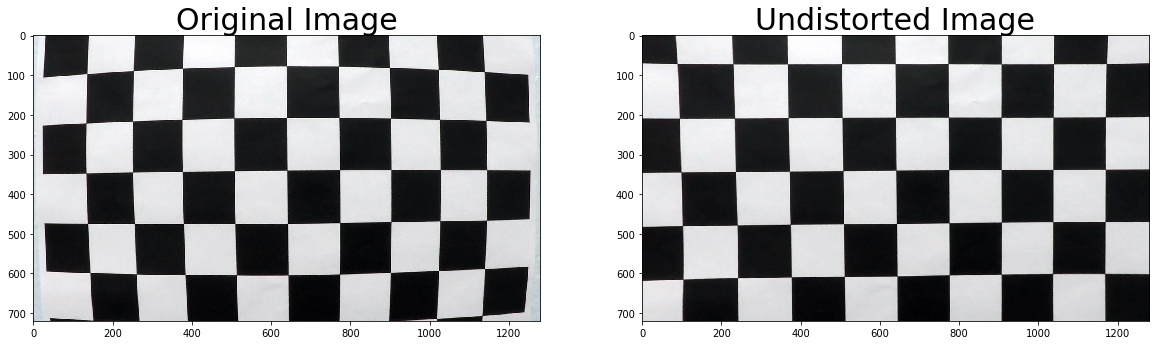

Done with camera calibration.


In [2]:
   
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

# Load image to get image shape
img = cv2.imread(images[0])
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Test undistortion on an image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()
print("Done with camera calibration.")

## Apply a distortion correction to raw test images.

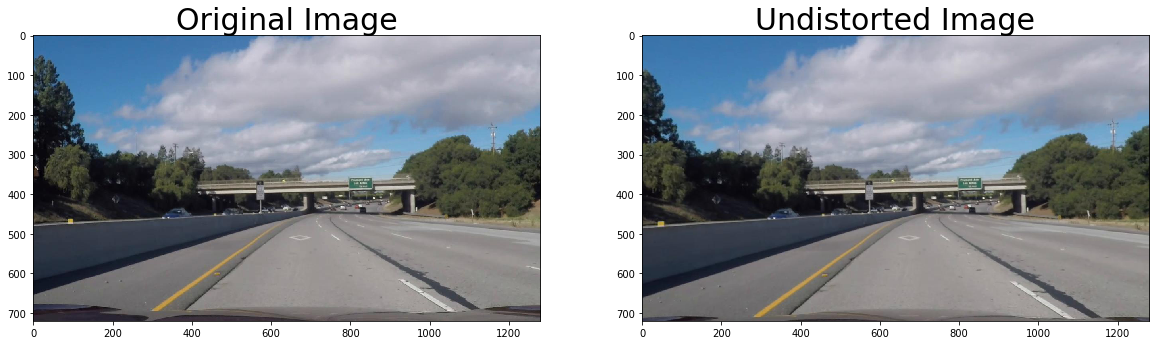

Done with distortion correction.


In [3]:
def undistort(img, mtx, dist):
    """ Distortion correct image, using camera calibration mtx and dist."""
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

# Create undistorted directory, if it doesn't exist
undistorted_dir = 'output_images/undistorted/'
if not os.path.exists(undistorted_dir):
    os.mkdir(undistorted_dir)

# Make a list of test images
testimages = glob.glob('test_images/*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

idx = 0
# Step through the list and apply distortion correction
for fname in testimages:
    idx += 1
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    dst = undistort(img, mtx, dist)
    cv2.imwrite(undistorted_dir+filename,dst)
    if (all_debug_plots) or (idx == 1):
        # Visualize undistortion
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.show()
print("Done with distortion correction.")

## Use color transforms, gradients, etc., to create a thresholded binary image.

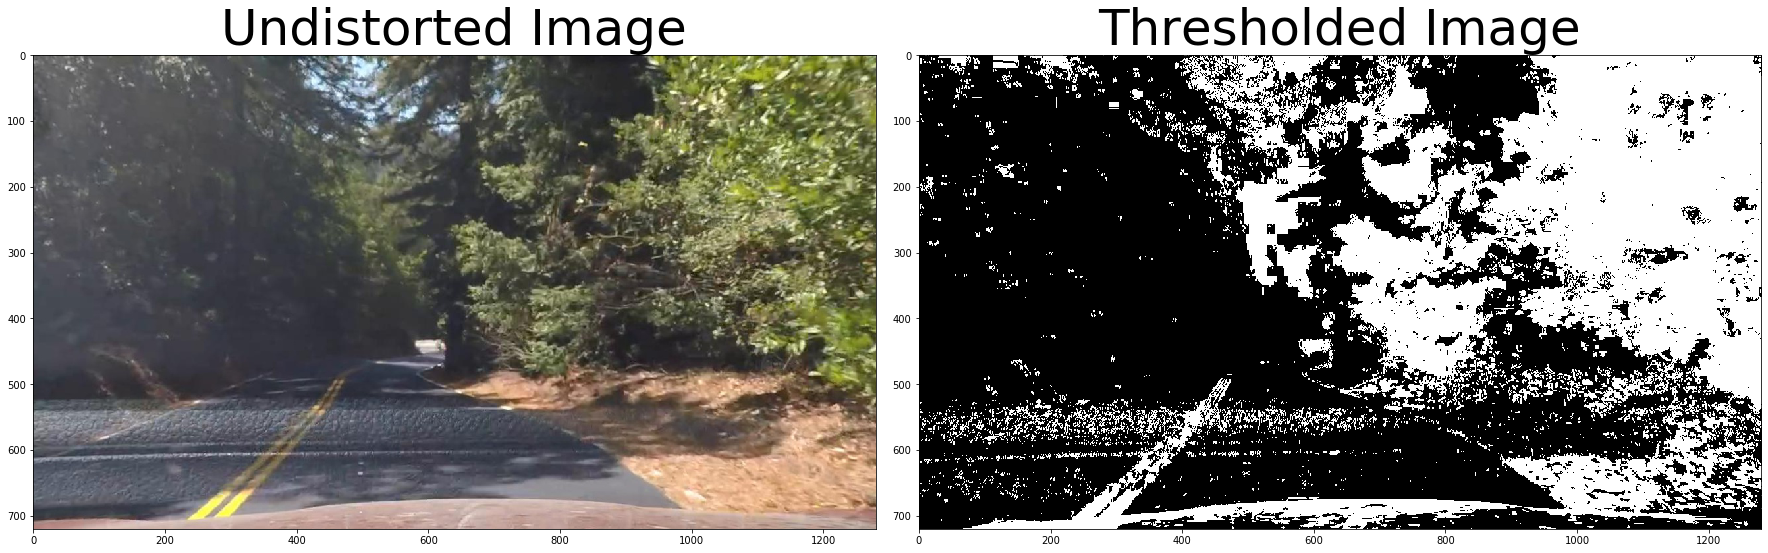

Done with thresholding.


In [4]:
from ipywidgets import interact, interactive, fixed

def thresholding(img, sx_thresh = (20, 90), l_thresh=(200, 255), h_thresh=(20, 35), v_thresh=(160,255)):
    # H and V are used to detect yellow
    # L is used to detect white
    image = np.copy(img)
    
    use_sobel = 0
    
    # Convert to gray
    gray = (cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    #Take the derivative in x
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Convert to HSV color space and separate the H and V channels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_channel = hsv[:,:,0]
    v_channel = hsv[:,:,2]
    
    v_avg = np.average(v_channel[450:600,500:800])
    #print(v_avg)
    
    if v_avg < 140:
        if v_avg < 100:
            use_sobel = 1
            v_thresh = (60, 255)
        l_thresh = (180,255)
            
    # Threshold h channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold v channel
    v_binary = np.zeros_like(h_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1  
    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(l_binary)
    combined_binary[((sxbinary == 1) & (use_sobel == 1)) | (l_binary == 1) | ((h_binary == 1) & (v_binary == 1))] = 255
    return combined_binary

# Create warped directory, if it doesn't exist
thresh_dir = 'output_images/thresholded/'
if not os.path.exists(thresh_dir):
    os.mkdir(thresh_dir)

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

# Make a list of undistorted images
undistimages = glob.glob(undistorted_dir+'*.jpg')

idx = 0
# Step through the list and apply thresholding
for fname in undistimages:
    idx += 1
    
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    thresholded = thresholding(img)
    cv2.imwrite(thresh_dir+filename,thresholded)

    # Plot the original and warped images (convert back to RGB for matplotlib)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    thresholded = cv2.cvtColor(thresholded,cv2.COLOR_GRAY2RGB)
    if all_debug_plots or idx == 3:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Undistorted Image', fontsize=50)
        ax2.imshow(thresholded)
        ax2.set_title('Thresholded Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
print("Done with thresholding.")


## Apply a perspective transform to rectify binary image ("birds-eye view").

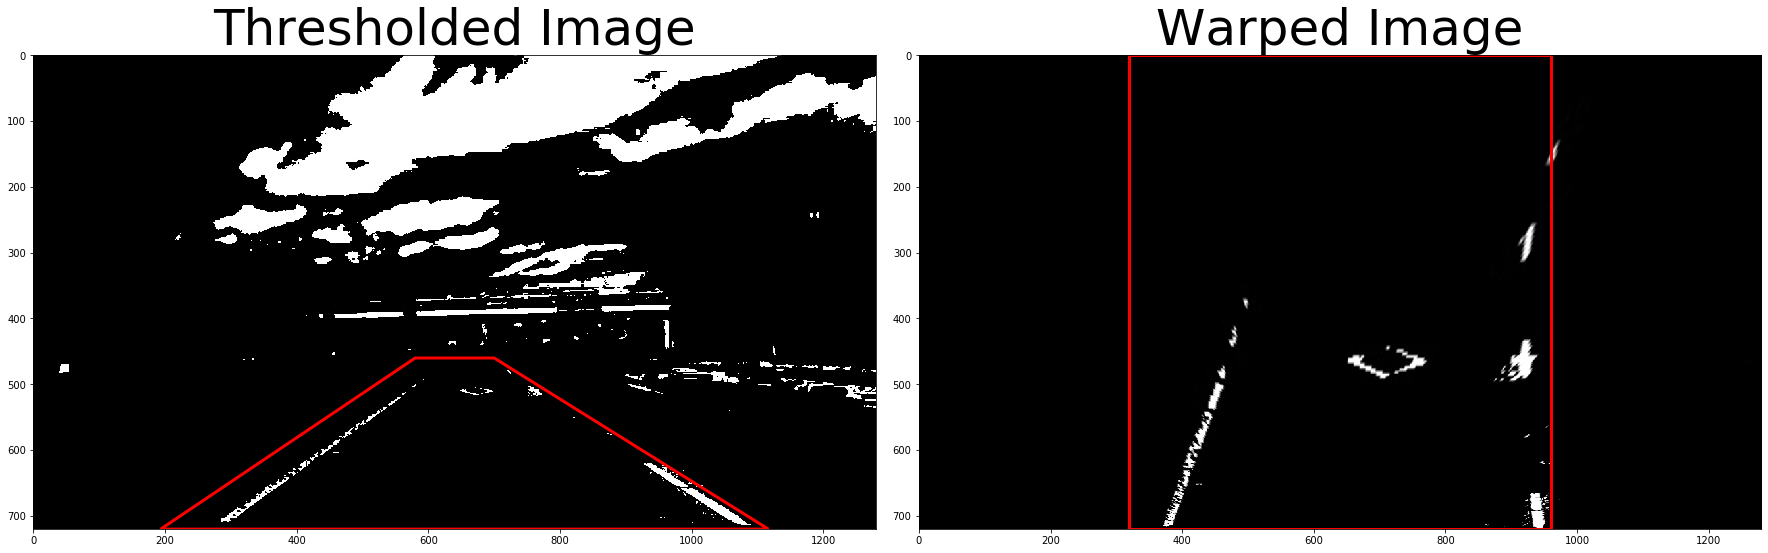

Done with perspective transform.


In [5]:
def warpimg(img, M):
    """ Warp image img using transform matrix M. """
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarpimg(img, Minv):
    """ Unwarp image img using transform matrix Minv. """
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped 

# Create warped directory, if it doesn't exist
warped_dir = 'output_images/warped/'
if not os.path.exists(warped_dir):
    os.mkdir(warped_dir)

# Make a list of thresholded images
threshimages = glob.glob(thresh_dir+'*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

# get image size
img = cv2.imread(threshimages[0])
img_size = (img.shape[1], img.shape[0])
# source image offset from x-axis center
x_cent_off = 60
# source offset from y-axis center
y_cent_off = 100

# setup source and destination points for transform
src = np.float32(
[[(img_size[0] / 2) - x_cent_off, (img_size[1] / 2) + y_cent_off],
[((img_size[0] / 6) - 20), img_size[1]],
[(img_size[0] * 5 / 6) + 50, img_size[1]],
[(img_size[0] / 2) + x_cent_off, (img_size[1] / 2) + y_cent_off]])

dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3/4), img_size[1]],
[(img_size[0] * 3/4), 0]])

# get perspective transform matrix and inverse transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

idx = 0
# Step through the list and apply perspective transform
for fname in threshimages:
    idx += 1
    
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    warped = warpimg(img, M)
    cv2.imwrite(warped_dir+filename,warped)
    
    # Plot the original and warped images (convert back to RGB for matplotlib)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    warped = cv2.cvtColor(warped,cv2.COLOR_BGR2RGB)
    if all_debug_plots or idx == 1:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        srcpoly = plt.Polygon(src, closed = True, fill = False, color = 'r', linewidth = 3)
        ax1.add_patch(srcpoly)
        ax1.imshow(img)
        ax1.set_title('Thresholded Image', fontsize=50)
        dstpoly = plt.Polygon(dst, closed = True, fill = False, color = 'r', linewidth = 3)
        ax2.add_patch(dstpoly)
        ax2.imshow(warped)
        ax2.set_title('Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
print("Done with perspective transform.")

## Detect lane pixels and fit to find the lane boundary.

In [6]:
def binary_threshold(img):
    ret,binthresh = cv2.threshold(img,220,255,cv2.THRESH_BINARY)
    return binthresh

def find_lane_pixels_box(binary_warped):
    # Take a histogram of the bottom half of the image
    width = binary_warped.shape[1]
    height = binary_warped.shape[0]
    bottom_half = np.copy(binary_warped[height//2:,:])
    # Crop the image
    bottom_half[:,0:np.int(width/5)] = 0
    bottom_half[:,np.int(width*4/5):] = 0
    # Generate histogram
    histogram = np.sum(bottom_half, axis = 0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 150
    # Set number of pixels to classify as a sharp turn
    sharpturn = 40
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_inbounds = 1
    right_inbounds = 1
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left) 
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        win_y_high = binary_warped.shape[0] - window*window_height
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        
        if left_inbounds:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            
            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = np.nonzero((nonzeroy > win_y_low) & \
                            (nonzeroy < win_y_high) & \
                            (nonzerox > win_xleft_low) & \
                            (nonzerox < win_xleft_high))[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            
            ### If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                new_leftx = np.mean(nonzerox[good_left_inds])
                diff = new_leftx - leftx_current
                if (diff >= sharpturn):
                    leftx_current = np.int(new_leftx + diff)
                elif (diff <= -sharpturn):
                    leftx_current = np.int(new_leftx + diff)
                else:
                    leftx_current = np.int(new_leftx)
                
        if right_inbounds:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 


            good_right_inds = np.nonzero((nonzeroy > win_y_low) & \
                            (nonzeroy < win_y_high) & \
                            (nonzerox > win_xright_low) & \
                            (nonzerox < win_xright_high))[0]


            right_lane_inds.append(good_right_inds)


            if len(good_right_inds) > minpix:
                new_rightx = np.mean(nonzerox[good_right_inds])
                diff = new_rightx - rightx_current
                if (diff >= sharpturn):
                    rightx_current = np.int(new_rightx + diff)
                elif (diff <= -sharpturn):
                    rightx_current = np.int(new_rightx + diff)
                else:
                    rightx_current = np.int(new_rightx)
                    
        if win_xleft_low < 0 or win_xleft_high > binary_warped.shape[1]:
            left_inbounds = 0
        if win_xright_low < 0 or win_xright_high > binary_warped.shape[1]:
            right_inbounds = 0
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def find_lane_pixels_window(binary_warped, left_fit, right_fit, margin):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###

    left_fitx = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = np.nonzero(np.abs(left_fitx - nonzerox) < margin)[0]
    right_lane_inds = np.nonzero(np.abs(right_fitx - nonzerox) < margin)[0]
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_lane_inds = np.nonzero(np.abs(left_fitx - nonzerox) < margin)[0]
    right_lane_inds = np.nonzero(np.abs(right_fitx - nonzerox) < margin)[0]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Limit in case fit gives out of bounds values
    left_fitx = np.clip(left_fitx, a_min = 0, a_max = img_shape[1]-1) 
    right_fitx = np.clip(right_fitx, a_min = 0, a_max = img_shape[1]-1)

    return left_fit, right_fit, left_fitx, right_fitx, ploty

def fit_poly_cr(leftx, lefty, rightx, righty):
    # Calculate fit in terms of meters
    ym_per_pix = 3.048/95 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit_cr, right_fit_cr

def fit_polynomial_window(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # The width of the margin around the previous polynomial to search
    margin = 80
    
    # Find lane pixels using window
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_window(binary_warped, left_fit, right_fit, margin)
    
    left_fit_new, right_fit_new, left_fit_cr, right_fit_cr = (None, None, None, None)
    result = out_img
    if (leftx is not None and rightx is not None and leftx.size != 0 and rightx.size != 0):
        # Fit new polynomials
        left_fit_new, right_fit_new, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        # Calculate fit in terms of meters
        left_fit_cr, right_fit_cr = fit_poly_cr(leftx, lefty, rightx, righty)

        ## Visualization ##    
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plots the left and right polynomials on the lane lines
        result[ploty.astype(int), left_fitx.astype(int)] = [255, 255, 0]
        result[ploty.astype(int), right_fitx.astype(int)] = [255, 255, 0]

        ## End visualization steps ##
    
    return left_fit_new, right_fit_new, left_fit_cr, right_fit_cr, result

def fit_polynomial_box(binary_warped):
    
    # Find our lane pixels using box
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_box(binary_warped)
    
    left_fit, right_fit, left_fit_cr, right_fit_cr = (None, None, None, None)
    
    if (leftx is not None and rightx is not None and leftx.size != 0 and rightx.size != 0):
        # Calculate fit in terms of pixels
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        # Calculate fit in terms of meters
        left_fit_cr, right_fit_cr = fit_poly_cr(leftx, lefty, rightx, righty)
        
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        out_img[ploty.astype(int), left_fitx.astype(int)] = [255, 255, 0]
        out_img[ploty.astype(int), right_fitx.astype(int)] = [255, 255, 0]
    
    return left_fit, right_fit, left_fit_cr, right_fit_cr, out_img


## Determine the curvature of the lane and vehicle position with respect to center.

In [7]:
def measure_curvature_real(img, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/95 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*(img.shape[0]-1)
    
    ##### Calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5/np.abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5/np.abs(2*right_fit_cr[0])
    curverad = (left_curverad+right_curverad)/2
    
    # Calculate center offset
    car_position = img.shape[1]/2*xm_per_pix
    left_lane_pos = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_lane_pos = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    lane_center_position = (right_lane_pos + left_lane_pos) /2
    center_offset = (car_position - lane_center_position)
    
    return left_curverad, right_curverad, curverad, center_offset

## Warp the detected lane boundaries back onto the original image.

In [8]:
def draw_lane_bounds(warped, undist, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    height, width = warped.shape
    ploty = np.linspace(0, height-1, num=height)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (width, height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [9]:
def draw_data(img, curve_rad, center_offset):
    new_img = np.copy(img)
    height = new_img.shape[0]
    
    # Curvature radius
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curvature radius: ' + '{:05.2f}'.format(curve_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,0,0), 3, cv2.LINE_AA)
    direction = ''
    
    # Center offset
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'    
    abs_center_offset = abs(center_offset)
    text = '{:04.3f}'.format(abs_center_offset) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,150), font, 1.5, (0,0,0), 3, cv2.LINE_AA)
    return new_img

def check_fit(img, left_fit, right_fit):

    max_x_int_diff = 750
    min_x_int_diff = 300
    diverging_diff = 200
    
    if left_fit is not None and right_fit is not None:
        x_max = img.shape[1]
        y_max = img.shape[0]
        
        # calculate x-intercept and the difference between them
        left_fit_x_int = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
        right_fit_x_int = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
        x_int_diff = right_fit_x_int-left_fit_x_int
        
        # calculate difference between fits when y = 0, which is just the constant parameter
        # limit it to between 0 and x_max in case of very curvy road
        left_fit_x_at_zero = min(x_max,max(0, left_fit[2]))
        right_fit_x_at_zero = min(x_max,max(0, right_fit[2]))
        x_diff_at_zero = right_fit_x_at_zero - left_fit_x_at_zero
        
        # Check if the x-intercept of the left and right lane are too far apart or too close
        if x_int_diff > max_x_int_diff or x_int_diff < min_x_int_diff:
            left_fit = None
            right_fit = None
            
        # Check if the difference at y = 0 is negative (meaning line are crossing)
        if x_diff_at_zero < 0:
            left_fit = None
            right_fit = None
            
        # Check if difference at y = 0 is much greater than difference at x-intercept
        # This would mean lines are diverging
        if x_diff_at_zero - x_int_diff > diverging_diff:
            left_fit = None
            right_fit = None
            
    return left_fit, right_fit

## Test lane detection and final image output

Left curvature radius: 1071.561515691631 meters
Right curvature radius: 223.36517894431316 meters
Left fit coefficients: [-8.36743789e-05 -2.61641913e-01  6.06564260e+02]
Right fit coefficients: [ 3.99449132e-04 -3.62848990e-01  9.98440431e+02]
Good Fit


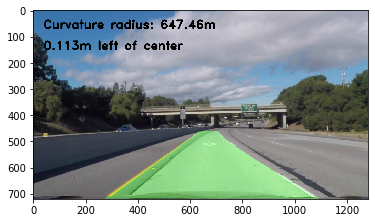

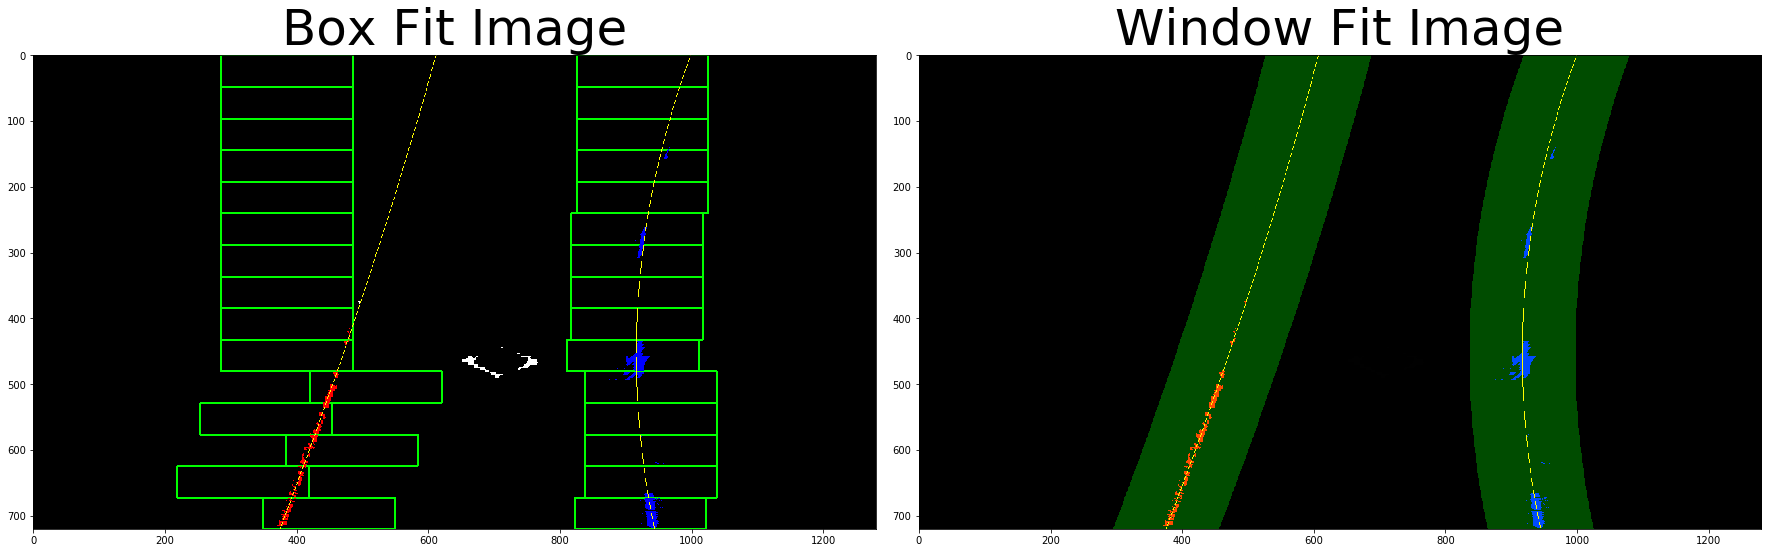

Left curvature radius: 259.5625629054782 meters
Right curvature radius: 150.63326792928785 meters
Left fit coefficients: [ 3.44098310e-04 -7.51638143e-01  7.36203475e+02]
Right fit coefficients: [ 5.92675528e-04 -6.13281117e-01  1.05486939e+03]
Good Fit


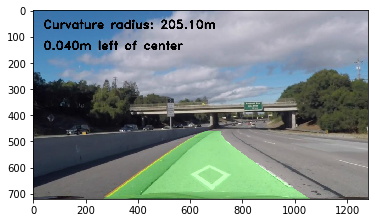

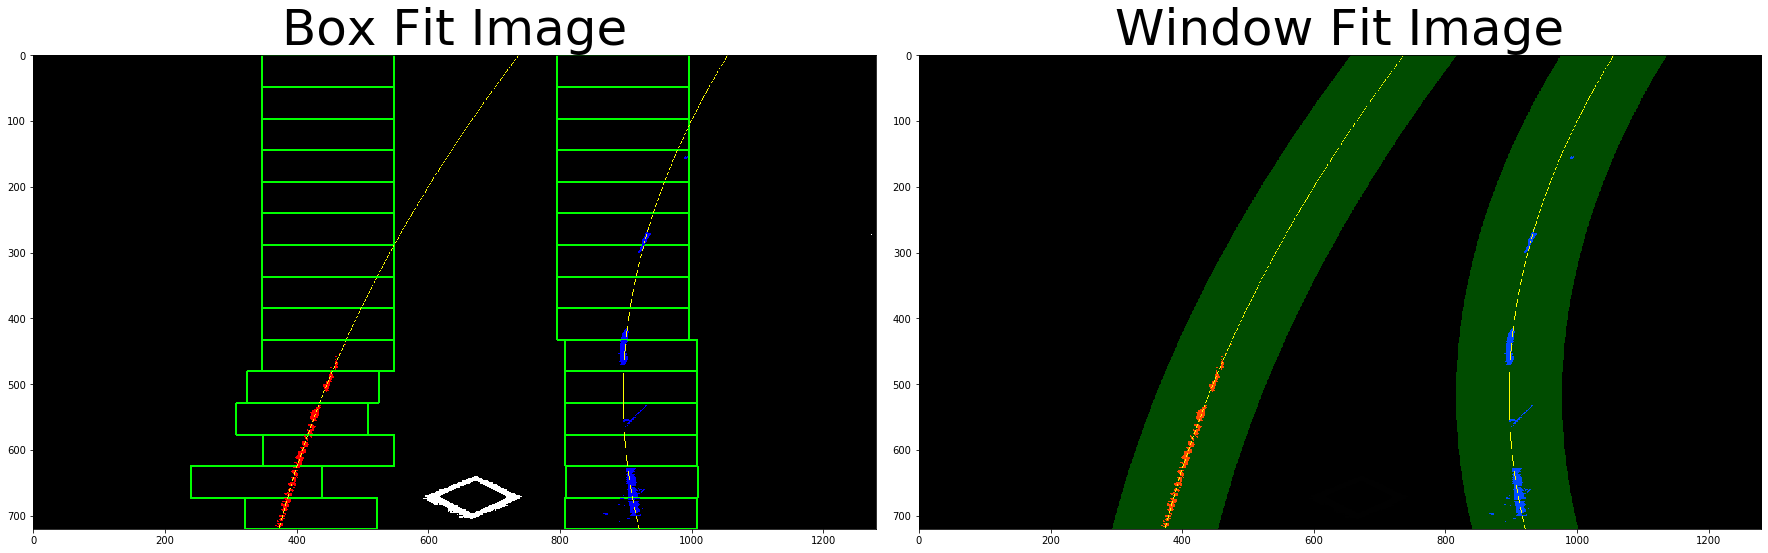

Left curvature radius: 127.21443554372598 meters
Right curvature radius: 146.90022452830206 meters
Left fit coefficients: [ 7.27961004e-04 -1.41366693e-01  1.05759548e+02]
Right fit coefficients: [ 6.06456898e-04 -7.54690403e-01  1.21714964e+03]
Bad Fit


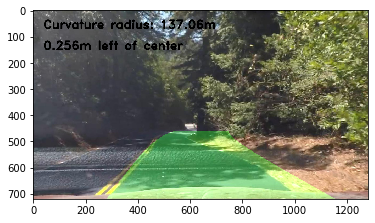

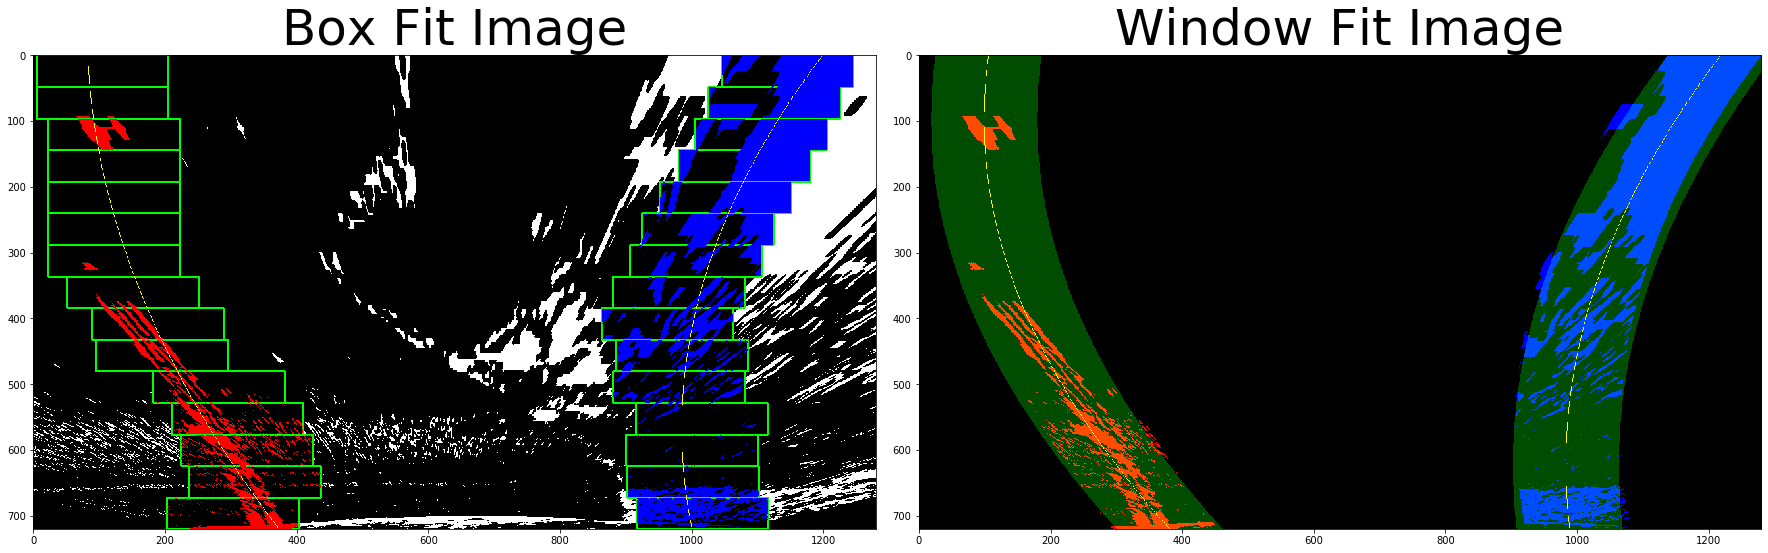

Left curvature radius: 14482.721385127334 meters
Right curvature radius: 159.90413730776157 meters
Left fit coefficients: [-6.16832641e-06 -2.56388860e-01  5.79793959e+02]
Right fit coefficients: [ 5.58772332e-04 -5.31458266e-01  9.95857801e+02]
Good Fit


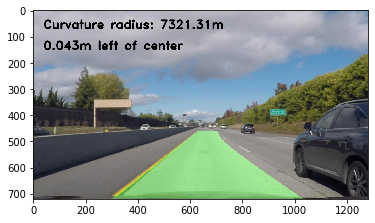

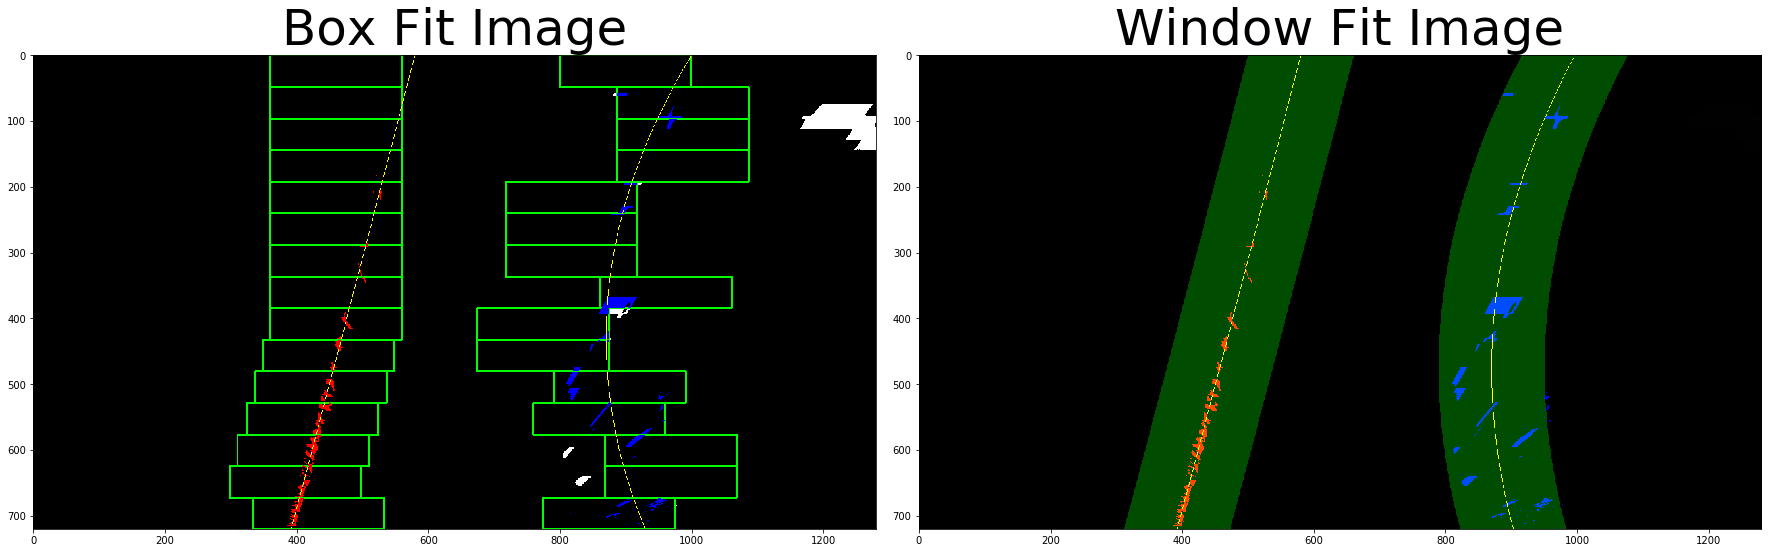

Left curvature radius: 28.062187217646645 meters
Right curvature radius: 39.93384150927697 meters
Left fit coefficients: [-3.17686219e-03  4.40142648e+00 -1.18755012e+03]
Right fit coefficients: [-2.23129965e-03  3.07668351e+00 -1.41414469e+02]
Good Fit


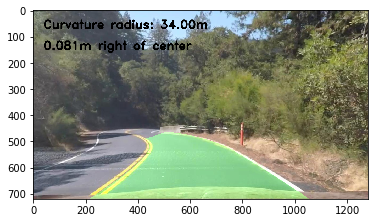

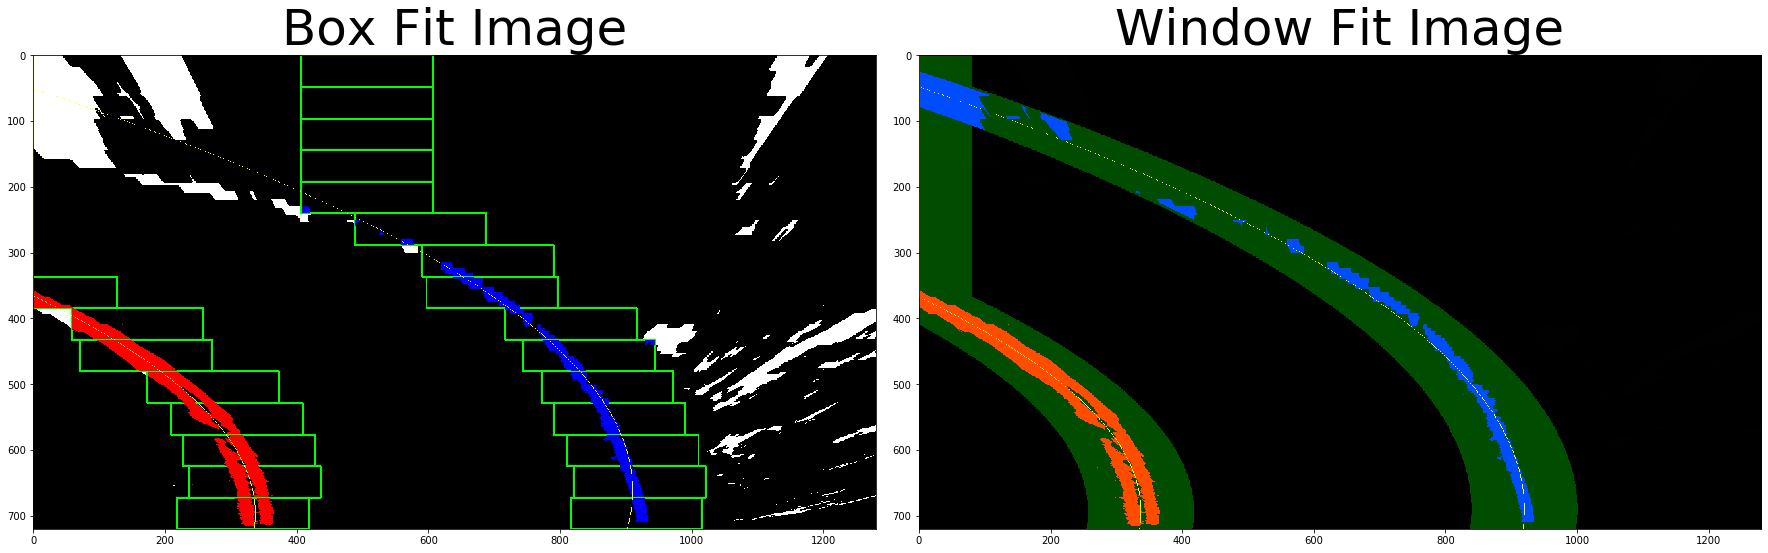

Left curvature radius: 217.9155866361721 meters
Right curvature radius: 125.79548907129289 meters
Left fit coefficients: [ 4.10830645e-04 -9.29351210e-01  8.11115987e+02]
Right fit coefficients: [ 7.08237640e-04 -8.96763363e-01  1.16598260e+03]
Good Fit


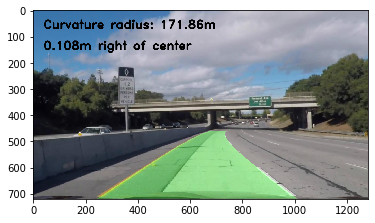

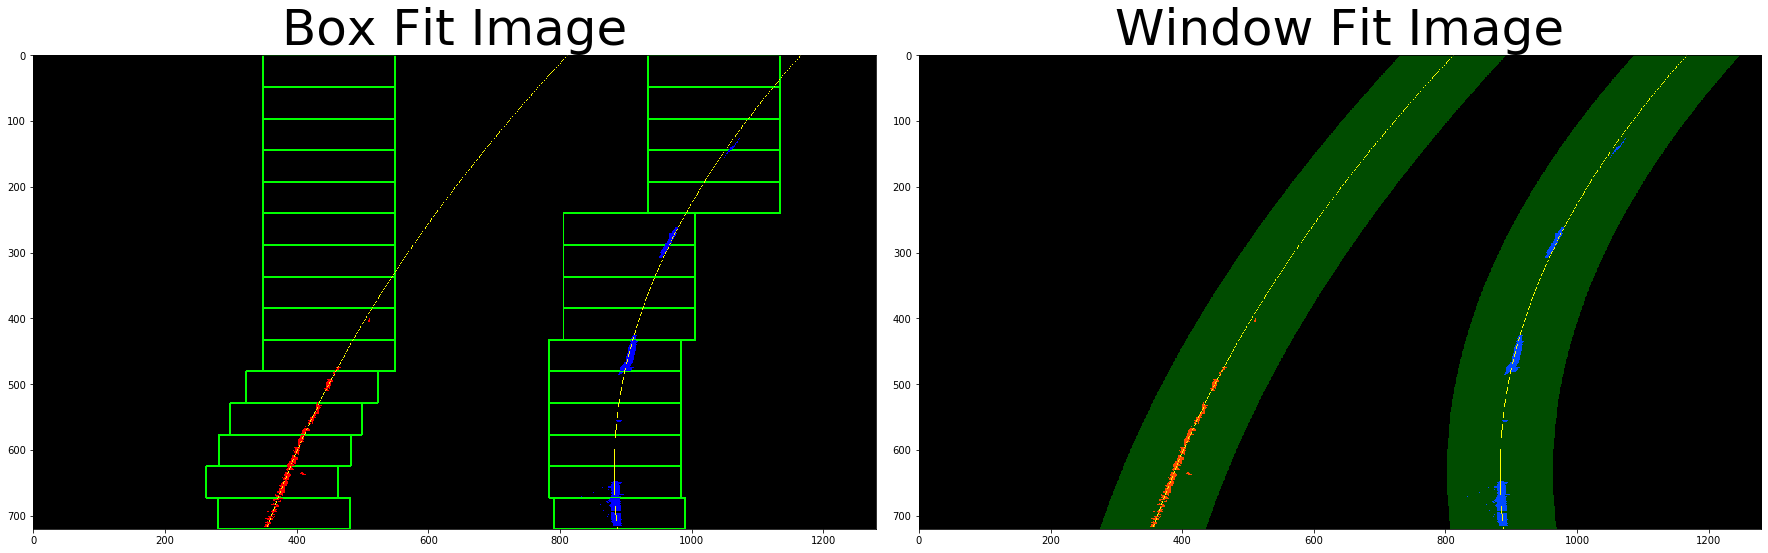

Left curvature radius: 195.3829935276799 meters
Right curvature radius: 187.9630318996933 meters
Left fit coefficients: [ 4.58927651e-04 -1.04323073e+00  8.80972302e+02]
Right fit coefficients: [ 4.73857579e-04 -7.76018462e-01  1.21244901e+03]
Good Fit


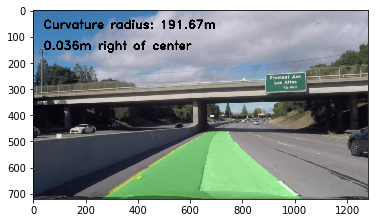

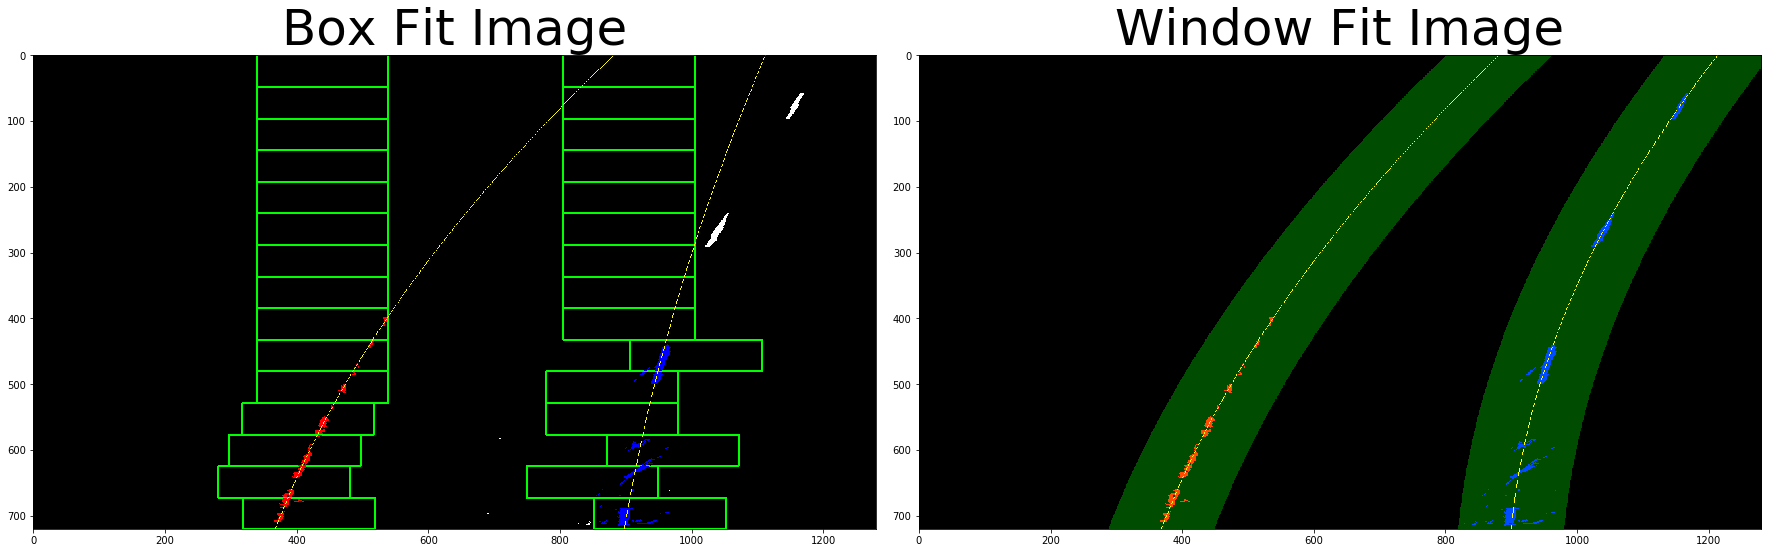

Left curvature radius: 36.152846586569204 meters
Right curvature radius: 20.952209079658 meters
Left fit coefficients: [ 2.66600078e-03 -2.54000653e+00  8.88115780e+02]
Right fit coefficients: [ 4.64782575e-03 -5.30604038e+00  2.37902589e+03]
Good Fit


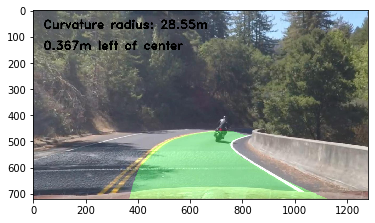

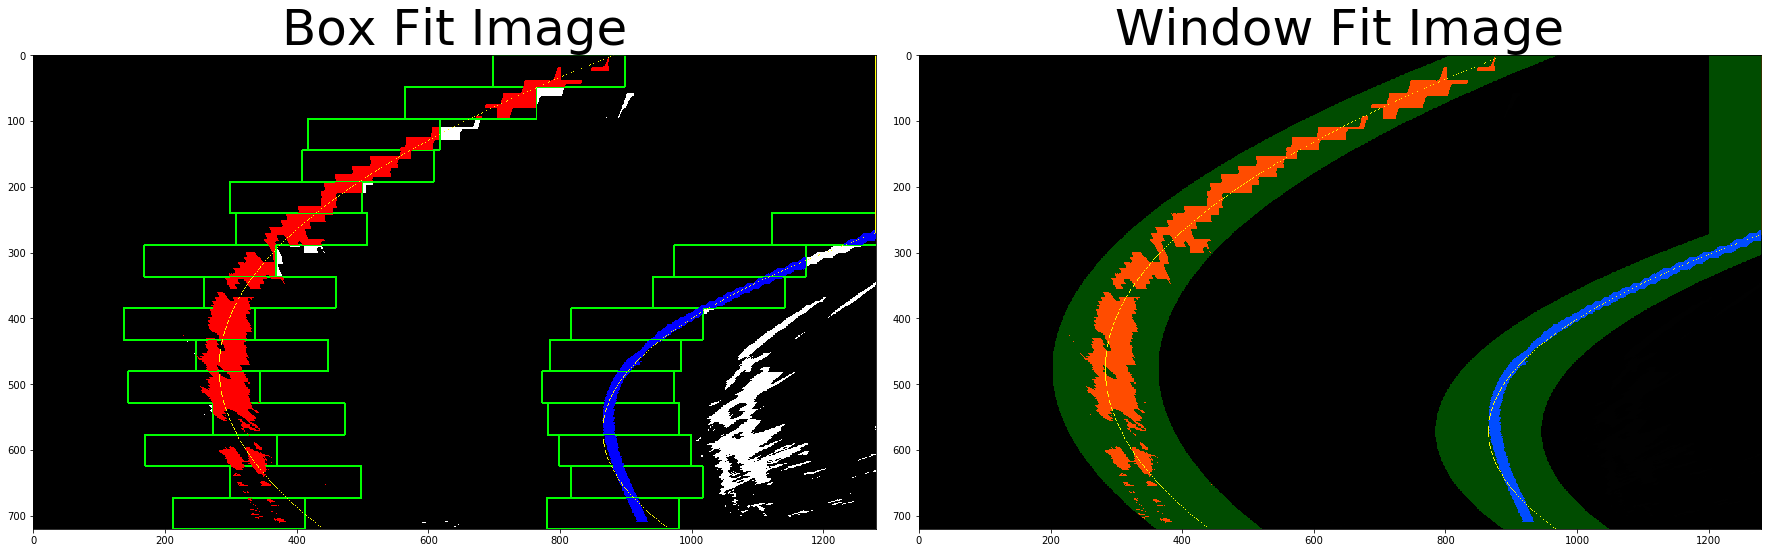

Left curvature radius: 17432.039452550005 meters
Right curvature radius: 2539.159217889627 meters
Left fit coefficients: [5.10723283e-06 4.34146869e-03 3.27563419e+02]
Right fit coefficients: [ 3.50623843e-05 -4.60103329e-02  9.67025691e+02]
Good Fit


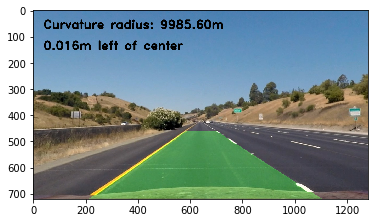

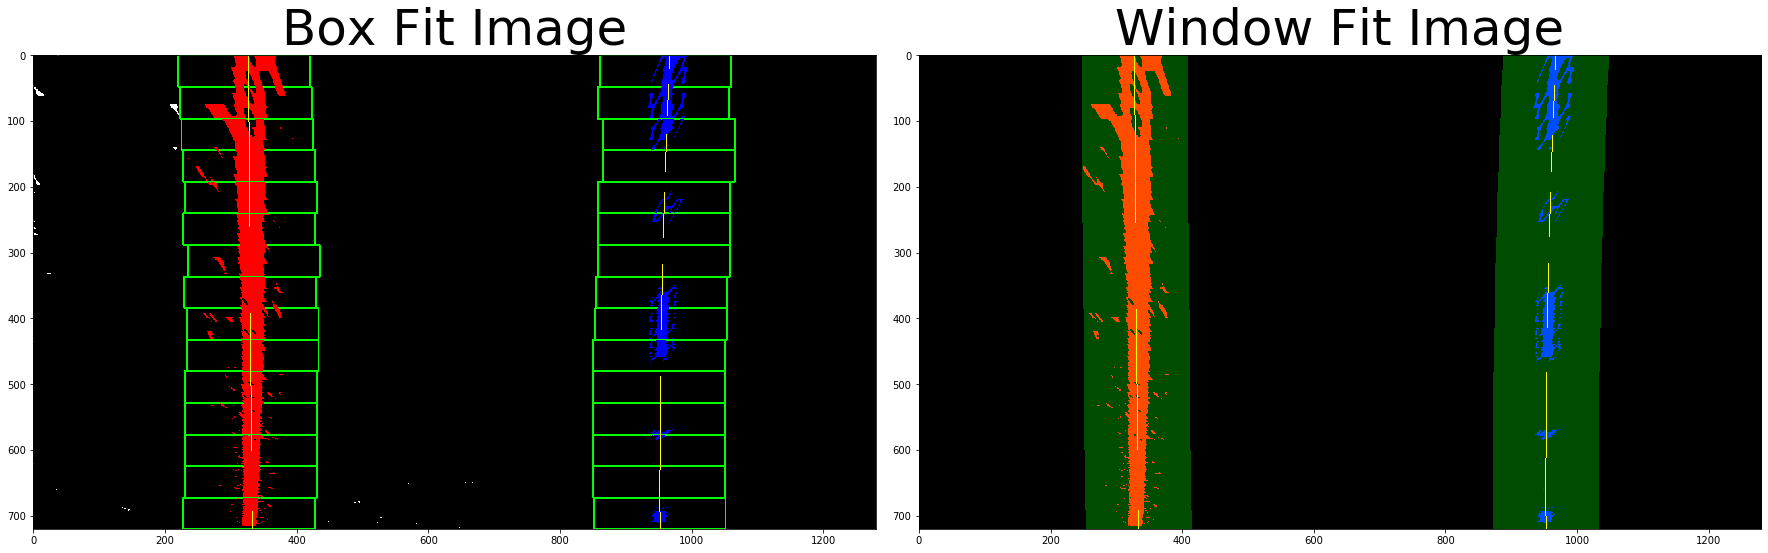

Left curvature radius: 10623.07638068011 meters
Right curvature radius: 12027.159596046893 meters
Left fit coefficients: [8.38096251e-06 1.29610240e-02 3.24059560e+02]
Right fit coefficients: [ 7.40296433e-06 -5.28992324e-02  9.86694909e+02]
Good Fit


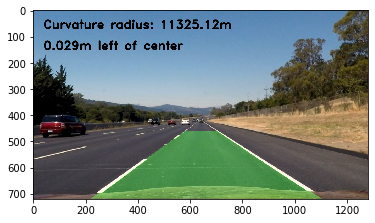

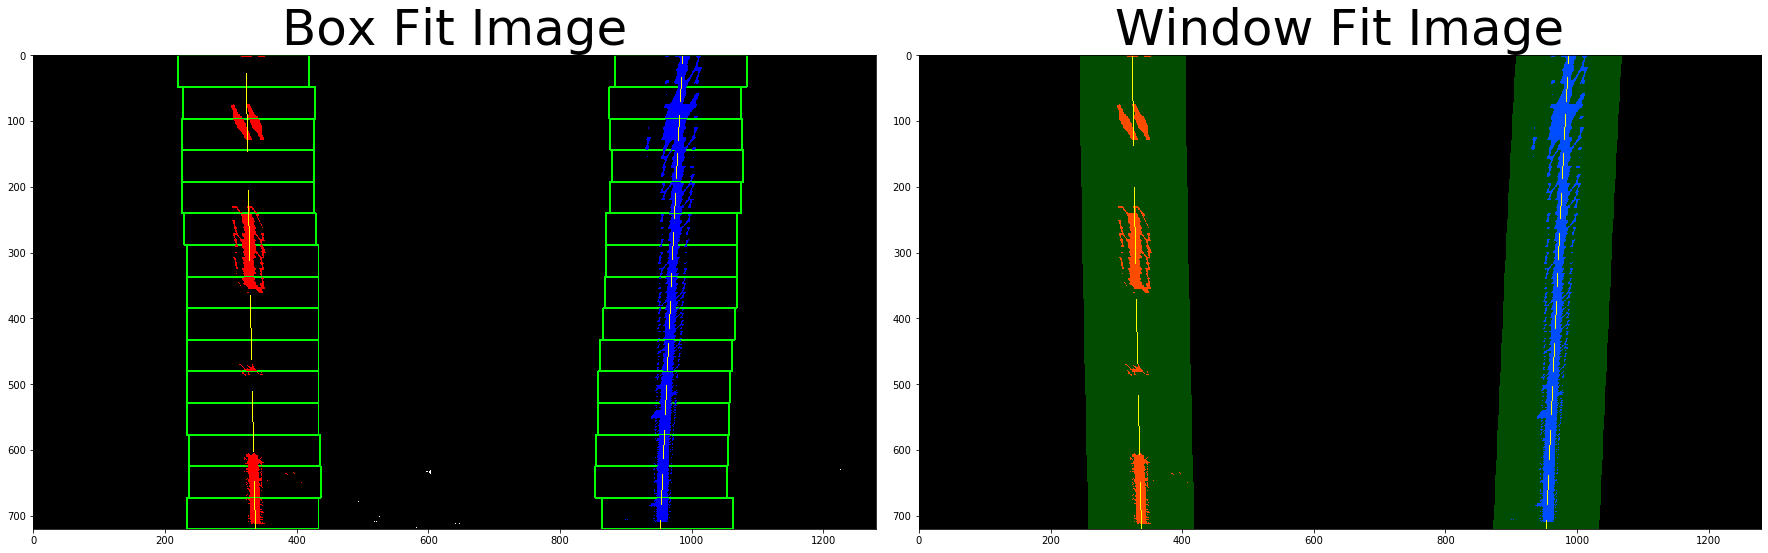

Left curvature radius: 2731.822619081452 meters
Right curvature radius: 832.2976350875336 meters
Left fit coefficients: [ 3.25917897e-05 -9.37112867e-03  3.48444330e+02]
Right fit coefficients: [ 1.07006292e-04 -2.40037824e-01  1.10499783e+03]
Good Fit


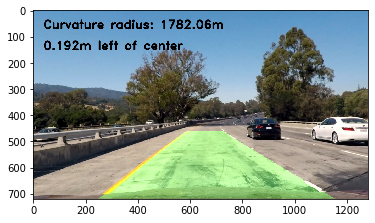

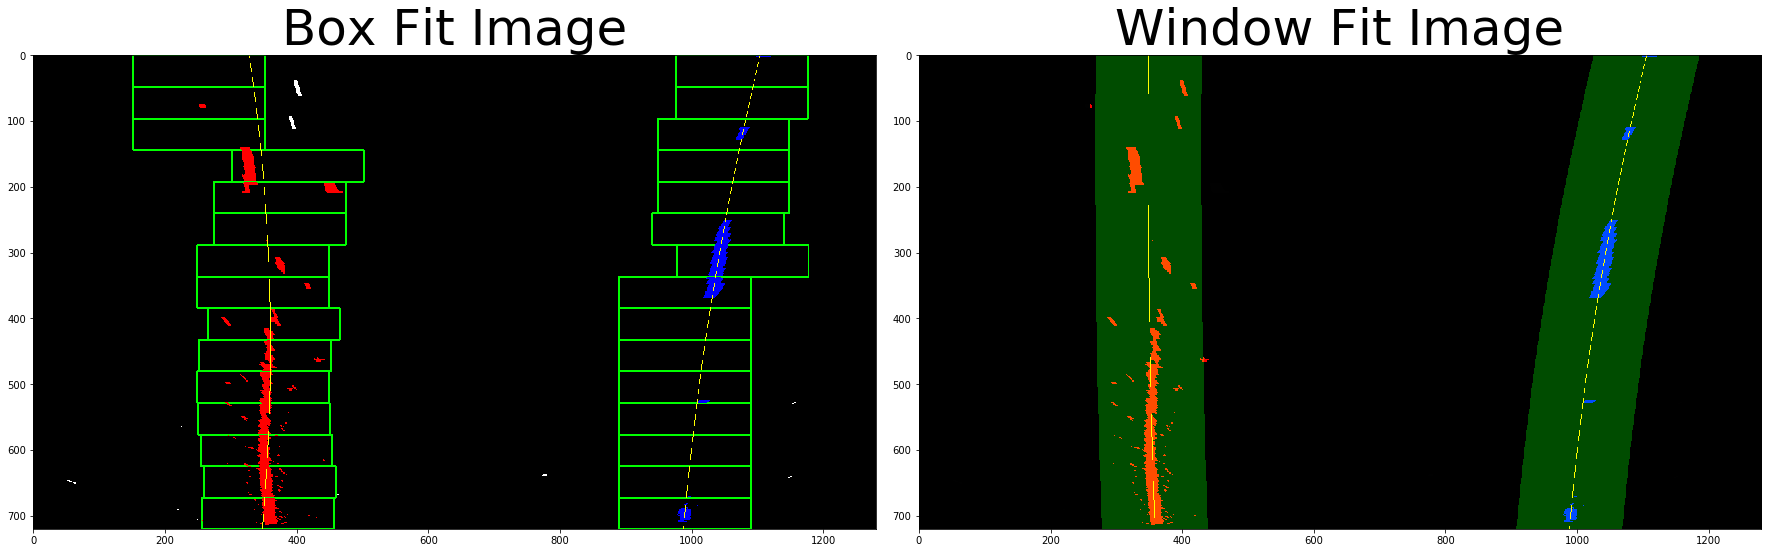

Left curvature radius: 381.2136376871048 meters
Right curvature radius: 365.8130264026639 meters
Left fit coefficients: [-2.33541425e-04  3.27740965e-01  2.73361151e+02]
Right fit coefficients: [-2.43420096e-04  2.86782128e-01  9.14946286e+02]
Good Fit


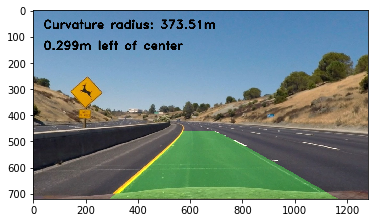

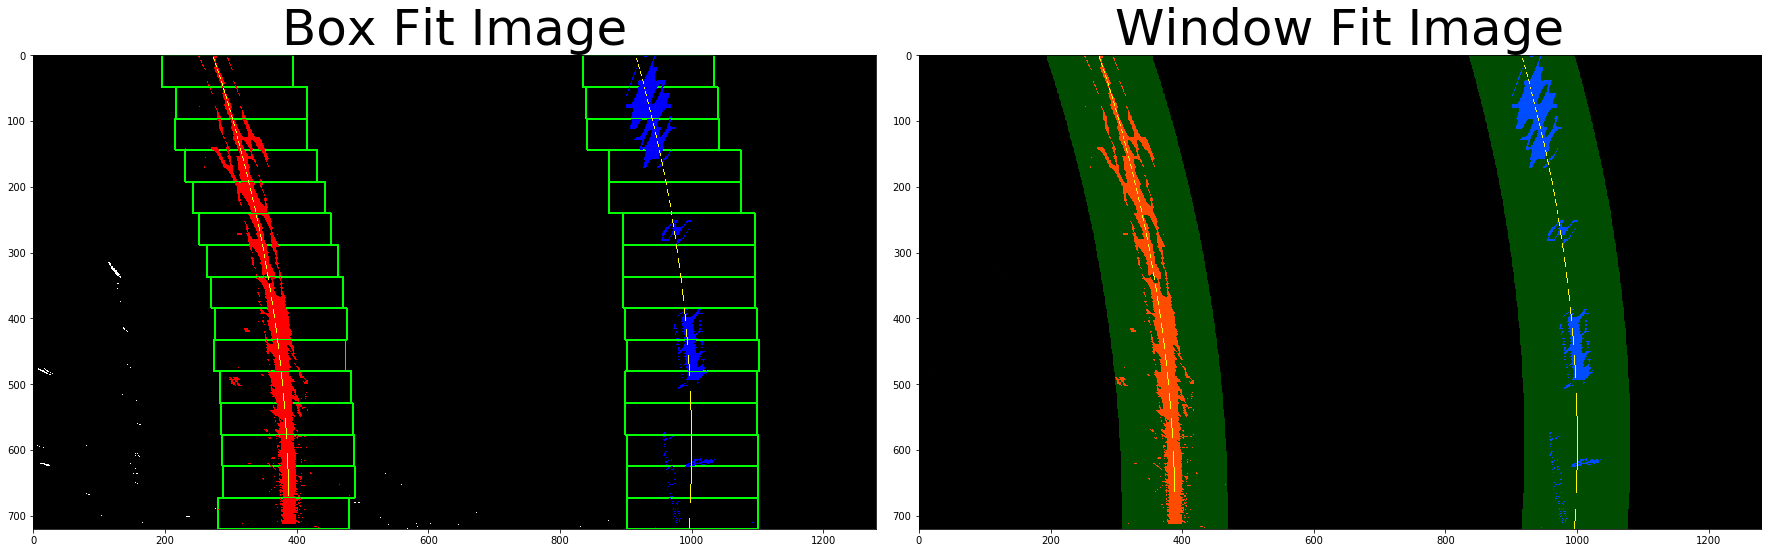

Left curvature radius: 786.2578567616574 meters
Right curvature radius: 529.9732441329193 meters
Left fit coefficients: [ 1.13299570e-04 -2.74294685e-01  4.87929183e+02]
Right fit coefficients: [ 1.68044094e-04 -3.24799438e-01  1.12381766e+03]
Good Fit


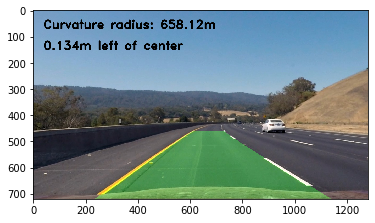

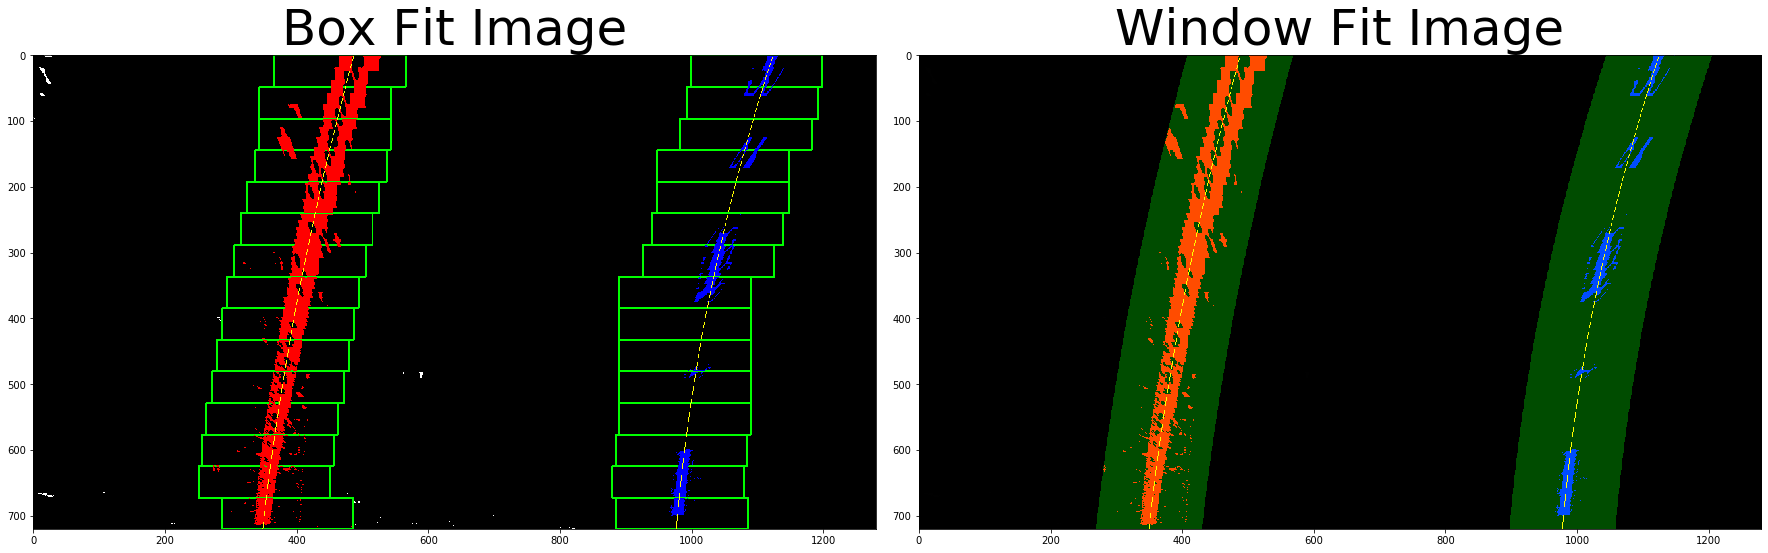

Left curvature radius: 931.2010733792163 meters
Right curvature radius: 260.18463123048673 meters
Left fit coefficients: [ 9.56149938e-05 -9.48296793e-02  3.93083643e+02]
Right fit coefficients: [ 3.42337233e-04 -3.93871166e-01  1.12678743e+03]
Good Fit


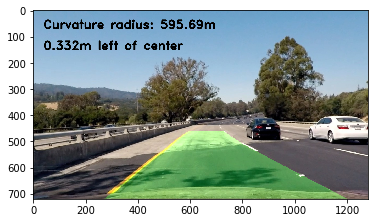

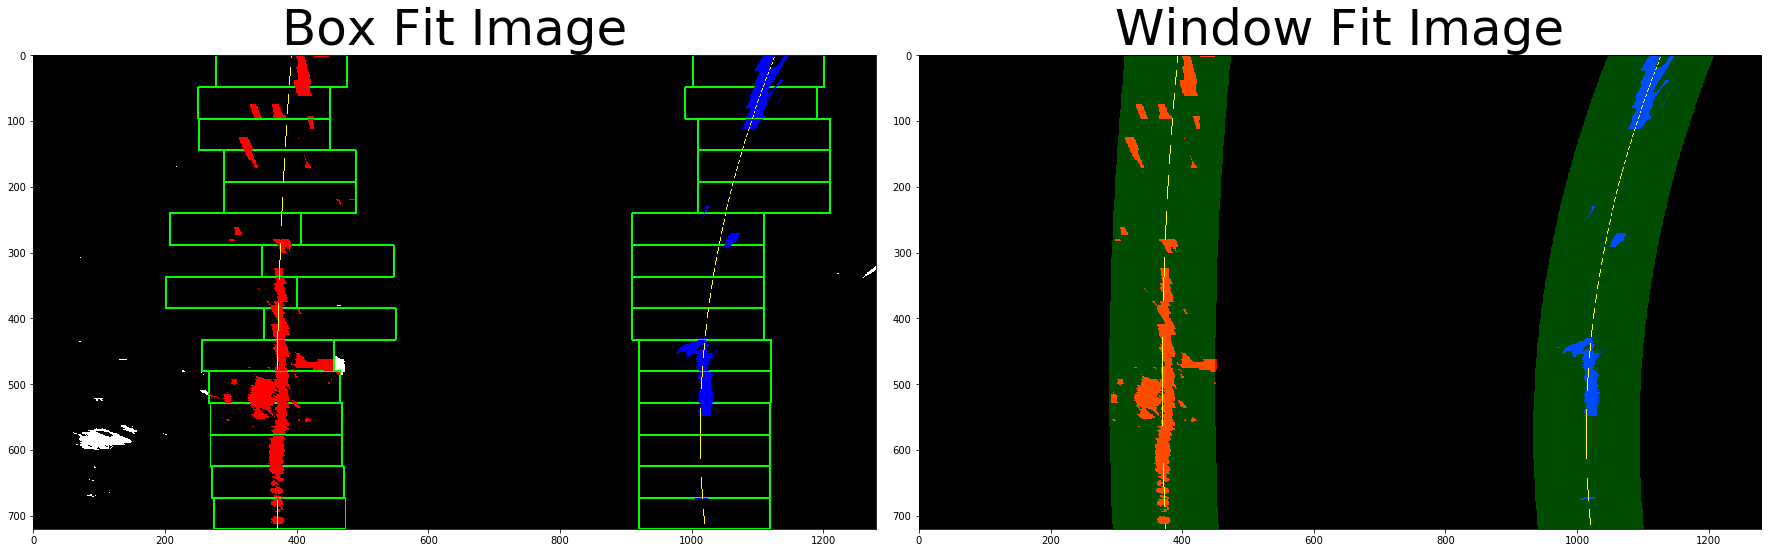

Left curvature radius: 38.973755212253025 meters
Right curvature radius: 80.06101390012256 meters
Left fit coefficients: [-2.31656006e-03  2.79359806e+00 -4.61183258e+02]
Right fit coefficients: [ 1.12350841e-03 -1.15528739e+00  1.28143501e+03]
Bad Fit


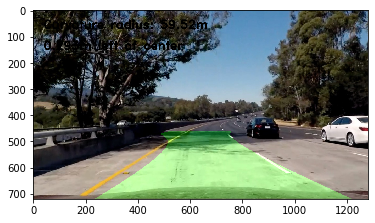

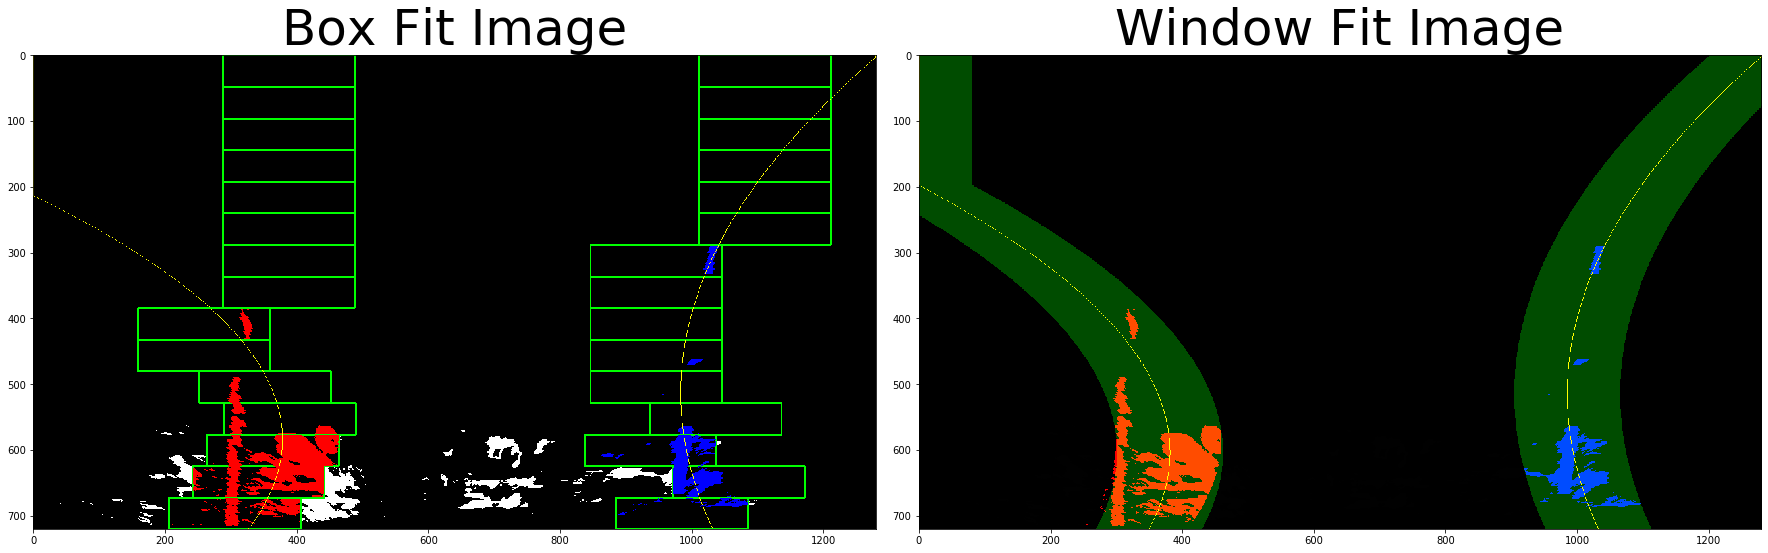

Left curvature radius: 588.8527709456415 meters
Right curvature radius: 489.2727096433629 meters
Left fit coefficients: [ 1.51273597e-04 -3.23815352e-01  5.15793074e+02]
Right fit coefficients: [ 1.82009453e-04 -3.35137180e-01  1.15465175e+03]
Good Fit


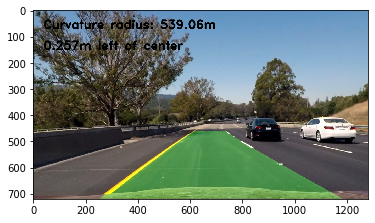

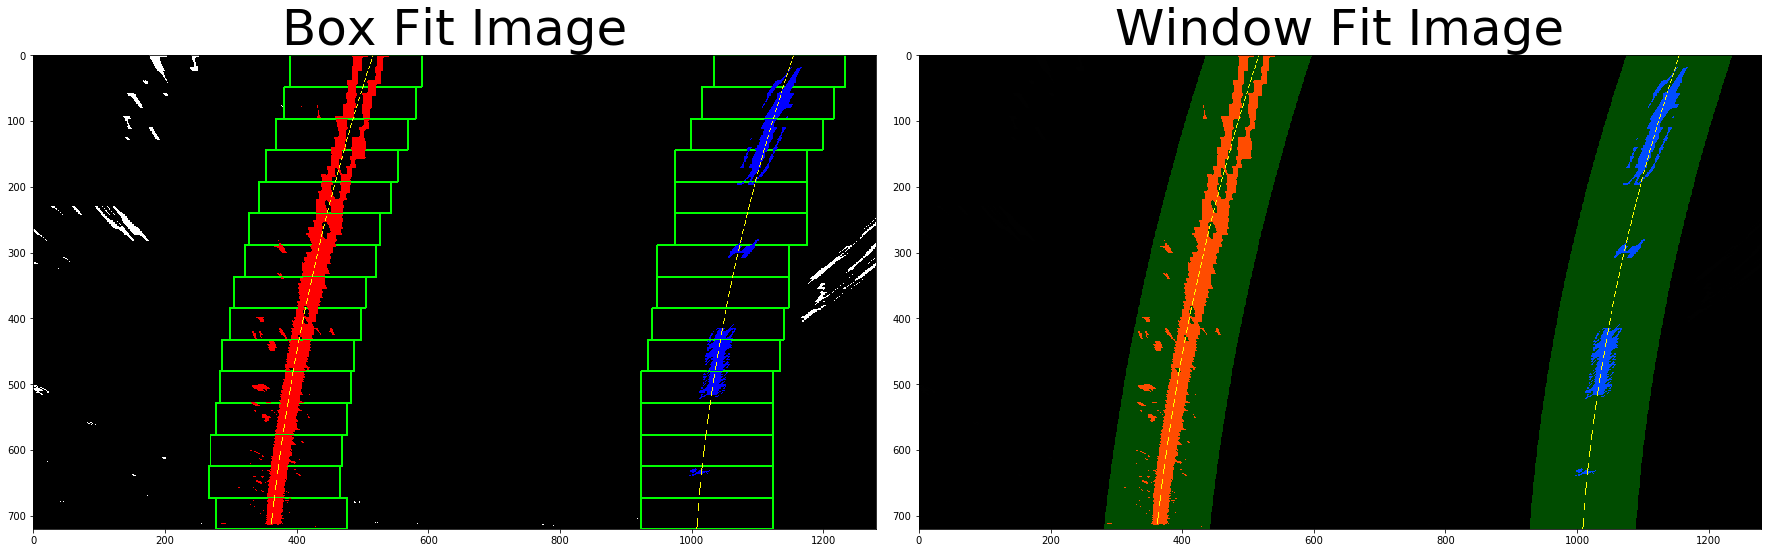

In [16]:
# Make a list of warped images
warpedimages = glob.glob(warped_dir+'*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 1

idx = 0
# Step through the list and apply perspective transform
for fname in warpedimages:
    idx += 1
    
    if all_debug_plots or idx == 1:
        img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        undist = cv2.imread(undistimages[idx-1])
        filename = os.path.basename(fname)
        binary = binary_threshold(img)

        left_fit, right_fit, left_fit_cr, right_fit_cr, box_img = fit_polynomial_box(binary)
        left_fit, right_fit, left_fit_cr, right_fit_cr, window_img = fit_polynomial_window(binary, left_fit, right_fit)
        left_curv_rad, right_curv_rad, curve_rad, center_offset = measure_curvature_real(binary, left_fit_cr, right_fit_cr)
        print("Left curvature radius: " + str(left_curv_rad) + " meters")
        print("Right curvature radius: " + str(right_curv_rad) + " meters")

        unwarped_img = draw_lane_bounds(binary, undist, left_fit, right_fit, Minv)
        final_img = draw_data(unwarped_img, curve_rad, center_offset)
        plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

        print("Left fit coefficients: "+ str(left_fit))
        print("Right fit coefficients: "+ str(right_fit))
        left_fit, right_fit = check_fit(binary, left_fit, right_fit)
        if left_fit is None or right_fit is None:
            print("Bad Fit")
        else:
            print("Good Fit")
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(box_img)
        ax1.set_title('Box Fit Image', fontsize=50)
        ax2.imshow(window_img)
        ax2.set_title('Window Fit Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

## Image processing pipeline

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def updatefit(self, fit):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)
                if self.diffs[0] < 0.0004 and self.diffs[1] < 0.4 and self.diffs[2] < 300:
                    self.current_fit.append(fit)
                    self.detected = True
                    if len(self.current_fit) > 5:
                        self.current_fit.pop(0)
                else:
                    self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                
            if len(self.current_fit) > 1:
                self.best_fit = np.average(self.current_fit, axis=0)
            else:
                self.best_fit = fit
            #print("Current fit " + str(self.current_fit))
            #print("Best fit " + str(self.best_fit))
        else:
            self.detected = False
            

def process_image(img):
    
    # Convert to BGR
    img_bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    # Undistort
    undist = undistort(img_bgr, mtx, dist)
    # Apply thresholding
    thresholded = thresholding(undist)
    # Warp to birds eye view
    warped = warpimg(thresholded, M)
    # Convert to binary
    binary = binary_threshold(warped)
    # Find lane lines and polynomial fit
    if LeftLane.detected and RightLane.detected:
        left_fit, right_fit, left_fit_cr, right_fit_cr, window_img = fit_polynomial_window(binary, LeftLane.best_fit, RightLane.best_fit)
    else:
        left_fit, right_fit, left_fit_cr, right_fit_cr, box_img = fit_polynomial_box(binary)
    
    left_fit, right_fit = check_fit(binary, left_fit, right_fit)
    
    LeftLane.updatefit(left_fit)
    RightLane.updatefit(right_fit)
    
    if LeftLane.detected and RightLane.detected:
        # Calculate the curvature radius and center offset
        left_curv_rad, right_curv_rad, curve_rad, center_offset = measure_curvature_real(binary, left_fit_cr, right_fit_cr)
        LeftLane.radius_of_curvature = left_curv_rad
        RightLane.radius_of_curvature = right_curv_rad
        LeftLane.center_offset = center_offset
        RightLane.center_offset = center_offset
        
    if LeftLane.best_fit is not None and RightLane.best_fit is not None:
        curve_radius = (LeftLane.radius_of_curvature + RightLane.radius_of_curvature)/2
        # Unwarp and draw lane boundaries on the undistorted image
        unwarped_img = draw_lane_bounds(binary, undist, LeftLane.best_fit, RightLane.best_fit, Minv)
        # Draw curvature radius and center offset data
        data_img = draw_data(unwarped_img, curve_radius, LeftLane.center_offset)
        # Convert back to RGB
        final_img = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    else:
        final_img = img
    
    return final_img

## Process a project video.

In [12]:
LeftLane = Line()
RightLane = Line()

# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
project_output = outvid_dir + 'project_video.mp4'
##clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(project_output, audio=False)

89.36433333333333
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

89.36433333333333


  0%|          | 1/1261 [00:00<03:19,  6.31it/s]

89.92628888888889


  0%|          | 2/1261 [00:00<03:22,  6.22it/s]

90.16653333333333


  0%|          | 3/1261 [00:00<03:21,  6.25it/s]

90.35937777777778


  0%|          | 4/1261 [00:00<03:20,  6.27it/s]

90.46686666666666


  0%|          | 5/1261 [00:00<03:14,  6.45it/s]

90.62646666666667


  0%|          | 6/1261 [00:00<03:12,  6.50it/s]

90.7136


  1%|          | 7/1261 [00:01<03:12,  6.52it/s]

90.73624444444444


  1%|          | 8/1261 [00:01<03:14,  6.43it/s]

90.15524444444445


  1%|          | 9/1261 [00:01<03:15,  6.39it/s]

89.84897777777778


  1%|          | 10/1261 [00:01<03:22,  6.19it/s]

89.75715555555556


  1%|          | 11/1261 [00:01<03:19,  6.26it/s]

89.2418


  1%|          | 12/1261 [00:01<03:12,  6.48it/s]

89.22944444444444


  1%|          | 13/1261 [00:02<03:10,  6.55it/s]

89.28566666666667


  1%|          | 14/1261 [00:02<03:03,  6.78it/s]

89.47255555555556


  1%|          | 15/1261 [00:02<02:58,  6.96it/s]

89.97066666666667


  1%|▏         | 16/1261 [00:02<02:58,  6.98it/s]

90.02771111111112


  1%|▏         | 17/1261 [00:02<02:58,  6.96it/s]

90.1712


  1%|▏         | 18/1261 [00:02<02:58,  6.94it/s]

90.21377777777778


  2%|▏         | 19/1261 [00:02<02:54,  7.11it/s]

90.19437777777777


  2%|▏         | 20/1261 [00:03<02:53,  7.16it/s]

90.24291111111111


  2%|▏         | 21/1261 [00:03<02:55,  7.05it/s]

90.01926666666667


  2%|▏         | 22/1261 [00:03<02:54,  7.09it/s]

89.91135555555556


  2%|▏         | 23/1261 [00:03<02:56,  7.02it/s]

89.62073333333333


  2%|▏         | 24/1261 [00:03<02:55,  7.05it/s]

88.72928888888889


  2%|▏         | 25/1261 [00:03<02:59,  6.89it/s]

88.74355555555556


  2%|▏         | 26/1261 [00:03<02:57,  6.96it/s]

88.76504444444444


  2%|▏         | 27/1261 [00:04<02:58,  6.90it/s]

88.85773333333333


  2%|▏         | 28/1261 [00:04<02:55,  7.01it/s]

88.66902222222222


  2%|▏         | 29/1261 [00:04<02:59,  6.85it/s]

88.36733333333333


  2%|▏         | 30/1261 [00:04<02:58,  6.88it/s]

88.131


  2%|▏         | 31/1261 [00:04<02:54,  7.04it/s]

88.37531111111112


  3%|▎         | 32/1261 [00:04<02:52,  7.12it/s]

88.36904444444444


  3%|▎         | 33/1261 [00:04<02:51,  7.18it/s]

88.59146666666666


  3%|▎         | 34/1261 [00:04<02:49,  7.22it/s]

88.57935555555555


  3%|▎         | 35/1261 [00:05<02:49,  7.25it/s]

88.57466666666667


  3%|▎         | 36/1261 [00:05<02:46,  7.35it/s]

88.5860888888889


  3%|▎         | 37/1261 [00:05<02:47,  7.32it/s]

88.59428888888888


  3%|▎         | 38/1261 [00:05<02:45,  7.37it/s]

88.90142222222222


  3%|▎         | 39/1261 [00:05<02:43,  7.45it/s]

89.04384444444445


  3%|▎         | 40/1261 [00:05<02:43,  7.48it/s]

89.20326666666666


  3%|▎         | 41/1261 [00:05<02:47,  7.30it/s]

89.32882222222223


  3%|▎         | 42/1261 [00:06<02:46,  7.32it/s]

89.43157777777778


  3%|▎         | 43/1261 [00:06<02:51,  7.10it/s]

89.27275555555556


  3%|▎         | 44/1261 [00:06<02:55,  6.93it/s]

89.3103111111111


  4%|▎         | 45/1261 [00:06<02:54,  6.95it/s]

89.52482222222223


  4%|▎         | 46/1261 [00:06<02:54,  6.97it/s]

89.59222222222222


  4%|▎         | 47/1261 [00:06<02:51,  7.09it/s]

89.39982222222223


  4%|▍         | 48/1261 [00:06<02:56,  6.88it/s]

89.20637777777777


  4%|▍         | 49/1261 [00:07<02:59,  6.76it/s]

88.9552


  4%|▍         | 50/1261 [00:07<02:58,  6.77it/s]

88.88255555555556


  4%|▍         | 51/1261 [00:07<02:54,  6.92it/s]

89.12313333333333


  4%|▍         | 52/1261 [00:07<02:56,  6.84it/s]

89.25344444444444


  4%|▍         | 53/1261 [00:07<02:57,  6.80it/s]

89.47373333333333


  4%|▍         | 54/1261 [00:07<02:55,  6.86it/s]

89.56264444444444


  4%|▍         | 55/1261 [00:07<02:54,  6.92it/s]

89.6706


  4%|▍         | 56/1261 [00:08<02:55,  6.88it/s]

89.76657777777778


  5%|▍         | 57/1261 [00:08<02:58,  6.74it/s]

89.59142222222222


  5%|▍         | 58/1261 [00:08<02:56,  6.82it/s]

89.79428888888889


  5%|▍         | 59/1261 [00:08<02:53,  6.95it/s]

89.83513333333333


  5%|▍         | 60/1261 [00:08<02:55,  6.85it/s]

89.43091111111112


  5%|▍         | 61/1261 [00:08<02:55,  6.86it/s]

89.23635555555556


  5%|▍         | 62/1261 [00:08<02:52,  6.94it/s]

88.85244444444444


  5%|▍         | 63/1261 [00:09<02:53,  6.92it/s]

88.60373333333334


  5%|▌         | 64/1261 [00:09<02:56,  6.77it/s]

88.92302222222222


  5%|▌         | 65/1261 [00:09<02:59,  6.67it/s]

89.06482222222222


  5%|▌         | 66/1261 [00:09<02:57,  6.74it/s]

89.15273333333333


  5%|▌         | 67/1261 [00:09<02:57,  6.74it/s]

89.11677777777778


  5%|▌         | 68/1261 [00:09<02:58,  6.67it/s]

89.20995555555555


  5%|▌         | 69/1261 [00:10<03:01,  6.58it/s]

89.34366666666666


  6%|▌         | 70/1261 [00:10<02:59,  6.64it/s]

89.33226666666667


  6%|▌         | 71/1261 [00:10<03:00,  6.60it/s]

89.10906666666666


  6%|▌         | 72/1261 [00:10<02:57,  6.69it/s]

88.81626666666666


  6%|▌         | 73/1261 [00:10<02:57,  6.69it/s]

88.55917777777778


  6%|▌         | 74/1261 [00:10<02:55,  6.76it/s]

88.42282222222222


  6%|▌         | 75/1261 [00:10<02:55,  6.75it/s]

88.24853333333333


  6%|▌         | 76/1261 [00:11<02:55,  6.77it/s]

87.85551111111111


  6%|▌         | 77/1261 [00:11<02:54,  6.77it/s]

88.01093333333333


  6%|▌         | 78/1261 [00:11<02:56,  6.70it/s]

88.04502222222222


  6%|▋         | 79/1261 [00:11<02:55,  6.73it/s]

88.32753333333334


  6%|▋         | 80/1261 [00:11<02:58,  6.61it/s]

88.46713333333334


  6%|▋         | 81/1261 [00:11<02:57,  6.63it/s]

88.61735555555556


  7%|▋         | 82/1261 [00:11<02:57,  6.66it/s]

88.66082222222222


  7%|▋         | 83/1261 [00:12<02:57,  6.65it/s]

88.6354


  7%|▋         | 84/1261 [00:12<02:56,  6.66it/s]

88.87062222222222


  7%|▋         | 85/1261 [00:12<02:59,  6.55it/s]

89.0809111111111


  7%|▋         | 86/1261 [00:12<02:57,  6.63it/s]

89.06146666666666


  7%|▋         | 87/1261 [00:12<02:56,  6.63it/s]

89.02071111111111


  7%|▋         | 88/1261 [00:12<02:57,  6.61it/s]

88.9002


  7%|▋         | 89/1261 [00:13<02:58,  6.57it/s]

88.97182222222222


  7%|▋         | 90/1261 [00:13<02:55,  6.65it/s]

88.65462222222222


  7%|▋         | 91/1261 [00:13<02:52,  6.77it/s]

88.85613333333333


  7%|▋         | 92/1261 [00:13<02:55,  6.68it/s]

88.51973333333333


  7%|▋         | 93/1261 [00:13<02:52,  6.76it/s]

88.53633333333333


  7%|▋         | 94/1261 [00:13<02:51,  6.81it/s]

88.41864444444444


  8%|▊         | 95/1261 [00:13<02:52,  6.77it/s]

88.45055555555555


  8%|▊         | 96/1261 [00:14<02:49,  6.87it/s]

88.61066666666666


  8%|▊         | 97/1261 [00:14<02:52,  6.74it/s]

88.5167111111111


  8%|▊         | 98/1261 [00:14<02:51,  6.79it/s]

88.40948888888889


  8%|▊         | 99/1261 [00:14<02:47,  6.96it/s]

88.57268888888889


  8%|▊         | 100/1261 [00:14<02:51,  6.78it/s]

88.43173333333333


  8%|▊         | 101/1261 [00:14<02:52,  6.71it/s]

88.60671111111111


  8%|▊         | 102/1261 [00:14<02:51,  6.74it/s]

88.58211111111112


  8%|▊         | 103/1261 [00:15<02:51,  6.74it/s]

88.70791111111112


  8%|▊         | 104/1261 [00:15<02:53,  6.65it/s]

88.76995555555555


  8%|▊         | 105/1261 [00:15<02:59,  6.46it/s]

88.48446666666666


  8%|▊         | 106/1261 [00:15<02:59,  6.45it/s]

88.17968888888889


  8%|▊         | 107/1261 [00:15<03:07,  6.16it/s]

88.21484444444444


  9%|▊         | 108/1261 [00:15<03:19,  5.78it/s]

88.34511111111111


  9%|▊         | 109/1261 [00:16<03:17,  5.83it/s]

88.36246666666666


  9%|▊         | 110/1261 [00:16<03:16,  5.85it/s]

88.27102222222223


  9%|▉         | 111/1261 [00:16<03:17,  5.82it/s]

87.97113333333333


  9%|▉         | 112/1261 [00:16<03:21,  5.71it/s]

87.94942222222222


  9%|▉         | 113/1261 [00:16<03:21,  5.70it/s]

88.14977777777777


  9%|▉         | 114/1261 [00:17<03:15,  5.87it/s]

88.66573333333334


  9%|▉         | 115/1261 [00:17<03:08,  6.08it/s]

88.58526666666667


  9%|▉         | 116/1261 [00:17<03:05,  6.16it/s]

88.6215111111111


  9%|▉         | 117/1261 [00:17<03:05,  6.18it/s]

88.79393333333333


  9%|▉         | 118/1261 [00:17<03:08,  6.07it/s]

89.1082888888889


  9%|▉         | 119/1261 [00:17<03:09,  6.02it/s]

89.43


 10%|▉         | 120/1261 [00:17<03:07,  6.08it/s]

89.04153333333333


 10%|▉         | 121/1261 [00:18<03:04,  6.19it/s]

89.26293333333334


 10%|▉         | 122/1261 [00:18<02:59,  6.34it/s]

89.2266


 10%|▉         | 123/1261 [00:18<02:54,  6.50it/s]

89.02577777777778


 10%|▉         | 124/1261 [00:18<02:55,  6.47it/s]

88.83664444444445


 10%|▉         | 125/1261 [00:18<02:57,  6.38it/s]

88.52802222222222


 10%|▉         | 126/1261 [00:18<02:55,  6.48it/s]

88.50733333333334


 10%|█         | 127/1261 [00:19<02:51,  6.61it/s]

88.53837777777778


 10%|█         | 128/1261 [00:19<02:48,  6.72it/s]

88.80933333333333


 10%|█         | 129/1261 [00:19<02:48,  6.71it/s]

88.7694


 10%|█         | 130/1261 [00:19<02:46,  6.78it/s]

88.78773333333334


 10%|█         | 131/1261 [00:19<02:46,  6.78it/s]

88.9574


 10%|█         | 132/1261 [00:19<02:47,  6.73it/s]

88.76464444444444


 11%|█         | 133/1261 [00:19<02:48,  6.69it/s]

88.87335555555556


 11%|█         | 134/1261 [00:20<02:56,  6.38it/s]

88.35948888888889


 11%|█         | 135/1261 [00:20<02:50,  6.62it/s]

88.02564444444444


 11%|█         | 136/1261 [00:20<02:48,  6.69it/s]

87.60242222222222


 11%|█         | 137/1261 [00:20<02:48,  6.68it/s]

87.11008888888888


 11%|█         | 138/1261 [00:20<02:48,  6.67it/s]

87.14202222222222


 11%|█         | 139/1261 [00:20<02:47,  6.70it/s]

87.14282222222222


 11%|█         | 140/1261 [00:20<02:51,  6.54it/s]

87.09324444444445


 11%|█         | 141/1261 [00:21<02:50,  6.57it/s]

86.68044444444445


 11%|█▏        | 142/1261 [00:21<02:47,  6.67it/s]

86.9056


 11%|█▏        | 143/1261 [00:21<02:51,  6.52it/s]

87.14628888888889


 11%|█▏        | 144/1261 [00:21<02:53,  6.43it/s]

87.39715555555556


 11%|█▏        | 145/1261 [00:21<02:50,  6.55it/s]

87.85751111111111


 12%|█▏        | 146/1261 [00:21<02:45,  6.72it/s]

88.05124444444445


 12%|█▏        | 147/1261 [00:22<02:46,  6.70it/s]

88.25604444444444


 12%|█▏        | 148/1261 [00:22<02:46,  6.69it/s]

88.22244444444445


 12%|█▏        | 149/1261 [00:22<02:46,  6.69it/s]

88.03113333333333


 12%|█▏        | 150/1261 [00:22<02:42,  6.83it/s]

88.00842222222222


 12%|█▏        | 151/1261 [00:22<02:43,  6.80it/s]

88.0894888888889


 12%|█▏        | 152/1261 [00:22<02:43,  6.76it/s]

88.16582222222222


 12%|█▏        | 153/1261 [00:22<02:44,  6.73it/s]

88.09308888888889


 12%|█▏        | 154/1261 [00:23<02:45,  6.69it/s]

88.21157777777778


 12%|█▏        | 155/1261 [00:23<02:43,  6.75it/s]

87.85655555555556


 12%|█▏        | 156/1261 [00:23<02:47,  6.61it/s]

87.70617777777778


 12%|█▏        | 157/1261 [00:23<02:50,  6.47it/s]

87.86824444444444


 13%|█▎        | 158/1261 [00:23<02:48,  6.53it/s]

87.86695555555555


 13%|█▎        | 159/1261 [00:23<02:47,  6.56it/s]

87.8604888888889


 13%|█▎        | 160/1261 [00:23<02:49,  6.50it/s]

87.41437777777777


 13%|█▎        | 161/1261 [00:24<02:49,  6.50it/s]

86.9838


 13%|█▎        | 162/1261 [00:24<02:50,  6.43it/s]

86.52522222222223


 13%|█▎        | 163/1261 [00:24<02:47,  6.54it/s]

86.45311111111111


 13%|█▎        | 164/1261 [00:24<02:47,  6.55it/s]

86.58764444444445


 13%|█▎        | 165/1261 [00:24<02:47,  6.56it/s]

86.66071111111111


 13%|█▎        | 166/1261 [00:24<02:45,  6.60it/s]

86.83855555555556


 13%|█▎        | 167/1261 [00:25<02:44,  6.66it/s]

86.7128


 13%|█▎        | 168/1261 [00:25<02:49,  6.46it/s]

86.69848888888889


 13%|█▎        | 169/1261 [00:25<02:47,  6.50it/s]

86.42317777777778


 13%|█▎        | 170/1261 [00:25<02:49,  6.44it/s]

86.40197777777777


 14%|█▎        | 171/1261 [00:25<02:47,  6.51it/s]

86.44582222222222


 14%|█▎        | 172/1261 [00:25<02:46,  6.55it/s]

86.38964444444444


 14%|█▎        | 173/1261 [00:25<02:46,  6.53it/s]

85.95542222222223


 14%|█▍        | 174/1261 [00:26<02:44,  6.61it/s]

85.71664444444444


 14%|█▍        | 175/1261 [00:26<02:43,  6.65it/s]

85.51031111111111


 14%|█▍        | 176/1261 [00:26<02:47,  6.48it/s]

85.05506666666666


 14%|█▍        | 177/1261 [00:26<02:48,  6.45it/s]

84.84377777777777


 14%|█▍        | 178/1261 [00:26<02:50,  6.35it/s]

84.86337777777777


 14%|█▍        | 179/1261 [00:26<02:47,  6.44it/s]

84.69222222222223


 14%|█▍        | 180/1261 [00:27<02:48,  6.43it/s]

84.51257777777778


 14%|█▍        | 181/1261 [00:27<02:48,  6.43it/s]

84.74953333333333


 14%|█▍        | 182/1261 [00:27<02:46,  6.48it/s]

85.15262222222222


 15%|█▍        | 183/1261 [00:27<02:43,  6.60it/s]

84.08566666666667


 15%|█▍        | 184/1261 [00:27<02:43,  6.60it/s]

84.09531111111112


 15%|█▍        | 185/1261 [00:27<02:42,  6.61it/s]

84.18986666666666


 15%|█▍        | 186/1261 [00:27<02:42,  6.63it/s]

84.18313333333333


 15%|█▍        | 187/1261 [00:28<02:41,  6.64it/s]

84.26122222222222


 15%|█▍        | 188/1261 [00:28<02:40,  6.69it/s]

84.50111111111111


 15%|█▍        | 189/1261 [00:28<02:42,  6.60it/s]

84.70317777777778


 15%|█▌        | 190/1261 [00:28<02:41,  6.65it/s]

84.64744444444445


 15%|█▌        | 191/1261 [00:28<02:40,  6.65it/s]

84.80806666666666


 15%|█▌        | 192/1261 [00:28<02:44,  6.49it/s]

84.64555555555556


 15%|█▌        | 193/1261 [00:29<02:45,  6.47it/s]

84.64344444444444


 15%|█▌        | 194/1261 [00:29<02:43,  6.52it/s]

84.84937777777778


 15%|█▌        | 195/1261 [00:29<02:41,  6.58it/s]

84.80175555555556


 16%|█▌        | 196/1261 [00:29<02:41,  6.59it/s]

84.3832


 16%|█▌        | 197/1261 [00:29<02:43,  6.51it/s]

83.63306666666666


 16%|█▌        | 198/1261 [00:29<02:43,  6.51it/s]

82.86364444444445


 16%|█▌        | 199/1261 [00:29<02:40,  6.61it/s]

82.51173333333334


 16%|█▌        | 200/1261 [00:30<02:41,  6.57it/s]

82.35084444444445


 16%|█▌        | 201/1261 [00:30<02:42,  6.51it/s]

82.64868888888888


 16%|█▌        | 202/1261 [00:30<02:41,  6.56it/s]

82.8622


 16%|█▌        | 203/1261 [00:30<02:39,  6.63it/s]

83.04502222222222


 16%|█▌        | 204/1261 [00:30<02:42,  6.49it/s]

82.97393333333333


 16%|█▋        | 205/1261 [00:30<02:42,  6.51it/s]

83.14682222222223


 16%|█▋        | 206/1261 [00:31<02:41,  6.55it/s]

83.67024444444445


 16%|█▋        | 207/1261 [00:31<02:42,  6.49it/s]

84.04728888888889


 16%|█▋        | 208/1261 [00:31<02:41,  6.53it/s]

84.25266666666667


 17%|█▋        | 209/1261 [00:31<02:42,  6.46it/s]

84.3666


 17%|█▋        | 210/1261 [00:31<02:43,  6.44it/s]

83.98797777777777


 17%|█▋        | 211/1261 [00:31<02:45,  6.34it/s]

83.85913333333333


 17%|█▋        | 212/1261 [00:31<02:49,  6.18it/s]

83.59095555555555


 17%|█▋        | 213/1261 [00:32<02:51,  6.11it/s]

83.57228888888889


 17%|█▋        | 214/1261 [00:32<02:53,  6.02it/s]

83.63255555555556


 17%|█▋        | 215/1261 [00:32<02:55,  5.94it/s]

83.61415555555556


 17%|█▋        | 216/1261 [00:32<02:57,  5.89it/s]

83.72764444444445


 17%|█▋        | 217/1261 [00:32<02:57,  5.88it/s]

83.8516


 17%|█▋        | 218/1261 [00:33<02:55,  5.93it/s]

83.72846666666666


 17%|█▋        | 219/1261 [00:33<02:54,  5.96it/s]

83.64368888888889


 17%|█▋        | 220/1261 [00:33<02:54,  5.97it/s]

83.87804444444444


 18%|█▊        | 221/1261 [00:33<02:55,  5.93it/s]

83.88391111111112


 18%|█▊        | 222/1261 [00:33<02:56,  5.88it/s]

83.43962222222223


 18%|█▊        | 223/1261 [00:33<03:03,  5.67it/s]

83.47273333333334


 18%|█▊        | 224/1261 [00:34<03:02,  5.70it/s]

83.19464444444445


 18%|█▊        | 225/1261 [00:34<02:58,  5.79it/s]

83.65037777777778


 18%|█▊        | 226/1261 [00:34<02:53,  5.97it/s]

83.77622222222222


 18%|█▊        | 227/1261 [00:34<02:49,  6.10it/s]

83.95868888888889


 18%|█▊        | 228/1261 [00:34<02:49,  6.08it/s]

84.14237777777778


 18%|█▊        | 229/1261 [00:34<02:50,  6.07it/s]

84.02846666666667


 18%|█▊        | 230/1261 [00:35<02:48,  6.11it/s]

84.17828888888889


 18%|█▊        | 231/1261 [00:35<02:48,  6.13it/s]

84.25653333333334


 18%|█▊        | 232/1261 [00:35<02:48,  6.10it/s]

83.86693333333334


 18%|█▊        | 233/1261 [00:35<02:47,  6.13it/s]

83.86924444444445


 19%|█▊        | 234/1261 [00:35<02:48,  6.09it/s]

83.78537777777778


 19%|█▊        | 235/1261 [00:35<02:42,  6.33it/s]

83.6168888888889


 19%|█▊        | 236/1261 [00:35<02:40,  6.38it/s]

83.2384


 19%|█▉        | 237/1261 [00:36<02:40,  6.37it/s]

82.96771111111111


 19%|█▉        | 238/1261 [00:36<02:40,  6.38it/s]

83.0214


 19%|█▉        | 239/1261 [00:36<02:41,  6.34it/s]

82.67288888888889


 19%|█▉        | 240/1261 [00:36<02:41,  6.32it/s]

82.29846666666667


 19%|█▉        | 241/1261 [00:36<02:40,  6.34it/s]

82.2646


 19%|█▉        | 242/1261 [00:36<02:44,  6.19it/s]

82.29986666666667


 19%|█▉        | 243/1261 [00:37<02:49,  6.01it/s]

82.37348888888889


 19%|█▉        | 244/1261 [00:37<02:53,  5.85it/s]

82.50824444444444


 19%|█▉        | 245/1261 [00:37<02:50,  5.97it/s]

82.48268888888889


 20%|█▉        | 246/1261 [00:37<02:46,  6.10it/s]

82.40971111111111


 20%|█▉        | 247/1261 [00:37<02:46,  6.08it/s]

82.4786


 20%|█▉        | 248/1261 [00:37<02:47,  6.05it/s]

82.24853333333333


 20%|█▉        | 249/1261 [00:38<02:47,  6.05it/s]

82.04764444444444


 20%|█▉        | 250/1261 [00:38<02:44,  6.14it/s]

82.0638


 20%|█▉        | 251/1261 [00:38<02:40,  6.28it/s]

82.24184444444444


 20%|█▉        | 252/1261 [00:38<02:40,  6.28it/s]

82.56564444444444


 20%|██        | 253/1261 [00:38<02:40,  6.28it/s]

82.84108888888889


 20%|██        | 254/1261 [00:38<02:38,  6.37it/s]

83.01393333333333


 20%|██        | 255/1261 [00:39<02:36,  6.44it/s]

83.08295555555556


 20%|██        | 256/1261 [00:39<02:37,  6.38it/s]

83.31315555555555


 20%|██        | 257/1261 [00:39<02:38,  6.34it/s]

83.59444444444445


 20%|██        | 258/1261 [00:39<02:39,  6.28it/s]

83.49157777777778


 21%|██        | 259/1261 [00:39<02:39,  6.26it/s]

83.42091111111111


 21%|██        | 260/1261 [00:39<02:41,  6.18it/s]

83.32797777777778


 21%|██        | 261/1261 [00:40<02:42,  6.14it/s]

83.18793333333333


 21%|██        | 262/1261 [00:40<02:39,  6.26it/s]

83.07973333333334


 21%|██        | 263/1261 [00:40<02:37,  6.32it/s]

83.31853333333333


 21%|██        | 264/1261 [00:40<02:38,  6.30it/s]

83.52375555555555


 21%|██        | 265/1261 [00:40<02:37,  6.33it/s]

83.49491111111111


 21%|██        | 266/1261 [00:40<02:36,  6.36it/s]

83.52262222222222


 21%|██        | 267/1261 [00:40<02:36,  6.37it/s]

83.18971111111111


 21%|██▏       | 268/1261 [00:41<02:38,  6.25it/s]

83.16082222222222


 21%|██▏       | 269/1261 [00:41<02:41,  6.15it/s]

83.33331111111112


 21%|██▏       | 270/1261 [00:41<02:38,  6.24it/s]

83.17028888888889


 21%|██▏       | 271/1261 [00:41<02:38,  6.24it/s]

83.16324444444444


 22%|██▏       | 272/1261 [00:41<02:43,  6.04it/s]

83.04164444444444


 22%|██▏       | 273/1261 [00:41<02:42,  6.10it/s]

83.03702222222222


 22%|██▏       | 274/1261 [00:42<02:39,  6.19it/s]

83.23224444444445


 22%|██▏       | 275/1261 [00:42<02:38,  6.23it/s]

83.24491111111111


 22%|██▏       | 276/1261 [00:42<02:37,  6.26it/s]

83.47371111111111


 22%|██▏       | 277/1261 [00:42<02:36,  6.29it/s]

83.57862222222222


 22%|██▏       | 278/1261 [00:42<02:35,  6.33it/s]

84.00293333333333


 22%|██▏       | 279/1261 [00:42<02:33,  6.41it/s]

84.33555555555556


 22%|██▏       | 280/1261 [00:43<02:33,  6.38it/s]

84.50324444444445


 22%|██▏       | 281/1261 [00:43<02:34,  6.34it/s]

84.4798888888889


 22%|██▏       | 282/1261 [00:43<02:33,  6.39it/s]

84.16655555555556


 22%|██▏       | 283/1261 [00:43<02:30,  6.52it/s]

83.8802


 23%|██▎       | 284/1261 [00:43<02:34,  6.34it/s]

83.63037777777778


 23%|██▎       | 285/1261 [00:43<02:33,  6.37it/s]

83.57717777777778


 23%|██▎       | 286/1261 [00:43<02:32,  6.41it/s]

83.67006666666667


 23%|██▎       | 287/1261 [00:44<02:29,  6.51it/s]

83.70446666666666


 23%|██▎       | 288/1261 [00:44<02:32,  6.38it/s]

84.40255555555555


 23%|██▎       | 289/1261 [00:44<02:34,  6.31it/s]

84.58137777777777


 23%|██▎       | 290/1261 [00:44<02:34,  6.30it/s]

84.89455555555556


 23%|██▎       | 291/1261 [00:44<02:34,  6.30it/s]

85.04168888888888


 23%|██▎       | 292/1261 [00:44<02:32,  6.34it/s]

85.20642222222222


 23%|██▎       | 293/1261 [00:45<02:38,  6.10it/s]

85.28675555555556


 23%|██▎       | 294/1261 [00:45<02:35,  6.20it/s]

85.17353333333334


 23%|██▎       | 295/1261 [00:45<02:36,  6.19it/s]

85.22073333333333


 23%|██▎       | 296/1261 [00:45<02:35,  6.20it/s]

85.07731111111111


 24%|██▎       | 297/1261 [00:45<02:34,  6.23it/s]

84.92597777777777


 24%|██▎       | 298/1261 [00:45<02:32,  6.30it/s]

84.96566666666666


 24%|██▎       | 299/1261 [00:46<02:30,  6.40it/s]

84.91971111111111


 24%|██▍       | 300/1261 [00:46<02:30,  6.40it/s]

84.87808888888888


 24%|██▍       | 301/1261 [00:46<02:28,  6.47it/s]

84.78082222222223


 24%|██▍       | 302/1261 [00:46<02:32,  6.28it/s]

84.72753333333333


 24%|██▍       | 303/1261 [00:46<02:33,  6.24it/s]

84.82211111111111


 24%|██▍       | 304/1261 [00:46<02:29,  6.39it/s]

84.88617777777777


 24%|██▍       | 305/1261 [00:46<02:28,  6.43it/s]

84.90671111111111


 24%|██▍       | 306/1261 [00:47<02:31,  6.28it/s]

84.8176888888889


 24%|██▍       | 307/1261 [00:47<02:31,  6.31it/s]

84.72175555555556


 24%|██▍       | 308/1261 [00:47<02:30,  6.31it/s]

84.39393333333334


 25%|██▍       | 309/1261 [00:47<02:29,  6.38it/s]

84.5406888888889


 25%|██▍       | 310/1261 [00:47<02:31,  6.29it/s]

84.55593333333333


 25%|██▍       | 311/1261 [00:47<02:37,  6.02it/s]

84.60433333333333


 25%|██▍       | 312/1261 [00:48<02:38,  5.99it/s]

84.67286666666666


 25%|██▍       | 313/1261 [00:48<02:37,  6.02it/s]

84.55802222222222


 25%|██▍       | 314/1261 [00:48<02:41,  5.88it/s]

84.47628888888889


 25%|██▍       | 315/1261 [00:48<02:46,  5.67it/s]

84.45573333333333


 25%|██▌       | 316/1261 [00:48<02:46,  5.68it/s]

84.56342222222223


 25%|██▌       | 317/1261 [00:48<02:41,  5.83it/s]

84.71835555555556


 25%|██▌       | 318/1261 [00:49<02:38,  5.95it/s]

84.69408888888888


 25%|██▌       | 319/1261 [00:49<02:36,  6.01it/s]

84.45233333333333


 25%|██▌       | 320/1261 [00:49<02:36,  6.02it/s]

84.14186666666667


 25%|██▌       | 321/1261 [00:49<02:42,  5.80it/s]

84.11357777777778


 26%|██▌       | 322/1261 [00:49<02:50,  5.50it/s]

84.08888888888889


 26%|██▌       | 323/1261 [00:50<02:47,  5.59it/s]

84.20051111111111


 26%|██▌       | 324/1261 [00:50<02:45,  5.67it/s]

84.36615555555555


 26%|██▌       | 325/1261 [00:50<02:40,  5.82it/s]

84.37877777777778


 26%|██▌       | 326/1261 [00:50<02:41,  5.78it/s]

84.48444444444445


 26%|██▌       | 327/1261 [00:50<02:36,  5.96it/s]

84.57075555555555


 26%|██▌       | 328/1261 [00:50<02:33,  6.08it/s]

84.5568


 26%|██▌       | 329/1261 [00:51<02:33,  6.06it/s]

84.40031111111111


 26%|██▌       | 330/1261 [00:51<02:31,  6.13it/s]

84.36268888888888


 26%|██▌       | 331/1261 [00:51<02:28,  6.25it/s]

84.37402222222222


 26%|██▋       | 332/1261 [00:51<02:29,  6.21it/s]

84.15786666666666


 26%|██▋       | 333/1261 [00:51<02:31,  6.14it/s]

84.16048888888889


 26%|██▋       | 334/1261 [00:51<02:32,  6.07it/s]

84.27646666666666


 27%|██▋       | 335/1261 [00:52<02:33,  6.02it/s]

84.20257777777778


 27%|██▋       | 336/1261 [00:52<02:33,  6.04it/s]

84.21768888888889


 27%|██▋       | 337/1261 [00:52<02:30,  6.15it/s]

84.25708888888889


 27%|██▋       | 338/1261 [00:52<02:28,  6.23it/s]

84.40582222222223


 27%|██▋       | 339/1261 [00:52<02:29,  6.18it/s]

84.78346666666667


 27%|██▋       | 340/1261 [00:52<02:27,  6.25it/s]

85.12535555555556


 27%|██▋       | 341/1261 [00:52<02:24,  6.35it/s]

85.30553333333333


 27%|██▋       | 342/1261 [00:53<02:25,  6.33it/s]

85.21117777777778


 27%|██▋       | 343/1261 [00:53<02:26,  6.25it/s]

84.94284444444445


 27%|██▋       | 344/1261 [00:53<02:27,  6.21it/s]

85.00444444444445


 27%|██▋       | 345/1261 [00:53<02:30,  6.07it/s]

85.11588888888889


 27%|██▋       | 346/1261 [00:53<02:26,  6.26it/s]

85.19222222222223


 28%|██▊       | 347/1261 [00:53<02:26,  6.24it/s]

85.12988888888889


 28%|██▊       | 348/1261 [00:54<02:26,  6.24it/s]

85.09495555555556


 28%|██▊       | 349/1261 [00:54<02:25,  6.27it/s]

85.11571111111111


 28%|██▊       | 350/1261 [00:54<02:23,  6.33it/s]

85.3128


 28%|██▊       | 351/1261 [00:54<02:27,  6.16it/s]

85.27904444444444


 28%|██▊       | 352/1261 [00:54<02:25,  6.24it/s]

85.26066666666667


 28%|██▊       | 353/1261 [00:54<02:23,  6.34it/s]

85.20162222222223


 28%|██▊       | 354/1261 [00:55<02:25,  6.24it/s]

84.96795555555556


 28%|██▊       | 355/1261 [00:55<02:27,  6.15it/s]

84.54426666666667


 28%|██▊       | 356/1261 [00:55<02:26,  6.16it/s]

84.46286666666667


 28%|██▊       | 357/1261 [00:55<02:25,  6.23it/s]

84.4876


 28%|██▊       | 358/1261 [00:55<02:24,  6.25it/s]

84.9105111111111


 28%|██▊       | 359/1261 [00:55<02:26,  6.18it/s]

84.99802222222222


 29%|██▊       | 360/1261 [00:56<02:26,  6.16it/s]

84.87842222222223


 29%|██▊       | 361/1261 [00:56<02:23,  6.27it/s]

85.19793333333334


 29%|██▊       | 362/1261 [00:56<02:22,  6.32it/s]

85.35904444444445


 29%|██▉       | 363/1261 [00:56<02:22,  6.31it/s]

85.51195555555556


 29%|██▉       | 364/1261 [00:56<02:22,  6.29it/s]

85.52482222222223


 29%|██▉       | 365/1261 [00:56<02:25,  6.17it/s]

85.00553333333333


 29%|██▉       | 366/1261 [00:56<02:25,  6.15it/s]

84.72871111111111


 29%|██▉       | 367/1261 [00:57<02:23,  6.23it/s]

84.4498


 29%|██▉       | 368/1261 [00:57<02:21,  6.30it/s]

84.24622222222222


 29%|██▉       | 369/1261 [00:57<02:20,  6.35it/s]

84.18873333333333


 29%|██▉       | 370/1261 [00:57<02:24,  6.17it/s]

84.21471111111111


 29%|██▉       | 371/1261 [00:57<02:22,  6.22it/s]

84.3014


 30%|██▉       | 372/1261 [00:57<02:24,  6.17it/s]

84.5098888888889


 30%|██▉       | 373/1261 [00:58<02:22,  6.23it/s]

84.97453333333333


 30%|██▉       | 374/1261 [00:58<02:21,  6.28it/s]

85.17348888888888


 30%|██▉       | 375/1261 [00:58<02:24,  6.14it/s]

85.79195555555556


 30%|██▉       | 376/1261 [00:58<02:23,  6.16it/s]

86.11093333333334


 30%|██▉       | 377/1261 [00:58<02:21,  6.24it/s]

86.39442222222222


 30%|██▉       | 378/1261 [00:58<02:21,  6.22it/s]

86.59426666666667


 30%|███       | 379/1261 [00:59<02:21,  6.23it/s]

86.96702222222223


 30%|███       | 380/1261 [00:59<02:22,  6.19it/s]

86.96466666666667


 30%|███       | 381/1261 [00:59<02:19,  6.31it/s]

87.2234888888889


 30%|███       | 382/1261 [00:59<02:21,  6.23it/s]

87.2092


 30%|███       | 383/1261 [00:59<02:22,  6.16it/s]

87.58557777777777


 30%|███       | 384/1261 [00:59<02:21,  6.19it/s]

87.63146666666667


 31%|███       | 385/1261 [01:00<02:18,  6.31it/s]

87.61411111111111


 31%|███       | 386/1261 [01:00<02:21,  6.20it/s]

87.13608888888889


 31%|███       | 387/1261 [01:00<02:23,  6.07it/s]

87.10704444444444


 31%|███       | 388/1261 [01:00<02:24,  6.05it/s]

87.08333333333333


 31%|███       | 389/1261 [01:00<02:21,  6.16it/s]

86.94742222222222


 31%|███       | 390/1261 [01:00<02:21,  6.16it/s]

86.63415555555555


 31%|███       | 391/1261 [01:01<02:21,  6.16it/s]

86.394


 31%|███       | 392/1261 [01:01<02:20,  6.20it/s]

86.1186


 31%|███       | 393/1261 [01:01<02:16,  6.36it/s]

86.34053333333334


 31%|███       | 394/1261 [01:01<02:17,  6.32it/s]

86.46066666666667


 31%|███▏      | 395/1261 [01:01<02:23,  6.05it/s]

86.58782222222223


 31%|███▏      | 396/1261 [01:01<02:23,  6.04it/s]

86.61248888888889


 31%|███▏      | 397/1261 [01:01<02:22,  6.07it/s]

86.46771111111111


 32%|███▏      | 398/1261 [01:02<02:21,  6.10it/s]

86.50195555555555


 32%|███▏      | 399/1261 [01:02<02:22,  6.06it/s]

86.54984444444445


 32%|███▏      | 400/1261 [01:02<02:20,  6.11it/s]

86.1872


 32%|███▏      | 401/1261 [01:02<02:19,  6.18it/s]

85.84475555555555


 32%|███▏      | 402/1261 [01:02<02:18,  6.19it/s]

85.63948888888889


 32%|███▏      | 403/1261 [01:02<02:19,  6.15it/s]

85.19571111111111


 32%|███▏      | 404/1261 [01:03<02:17,  6.23it/s]

84.80566666666667


 32%|███▏      | 405/1261 [01:03<02:14,  6.36it/s]

84.7705111111111


 32%|███▏      | 406/1261 [01:03<02:14,  6.37it/s]

84.75902222222223


 32%|███▏      | 407/1261 [01:03<02:17,  6.20it/s]

85.19804444444445


 32%|███▏      | 408/1261 [01:03<02:15,  6.29it/s]

85.33844444444445


 32%|███▏      | 409/1261 [01:03<02:18,  6.16it/s]

85.36144444444444


 33%|███▎      | 410/1261 [01:04<02:20,  6.04it/s]

85.40842222222223


 33%|███▎      | 411/1261 [01:04<02:22,  5.98it/s]

85.59157777777777


 33%|███▎      | 412/1261 [01:04<02:23,  5.93it/s]

85.83357777777778


 33%|███▎      | 413/1261 [01:04<02:23,  5.93it/s]

86.02851111111111


 33%|███▎      | 414/1261 [01:04<02:25,  5.83it/s]

85.62006666666667


 33%|███▎      | 415/1261 [01:04<02:28,  5.68it/s]

85.26273333333333


 33%|███▎      | 416/1261 [01:05<02:23,  5.88it/s]

85.07773333333333


 33%|███▎      | 417/1261 [01:05<02:23,  5.89it/s]

84.95864444444445


 33%|███▎      | 418/1261 [01:05<02:24,  5.82it/s]

85.012


 33%|███▎      | 419/1261 [01:05<02:27,  5.71it/s]

85.10986666666666


 33%|███▎      | 420/1261 [01:05<02:28,  5.65it/s]

84.8464


 33%|███▎      | 421/1261 [01:06<02:26,  5.75it/s]

85.18711111111111


 33%|███▎      | 422/1261 [01:06<02:25,  5.77it/s]

85.35666666666667


 34%|███▎      | 423/1261 [01:06<02:23,  5.86it/s]

85.46453333333334


 34%|███▎      | 424/1261 [01:06<02:19,  6.01it/s]

85.65662222222223


 34%|███▎      | 425/1261 [01:06<02:19,  5.97it/s]

85.8805111111111


 34%|███▍      | 426/1261 [01:06<02:19,  5.97it/s]

85.6087111111111


 34%|███▍      | 427/1261 [01:06<02:17,  6.08it/s]

85.3146


 34%|███▍      | 428/1261 [01:07<02:16,  6.11it/s]

85.29288888888888


 34%|███▍      | 429/1261 [01:07<02:15,  6.12it/s]

85.03524444444444


 34%|███▍      | 430/1261 [01:07<02:15,  6.15it/s]

84.89055555555555


 34%|███▍      | 431/1261 [01:07<02:13,  6.20it/s]

84.91817777777777


 34%|███▍      | 432/1261 [01:07<02:13,  6.21it/s]

84.8352


 34%|███▍      | 433/1261 [01:07<02:12,  6.24it/s]

84.8074


 34%|███▍      | 434/1261 [01:08<02:13,  6.18it/s]

84.81495555555556


 34%|███▍      | 435/1261 [01:08<02:13,  6.20it/s]

84.56937777777777


 35%|███▍      | 436/1261 [01:08<02:13,  6.20it/s]

84.69031111111111


 35%|███▍      | 437/1261 [01:08<02:12,  6.21it/s]

84.7393111111111


 35%|███▍      | 438/1261 [01:08<02:13,  6.18it/s]

84.67691111111111


 35%|███▍      | 439/1261 [01:08<02:12,  6.21it/s]

84.55597777777778


 35%|███▍      | 440/1261 [01:09<02:12,  6.19it/s]

84.14288888888889


 35%|███▍      | 441/1261 [01:09<02:09,  6.32it/s]

84.02266666666667


 35%|███▌      | 442/1261 [01:09<02:12,  6.20it/s]

84.33297777777777


 35%|███▌      | 443/1261 [01:09<02:11,  6.21it/s]

84.47406666666667


 35%|███▌      | 444/1261 [01:09<02:10,  6.25it/s]

84.6776888888889


 35%|███▌      | 445/1261 [01:09<02:11,  6.18it/s]

84.85075555555555


 35%|███▌      | 446/1261 [01:10<02:10,  6.23it/s]

85.14722222222223


 35%|███▌      | 447/1261 [01:10<02:10,  6.24it/s]

85.27822222222223


 36%|███▌      | 448/1261 [01:10<02:09,  6.30it/s]

85.70837777777778


 36%|███▌      | 449/1261 [01:10<02:06,  6.40it/s]

86.02044444444445


 36%|███▌      | 450/1261 [01:10<02:06,  6.41it/s]

85.9104


 36%|███▌      | 451/1261 [01:10<02:07,  6.34it/s]

85.9593111111111


 36%|███▌      | 452/1261 [01:10<02:07,  6.34it/s]

85.71842222222222


 36%|███▌      | 453/1261 [01:11<02:07,  6.33it/s]

85.7902


 36%|███▌      | 454/1261 [01:11<02:04,  6.46it/s]

86.08566666666667


 36%|███▌      | 455/1261 [01:11<02:07,  6.34it/s]

86.38946666666666


 36%|███▌      | 456/1261 [01:11<02:09,  6.20it/s]

87.00708888888889


 36%|███▌      | 457/1261 [01:11<02:08,  6.24it/s]

87.2718


 36%|███▋      | 458/1261 [01:11<02:10,  6.14it/s]

87.51948888888889


 36%|███▋      | 459/1261 [01:12<02:11,  6.08it/s]

87.63553333333333


 36%|███▋      | 460/1261 [01:12<02:10,  6.12it/s]

87.67311111111111


 37%|███▋      | 461/1261 [01:12<02:11,  6.08it/s]

87.90011111111112


 37%|███▋      | 462/1261 [01:12<02:08,  6.20it/s]

87.7948


 37%|███▋      | 463/1261 [01:12<02:08,  6.22it/s]

88.08491111111111


 37%|███▋      | 464/1261 [01:12<02:07,  6.24it/s]

87.91191111111111


 37%|███▋      | 465/1261 [01:13<02:05,  6.34it/s]

87.90384444444445


 37%|███▋      | 466/1261 [01:13<02:04,  6.38it/s]

87.87217777777778


 37%|███▋      | 467/1261 [01:13<02:04,  6.38it/s]

87.98737777777778


 37%|███▋      | 468/1261 [01:13<02:06,  6.26it/s]

88.15908888888889


 37%|███▋      | 469/1261 [01:13<02:03,  6.42it/s]

88.08675555555556


 37%|███▋      | 470/1261 [01:13<02:06,  6.25it/s]

87.92311111111111


 37%|███▋      | 471/1261 [01:14<02:07,  6.20it/s]

87.8955111111111


 37%|███▋      | 472/1261 [01:14<02:05,  6.27it/s]

88.0212


 38%|███▊      | 473/1261 [01:14<02:03,  6.40it/s]

88.2572888888889


 38%|███▊      | 474/1261 [01:14<02:05,  6.29it/s]

88.04448888888889


 38%|███▊      | 475/1261 [01:14<02:07,  6.16it/s]

87.83226666666667


 38%|███▊      | 476/1261 [01:14<02:07,  6.15it/s]

87.38995555555556


 38%|███▊      | 477/1261 [01:14<02:03,  6.34it/s]

87.68693333333333


 38%|███▊      | 478/1261 [01:15<02:03,  6.36it/s]

87.43124444444445


 38%|███▊      | 479/1261 [01:15<02:05,  6.25it/s]

87.15424444444444


 38%|███▊      | 480/1261 [01:15<02:06,  6.17it/s]

87.07277777777777


 38%|███▊      | 481/1261 [01:15<02:07,  6.12it/s]

86.90011111111112


 38%|███▊      | 482/1261 [01:15<02:11,  5.91it/s]

86.73255555555555


 38%|███▊      | 483/1261 [01:15<02:11,  5.92it/s]

87.03331111111112


 38%|███▊      | 484/1261 [01:16<02:10,  5.96it/s]

86.71633333333334


 38%|███▊      | 485/1261 [01:16<02:07,  6.07it/s]

86.7038


 39%|███▊      | 486/1261 [01:16<02:06,  6.14it/s]

86.46393333333333


 39%|███▊      | 487/1261 [01:16<02:06,  6.11it/s]

86.33544444444445


 39%|███▊      | 488/1261 [01:16<02:06,  6.12it/s]

86.1752


 39%|███▉      | 489/1261 [01:16<02:04,  6.20it/s]

86.06573333333333


 39%|███▉      | 490/1261 [01:17<02:06,  6.12it/s]

86.08033333333333


 39%|███▉      | 491/1261 [01:17<02:04,  6.17it/s]

86.47044444444444


 39%|███▉      | 492/1261 [01:17<02:05,  6.14it/s]

86.56886666666666


 39%|███▉      | 493/1261 [01:17<02:01,  6.32it/s]

86.44646666666667


 39%|███▉      | 494/1261 [01:17<02:00,  6.34it/s]

86.44175555555556


 39%|███▉      | 495/1261 [01:17<02:02,  6.25it/s]

86.62788888888889


 39%|███▉      | 496/1261 [01:18<02:03,  6.18it/s]

86.6882


 39%|███▉      | 497/1261 [01:18<02:02,  6.23it/s]

86.65937777777778


 39%|███▉      | 498/1261 [01:18<02:01,  6.28it/s]

86.31417777777777


 40%|███▉      | 499/1261 [01:18<02:02,  6.24it/s]

85.91317777777778


 40%|███▉      | 500/1261 [01:18<02:00,  6.31it/s]

86.03933333333333


 40%|███▉      | 501/1261 [01:18<02:00,  6.32it/s]

86.19155555555555


 40%|███▉      | 502/1261 [01:19<02:00,  6.30it/s]

86.41202222222222


 40%|███▉      | 503/1261 [01:19<02:03,  6.14it/s]

86.3264


 40%|███▉      | 504/1261 [01:19<02:00,  6.29it/s]

86.33546666666666


 40%|████      | 505/1261 [01:19<01:59,  6.31it/s]

85.83011111111111


 40%|████      | 506/1261 [01:19<02:03,  6.12it/s]

86.20044444444444


 40%|████      | 507/1261 [01:19<02:06,  5.96it/s]

86.39108888888889


 40%|████      | 508/1261 [01:20<02:07,  5.89it/s]

86.46982222222222


 40%|████      | 509/1261 [01:20<02:08,  5.86it/s]

86.39531111111111


 40%|████      | 510/1261 [01:20<02:11,  5.72it/s]

85.99264444444445


 41%|████      | 511/1261 [01:20<02:12,  5.66it/s]

85.82586666666667


 41%|████      | 512/1261 [01:20<02:11,  5.71it/s]

86.02486666666667


 41%|████      | 513/1261 [01:20<02:12,  5.63it/s]

86.06471111111111


 41%|████      | 514/1261 [01:21<02:11,  5.66it/s]

86.33293333333333


 41%|████      | 515/1261 [01:21<02:11,  5.66it/s]

86.32828888888889


 41%|████      | 516/1261 [01:21<02:13,  5.57it/s]

86.43851111111111


 41%|████      | 517/1261 [01:21<02:13,  5.58it/s]

86.49553333333333


 41%|████      | 518/1261 [01:21<02:14,  5.53it/s]

86.51075555555556


 41%|████      | 519/1261 [01:22<02:13,  5.57it/s]

86.70917777777778


 41%|████      | 520/1261 [01:22<02:12,  5.60it/s]

87.04988888888889


 41%|████▏     | 521/1261 [01:22<02:13,  5.56it/s]

87.25255555555556


 41%|████▏     | 522/1261 [01:22<02:11,  5.63it/s]

87.45613333333333


 41%|████▏     | 523/1261 [01:22<02:06,  5.82it/s]

87.65364444444444


 42%|████▏     | 524/1261 [01:22<02:02,  6.02it/s]

88.2243111111111


 42%|████▏     | 525/1261 [01:23<02:02,  6.02it/s]

87.92175555555555


 42%|████▏     | 526/1261 [01:23<02:05,  5.87it/s]

88.79953333333333


 42%|████▏     | 527/1261 [01:23<02:06,  5.80it/s]

88.89413333333333


 42%|████▏     | 528/1261 [01:23<02:03,  5.95it/s]

90.03393333333334


 42%|████▏     | 529/1261 [01:23<02:03,  5.95it/s]

91.35737777777777


 42%|████▏     | 530/1261 [01:23<02:01,  6.00it/s]

92.31062222222222


 42%|████▏     | 531/1261 [01:24<02:02,  5.98it/s]

93.89173333333333


 42%|████▏     | 532/1261 [01:24<01:59,  6.12it/s]

94.97271111111111


 42%|████▏     | 533/1261 [01:24<01:59,  6.09it/s]

95.17604444444444


 42%|████▏     | 534/1261 [01:24<01:59,  6.10it/s]

95.23186666666666


 42%|████▏     | 535/1261 [01:24<01:59,  6.07it/s]

95.4276888888889


 43%|████▎     | 536/1261 [01:24<01:58,  6.11it/s]

96.91857777777778


 43%|████▎     | 537/1261 [01:25<02:07,  5.66it/s]

97.52306666666667


 43%|████▎     | 538/1261 [01:25<02:11,  5.49it/s]

99.14031111111112


 43%|████▎     | 539/1261 [01:25<02:12,  5.43it/s]

101.07417777777778


 43%|████▎     | 540/1261 [01:25<02:17,  5.26it/s]

104.25291111111112


 43%|████▎     | 541/1261 [01:25<02:14,  5.35it/s]

106.93415555555555


 43%|████▎     | 542/1261 [01:26<02:15,  5.31it/s]

109.24524444444444


 43%|████▎     | 543/1261 [01:26<02:21,  5.09it/s]

112.36673333333333


 43%|████▎     | 544/1261 [01:26<02:18,  5.19it/s]

115.10635555555555


 43%|████▎     | 545/1261 [01:26<02:22,  5.04it/s]

119.5408


 43%|████▎     | 546/1261 [01:26<02:23,  4.97it/s]

123.28215555555556


 43%|████▎     | 547/1261 [01:27<02:21,  5.04it/s]

129.5770222222222


 43%|████▎     | 548/1261 [01:27<02:27,  4.83it/s]

134.85064444444444


 44%|████▎     | 549/1261 [01:27<02:27,  4.82it/s]

139.11711111111111


 44%|████▎     | 550/1261 [01:27<02:22,  4.97it/s]

145.14782222222223


 44%|████▎     | 551/1261 [01:27<02:15,  5.25it/s]

152.04162222222223


 44%|████▍     | 552/1261 [01:27<02:09,  5.47it/s]

158.47851111111112


 44%|████▍     | 553/1261 [01:28<02:07,  5.57it/s]

160.40144444444445


 44%|████▍     | 554/1261 [01:28<02:02,  5.76it/s]

162.9227111111111


 44%|████▍     | 555/1261 [01:28<01:57,  6.03it/s]

165.3894222222222


 44%|████▍     | 556/1261 [01:28<01:54,  6.17it/s]

166.93526666666668


 44%|████▍     | 557/1261 [01:28<01:52,  6.27it/s]

167.2091111111111


 44%|████▍     | 558/1261 [01:28<01:55,  6.08it/s]

167.09244444444445


 44%|████▍     | 559/1261 [01:29<02:02,  5.73it/s]

166.91088888888888


 44%|████▍     | 560/1261 [01:29<02:05,  5.58it/s]

167.86424444444444


 44%|████▍     | 561/1261 [01:29<02:08,  5.46it/s]

169.2648888888889


 45%|████▍     | 562/1261 [01:29<02:05,  5.58it/s]

170.08742222222222


 45%|████▍     | 563/1261 [01:29<01:59,  5.85it/s]

170.23375555555555


 45%|████▍     | 564/1261 [01:30<01:57,  5.94it/s]

170.02722222222224


 45%|████▍     | 565/1261 [01:30<01:55,  6.03it/s]

169.87995555555557


 45%|████▍     | 566/1261 [01:30<01:52,  6.19it/s]

169.9041777777778


 45%|████▍     | 567/1261 [01:30<01:47,  6.44it/s]

169.12584444444445


 45%|████▌     | 568/1261 [01:30<01:46,  6.49it/s]

168.70695555555557


 45%|████▌     | 569/1261 [01:30<01:46,  6.52it/s]

167.68375555555556


 45%|████▌     | 570/1261 [01:30<01:44,  6.59it/s]

165.71193333333332


 45%|████▌     | 571/1261 [01:31<01:44,  6.59it/s]

165.34657777777778


 45%|████▌     | 572/1261 [01:31<01:46,  6.49it/s]

165.26353333333333


 45%|████▌     | 573/1261 [01:31<01:46,  6.45it/s]

164.95273333333333


 46%|████▌     | 574/1261 [01:31<01:46,  6.43it/s]

166.99904444444445


 46%|████▌     | 575/1261 [01:31<01:43,  6.62it/s]

165.88533333333334


 46%|████▌     | 576/1261 [01:31<01:43,  6.61it/s]

165.1021111111111


 46%|████▌     | 577/1261 [01:31<01:42,  6.69it/s]

164.85633333333334


 46%|████▌     | 578/1261 [01:32<01:44,  6.53it/s]

164.34617777777777


 46%|████▌     | 579/1261 [01:32<01:43,  6.61it/s]

163.6375111111111


 46%|████▌     | 580/1261 [01:32<01:43,  6.56it/s]

163.35833333333332


 46%|████▌     | 581/1261 [01:32<01:45,  6.45it/s]

163.4096888888889


 46%|████▌     | 582/1261 [01:32<01:47,  6.32it/s]

162.85133333333334


 46%|████▌     | 583/1261 [01:32<01:46,  6.37it/s]

161.5793111111111


 46%|████▋     | 584/1261 [01:33<01:46,  6.39it/s]

160.97135555555556


 46%|████▋     | 585/1261 [01:33<01:46,  6.33it/s]

159.09664444444445


 46%|████▋     | 586/1261 [01:33<01:46,  6.33it/s]

158.37504444444446


 47%|████▋     | 587/1261 [01:33<01:43,  6.48it/s]

156.9371111111111


 47%|████▋     | 588/1261 [01:33<01:44,  6.44it/s]

156.52826666666667


 47%|████▋     | 589/1261 [01:33<01:45,  6.36it/s]

156.4227111111111


 47%|████▋     | 590/1261 [01:34<01:46,  6.32it/s]

155.86835555555555


 47%|████▋     | 591/1261 [01:34<01:44,  6.40it/s]

155.64782222222223


 47%|████▋     | 592/1261 [01:34<01:42,  6.50it/s]

155.13162222222223


 47%|████▋     | 593/1261 [01:34<01:43,  6.46it/s]

154.46831111111112


 47%|████▋     | 594/1261 [01:34<01:42,  6.50it/s]

154.3653111111111


 47%|████▋     | 595/1261 [01:34<01:41,  6.54it/s]

154.71186666666668


 47%|████▋     | 596/1261 [01:34<01:42,  6.48it/s]

154.73133333333334


 47%|████▋     | 597/1261 [01:35<01:44,  6.34it/s]

154.34917777777778


 47%|████▋     | 598/1261 [01:35<01:43,  6.42it/s]

153.97417777777778


 48%|████▊     | 599/1261 [01:35<01:44,  6.35it/s]

152.92755555555556


 48%|████▊     | 600/1261 [01:35<01:43,  6.36it/s]

152.41011111111112


 48%|████▊     | 601/1261 [01:35<01:43,  6.37it/s]

151.10655555555556


 48%|████▊     | 602/1261 [01:35<01:44,  6.30it/s]

149.40126666666666


 48%|████▊     | 603/1261 [01:36<01:47,  6.14it/s]

147.42124444444445


 48%|████▊     | 604/1261 [01:36<01:50,  5.93it/s]

144.853


 48%|████▊     | 605/1261 [01:36<01:51,  5.87it/s]

141.4672888888889


 48%|████▊     | 606/1261 [01:36<01:51,  5.90it/s]

138.47944444444445


 48%|████▊     | 607/1261 [01:36<01:49,  5.95it/s]

136.44773333333333


 48%|████▊     | 608/1261 [01:36<01:50,  5.90it/s]

132.80488888888888


 48%|████▊     | 609/1261 [01:37<01:50,  5.90it/s]

128.3275111111111


 48%|████▊     | 610/1261 [01:37<01:48,  5.99it/s]

122.98397777777778


 48%|████▊     | 611/1261 [01:37<01:55,  5.62it/s]

115.71335555555555


 49%|████▊     | 612/1261 [01:37<01:57,  5.52it/s]

108.19922222222222


 49%|████▊     | 613/1261 [01:37<01:56,  5.57it/s]

98.56122222222223


 49%|████▊     | 614/1261 [01:38<01:57,  5.51it/s]

85.72026666666666


 49%|████▉     | 615/1261 [01:38<01:58,  5.47it/s]

75.60222222222222


 49%|████▉     | 616/1261 [01:38<01:56,  5.55it/s]

73.5036


 49%|████▉     | 617/1261 [01:38<01:57,  5.48it/s]

73.07908888888889


 49%|████▉     | 618/1261 [01:38<02:00,  5.35it/s]

72.93264444444445


 49%|████▉     | 619/1261 [01:38<01:59,  5.38it/s]

73.13066666666667


 49%|████▉     | 620/1261 [01:39<01:58,  5.41it/s]

73.39695555555555


 49%|████▉     | 621/1261 [01:39<01:57,  5.46it/s]

73.91748888888888


 49%|████▉     | 622/1261 [01:39<01:56,  5.51it/s]

74.09346666666667


 49%|████▉     | 623/1261 [01:39<01:55,  5.52it/s]

74.90777777777778


 49%|████▉     | 624/1261 [01:39<01:57,  5.43it/s]

75.66153333333334


 50%|████▉     | 625/1261 [01:40<01:56,  5.46it/s]

76.27964444444444


 50%|████▉     | 626/1261 [01:40<01:55,  5.50it/s]

76.9008


 50%|████▉     | 627/1261 [01:40<01:54,  5.56it/s]

77.5179111111111


 50%|████▉     | 628/1261 [01:40<01:55,  5.50it/s]

78.0898888888889


 50%|████▉     | 629/1261 [01:40<01:53,  5.57it/s]

78.61531111111111


 50%|████▉     | 630/1261 [01:40<01:52,  5.61it/s]

78.60855555555555


 50%|█████     | 631/1261 [01:41<01:52,  5.58it/s]

78.41355555555556


 50%|█████     | 632/1261 [01:41<01:55,  5.44it/s]

78.61175555555556


 50%|█████     | 633/1261 [01:41<01:54,  5.50it/s]

79.43904444444445


 50%|█████     | 634/1261 [01:41<01:52,  5.58it/s]

80.18471111111111


 50%|█████     | 635/1261 [01:41<01:51,  5.61it/s]

81.14662222222222


 50%|█████     | 636/1261 [01:41<01:51,  5.62it/s]

81.7806


 51%|█████     | 637/1261 [01:42<01:50,  5.67it/s]

82.39131111111111


 51%|█████     | 638/1261 [01:42<01:51,  5.58it/s]

83.4435111111111


 51%|█████     | 639/1261 [01:42<01:52,  5.51it/s]

84.2752


 51%|█████     | 640/1261 [01:42<01:52,  5.52it/s]

85.11671111111112


 51%|█████     | 641/1261 [01:42<01:51,  5.54it/s]

85.66793333333334


 51%|█████     | 642/1261 [01:43<01:50,  5.63it/s]

86.76953333333333


 51%|█████     | 643/1261 [01:43<01:49,  5.62it/s]

86.96984444444445


 51%|█████     | 644/1261 [01:43<01:51,  5.52it/s]

87.41102222222223


 51%|█████     | 645/1261 [01:43<01:51,  5.53it/s]

87.8163111111111


 51%|█████     | 646/1261 [01:43<01:47,  5.70it/s]

88.16453333333334


 51%|█████▏    | 647/1261 [01:43<01:47,  5.71it/s]

88.46995555555556


 51%|█████▏    | 648/1261 [01:44<01:47,  5.72it/s]

88.714


 51%|█████▏    | 649/1261 [01:44<01:44,  5.88it/s]

89.01715555555556


 52%|█████▏    | 650/1261 [01:44<01:40,  6.08it/s]

89.25148888888889


 52%|█████▏    | 651/1261 [01:44<01:40,  6.06it/s]

89.60706666666667


 52%|█████▏    | 652/1261 [01:44<01:40,  6.05it/s]

89.75175555555556


 52%|█████▏    | 653/1261 [01:44<01:40,  6.05it/s]

90.14375555555556


 52%|█████▏    | 654/1261 [01:45<01:41,  5.98it/s]

90.29753333333333


 52%|█████▏    | 655/1261 [01:45<01:42,  5.91it/s]

90.15617777777778


 52%|█████▏    | 656/1261 [01:45<01:41,  5.96it/s]

89.71088888888889


 52%|█████▏    | 657/1261 [01:45<01:39,  6.05it/s]

89.91373333333334


 52%|█████▏    | 658/1261 [01:45<01:38,  6.10it/s]

90.11882222222222


 52%|█████▏    | 659/1261 [01:45<01:38,  6.13it/s]

90.24084444444445


 52%|█████▏    | 660/1261 [01:46<01:41,  5.95it/s]

90.17457777777778


 52%|█████▏    | 661/1261 [01:46<01:45,  5.67it/s]

90.13566666666667


 52%|█████▏    | 662/1261 [01:46<01:44,  5.72it/s]

90.33362222222222


 53%|█████▎    | 663/1261 [01:46<01:43,  5.77it/s]

90.36664444444445


 53%|█████▎    | 664/1261 [01:46<01:47,  5.53it/s]

90.44291111111112


 53%|█████▎    | 665/1261 [01:47<01:45,  5.64it/s]

90.4092888888889


 53%|█████▎    | 666/1261 [01:47<01:42,  5.80it/s]

89.91364444444444


 53%|█████▎    | 667/1261 [01:47<01:40,  5.92it/s]

89.57306666666666


 53%|█████▎    | 668/1261 [01:47<01:39,  5.98it/s]

89.16873333333334


 53%|█████▎    | 669/1261 [01:47<01:39,  5.92it/s]

89.09197777777777


 53%|█████▎    | 670/1261 [01:47<01:42,  5.75it/s]

89.10362222222223


 53%|█████▎    | 671/1261 [01:48<01:46,  5.56it/s]

89.06522222222222


 53%|█████▎    | 672/1261 [01:48<01:47,  5.50it/s]

89.00262222222223


 53%|█████▎    | 673/1261 [01:48<01:44,  5.61it/s]

89.1758


 53%|█████▎    | 674/1261 [01:48<01:41,  5.78it/s]

89.05462222222222


 54%|█████▎    | 675/1261 [01:48<01:39,  5.90it/s]

89.23868888888889


 54%|█████▎    | 676/1261 [01:48<01:38,  5.91it/s]

89.47995555555555


 54%|█████▎    | 677/1261 [01:49<01:38,  5.94it/s]

89.48364444444445


 54%|█████▍    | 678/1261 [01:49<01:38,  5.95it/s]

89.49468888888889


 54%|█████▍    | 679/1261 [01:49<01:38,  5.92it/s]

89.43753333333333


 54%|█████▍    | 680/1261 [01:49<01:39,  5.86it/s]

89.25828888888888


 54%|█████▍    | 681/1261 [01:49<01:39,  5.85it/s]

89.04417777777778


 54%|█████▍    | 682/1261 [01:49<01:37,  5.92it/s]

89.02677777777778


 54%|█████▍    | 683/1261 [01:50<01:35,  6.07it/s]

89.09555555555555


 54%|█████▍    | 684/1261 [01:50<01:36,  6.00it/s]

89.01786666666666


 54%|█████▍    | 685/1261 [01:50<01:35,  6.01it/s]

89.06084444444444


 54%|█████▍    | 686/1261 [01:50<01:35,  6.04it/s]

89.10237777777778


 54%|█████▍    | 687/1261 [01:50<01:35,  6.03it/s]

88.91108888888888


 55%|█████▍    | 688/1261 [01:50<01:36,  5.95it/s]

88.93375555555555


 55%|█████▍    | 689/1261 [01:51<01:36,  5.95it/s]

89.05982222222222


 55%|█████▍    | 690/1261 [01:51<01:33,  6.09it/s]

88.94197777777778


 55%|█████▍    | 691/1261 [01:51<01:33,  6.08it/s]

88.78942222222223


 55%|█████▍    | 692/1261 [01:51<01:37,  5.82it/s]

88.64871111111111


 55%|█████▍    | 693/1261 [01:51<01:40,  5.66it/s]

88.39753333333333


 55%|█████▌    | 694/1261 [01:51<01:38,  5.73it/s]

88.38446666666667


 55%|█████▌    | 695/1261 [01:52<01:45,  5.35it/s]

88.372


 55%|█████▌    | 696/1261 [01:52<01:49,  5.16it/s]

88.38382222222222


 55%|█████▌    | 697/1261 [01:52<01:48,  5.19it/s]

88.31522222222222


 55%|█████▌    | 698/1261 [01:52<01:47,  5.25it/s]

88.21802222222222


 55%|█████▌    | 699/1261 [01:52<01:45,  5.33it/s]

88.21024444444444


 56%|█████▌    | 700/1261 [01:53<01:43,  5.43it/s]

88.16782222222223


 56%|█████▌    | 701/1261 [01:53<01:41,  5.51it/s]

88.34893333333333


 56%|█████▌    | 702/1261 [01:53<01:46,  5.23it/s]

88.54084444444445


 56%|█████▌    | 703/1261 [01:53<01:46,  5.26it/s]

88.51491111111112


 56%|█████▌    | 704/1261 [01:53<01:45,  5.26it/s]

88.04357777777778


 56%|█████▌    | 705/1261 [01:54<01:43,  5.39it/s]

87.78415555555556


 56%|█████▌    | 706/1261 [01:54<01:39,  5.58it/s]

87.6973111111111


 56%|█████▌    | 707/1261 [01:54<01:35,  5.79it/s]

87.76533333333333


 56%|█████▌    | 708/1261 [01:54<01:34,  5.86it/s]

87.46648888888889


 56%|█████▌    | 709/1261 [01:54<01:33,  5.89it/s]

87.26355555555556


 56%|█████▋    | 710/1261 [01:54<01:36,  5.72it/s]

87.09168888888888


 56%|█████▋    | 711/1261 [01:55<01:39,  5.53it/s]

87.052


 56%|█████▋    | 712/1261 [01:55<01:41,  5.43it/s]

87.2336


 57%|█████▋    | 713/1261 [01:55<01:40,  5.46it/s]

87.12842222222223


 57%|█████▋    | 714/1261 [01:55<01:36,  5.66it/s]

87.12168888888888


 57%|█████▋    | 715/1261 [01:55<01:36,  5.65it/s]

86.75573333333334


 57%|█████▋    | 716/1261 [01:55<01:35,  5.71it/s]

86.39546666666666


 57%|█████▋    | 717/1261 [01:56<01:33,  5.82it/s]

86.14762222222222


 57%|█████▋    | 718/1261 [01:56<01:30,  5.97it/s]

86.19126666666666


 57%|█████▋    | 719/1261 [01:56<01:29,  6.03it/s]

86.30331111111111


 57%|█████▋    | 720/1261 [01:56<01:28,  6.11it/s]

86.40182222222222


 57%|█████▋    | 721/1261 [01:56<01:27,  6.16it/s]

86.43866666666666


 57%|█████▋    | 722/1261 [01:56<01:24,  6.36it/s]

86.90773333333334


 57%|█████▋    | 723/1261 [01:57<01:24,  6.36it/s]

87.03115555555556


 57%|█████▋    | 724/1261 [01:57<01:24,  6.36it/s]

87.26975555555556


 57%|█████▋    | 725/1261 [01:57<01:23,  6.43it/s]

87.40415555555556


 58%|█████▊    | 726/1261 [01:57<01:23,  6.39it/s]

88.03028888888889


 58%|█████▊    | 727/1261 [01:57<01:25,  6.22it/s]

88.13895555555555


 58%|█████▊    | 728/1261 [01:57<01:26,  6.16it/s]

88.05506666666666


 58%|█████▊    | 729/1261 [01:58<01:25,  6.23it/s]

87.87631111111111


 58%|█████▊    | 730/1261 [01:58<01:24,  6.32it/s]

87.9092888888889


 58%|█████▊    | 731/1261 [01:58<01:24,  6.28it/s]

88.16657777777777


 58%|█████▊    | 732/1261 [01:58<01:23,  6.37it/s]

88.75322222222222


 58%|█████▊    | 733/1261 [01:58<01:22,  6.37it/s]

88.98735555555555


 58%|█████▊    | 734/1261 [01:58<01:21,  6.44it/s]

89.06144444444445


 58%|█████▊    | 735/1261 [01:58<01:24,  6.22it/s]

89.11673333333333


 58%|█████▊    | 736/1261 [01:59<01:24,  6.21it/s]

89.09273333333333


 58%|█████▊    | 737/1261 [01:59<01:22,  6.36it/s]

89.03255555555556


 59%|█████▊    | 738/1261 [01:59<01:21,  6.39it/s]

89.03231111111111


 59%|█████▊    | 739/1261 [01:59<01:22,  6.37it/s]

89.12448888888889


 59%|█████▊    | 740/1261 [01:59<01:22,  6.30it/s]

89.00133333333333


 59%|█████▉    | 741/1261 [01:59<01:22,  6.31it/s]

88.88968888888888


 59%|█████▉    | 742/1261 [02:00<01:22,  6.26it/s]

89.02213333333333


 59%|█████▉    | 743/1261 [02:00<01:22,  6.31it/s]

89.32242222222222


 59%|█████▉    | 744/1261 [02:00<01:23,  6.17it/s]

89.43286666666667


 59%|█████▉    | 745/1261 [02:00<01:23,  6.19it/s]

89.46915555555556


 59%|█████▉    | 746/1261 [02:00<01:22,  6.25it/s]

89.45246666666667


 59%|█████▉    | 747/1261 [02:00<01:21,  6.32it/s]

89.37882222222223


 59%|█████▉    | 748/1261 [02:01<01:20,  6.35it/s]

89.51686666666667


 59%|█████▉    | 749/1261 [02:01<01:21,  6.29it/s]

89.42693333333334


 59%|█████▉    | 750/1261 [02:01<01:20,  6.38it/s]

88.92902222222222


 60%|█████▉    | 751/1261 [02:01<01:19,  6.38it/s]

88.867


 60%|█████▉    | 752/1261 [02:01<01:20,  6.36it/s]

88.38813333333333


 60%|█████▉    | 753/1261 [02:01<01:20,  6.31it/s]

88.26571111111112


 60%|█████▉    | 754/1261 [02:01<01:20,  6.27it/s]

88.35937777777778


 60%|█████▉    | 755/1261 [02:02<01:21,  6.23it/s]

88.42097777777778


 60%|█████▉    | 756/1261 [02:02<01:20,  6.27it/s]

88.51882222222223


 60%|██████    | 757/1261 [02:02<01:20,  6.27it/s]

88.75433333333334


 60%|██████    | 758/1261 [02:02<01:22,  6.11it/s]

88.86555555555556


 60%|██████    | 759/1261 [02:02<01:21,  6.19it/s]

88.801


 60%|██████    | 760/1261 [02:02<01:19,  6.27it/s]

88.95151111111112


 60%|██████    | 761/1261 [02:03<01:19,  6.27it/s]

89.02062222222222


 60%|██████    | 762/1261 [02:03<01:19,  6.26it/s]

88.93168888888889


 61%|██████    | 763/1261 [02:03<01:19,  6.28it/s]

88.84426666666667


 61%|██████    | 764/1261 [02:03<01:20,  6.21it/s]

88.4191111111111


 61%|██████    | 765/1261 [02:03<01:19,  6.21it/s]

88.30722222222222


 61%|██████    | 766/1261 [02:03<01:19,  6.25it/s]

88.3030888888889


 61%|██████    | 767/1261 [02:04<01:18,  6.29it/s]

88.48144444444445


 61%|██████    | 768/1261 [02:04<01:19,  6.19it/s]

88.5906


 61%|██████    | 769/1261 [02:04<01:18,  6.25it/s]

88.76528888888889


 61%|██████    | 770/1261 [02:04<01:17,  6.33it/s]

88.693


 61%|██████    | 771/1261 [02:04<01:18,  6.24it/s]

88.96411111111111


 61%|██████    | 772/1261 [02:04<01:19,  6.17it/s]

89.12688888888889


 61%|██████▏   | 773/1261 [02:05<01:18,  6.22it/s]

89.21193333333333


 61%|██████▏   | 774/1261 [02:05<01:18,  6.20it/s]

88.95395555555555


 61%|██████▏   | 775/1261 [02:05<01:18,  6.17it/s]

88.82933333333334


 62%|██████▏   | 776/1261 [02:05<01:19,  6.07it/s]

88.92928888888889


 62%|██████▏   | 777/1261 [02:05<01:19,  6.08it/s]

89.14533333333334


 62%|██████▏   | 778/1261 [02:05<01:18,  6.15it/s]

89.39075555555556


 62%|██████▏   | 779/1261 [02:06<01:19,  6.08it/s]

89.66517777777777


 62%|██████▏   | 780/1261 [02:06<01:19,  6.04it/s]

89.5321111111111


 62%|██████▏   | 781/1261 [02:06<01:17,  6.18it/s]

89.68137777777778


 62%|██████▏   | 782/1261 [02:06<01:15,  6.31it/s]

89.96186666666667


 62%|██████▏   | 783/1261 [02:06<01:16,  6.29it/s]

89.80557777777778


 62%|██████▏   | 784/1261 [02:06<01:16,  6.23it/s]

89.83111111111111


 62%|██████▏   | 785/1261 [02:06<01:16,  6.24it/s]

89.65697777777778


 62%|██████▏   | 786/1261 [02:07<01:15,  6.30it/s]

89.49555555555555


 62%|██████▏   | 787/1261 [02:07<01:16,  6.23it/s]

89.37004444444445


 62%|██████▏   | 788/1261 [02:07<01:17,  6.12it/s]

89.325


 63%|██████▎   | 789/1261 [02:07<01:17,  6.13it/s]

89.15208888888888


 63%|██████▎   | 790/1261 [02:07<01:15,  6.26it/s]

89.16464444444445


 63%|██████▎   | 791/1261 [02:07<01:17,  6.08it/s]

89.13475555555556


 63%|██████▎   | 792/1261 [02:08<01:19,  5.90it/s]

89.6254888888889


 63%|██████▎   | 793/1261 [02:08<01:23,  5.63it/s]

89.8784888888889


 63%|██████▎   | 794/1261 [02:08<01:22,  5.66it/s]

89.88724444444445


 63%|██████▎   | 795/1261 [02:08<01:23,  5.58it/s]

90.02417777777778


 63%|██████▎   | 796/1261 [02:08<01:22,  5.66it/s]

89.86773333333333


 63%|██████▎   | 797/1261 [02:09<01:21,  5.72it/s]

90.01357777777778


 63%|██████▎   | 798/1261 [02:09<01:19,  5.84it/s]

90.04597777777778


 63%|██████▎   | 799/1261 [02:09<01:18,  5.92it/s]

89.45851111111111


 63%|██████▎   | 800/1261 [02:09<01:17,  5.92it/s]

89.34688888888888


 64%|██████▎   | 801/1261 [02:09<01:18,  5.84it/s]

89.20444444444445


 64%|██████▎   | 802/1261 [02:09<01:21,  5.63it/s]

89.11137777777778


 64%|██████▎   | 803/1261 [02:10<01:19,  5.73it/s]

89.23311111111111


 64%|██████▍   | 804/1261 [02:10<01:17,  5.86it/s]

89.13575555555556


 64%|██████▍   | 805/1261 [02:10<01:16,  5.98it/s]

89.20815555555555


 64%|██████▍   | 806/1261 [02:10<01:14,  6.14it/s]

89.72204444444445


 64%|██████▍   | 807/1261 [02:10<01:13,  6.15it/s]

89.90975555555555


 64%|██████▍   | 808/1261 [02:10<01:13,  6.18it/s]

89.91217777777777


 64%|██████▍   | 809/1261 [02:11<01:12,  6.26it/s]

89.84644444444444


 64%|██████▍   | 810/1261 [02:11<01:11,  6.29it/s]

89.4593111111111


 64%|██████▍   | 811/1261 [02:11<01:11,  6.27it/s]

89.4176


 64%|██████▍   | 812/1261 [02:11<01:12,  6.19it/s]

89.19877777777778


 64%|██████▍   | 813/1261 [02:11<01:11,  6.29it/s]

88.8958


 65%|██████▍   | 814/1261 [02:11<01:11,  6.26it/s]

88.80913333333334


 65%|██████▍   | 815/1261 [02:11<01:11,  6.26it/s]

88.84537777777778


 65%|██████▍   | 816/1261 [02:12<01:10,  6.30it/s]

89.03106666666666


 65%|██████▍   | 817/1261 [02:12<01:10,  6.31it/s]

88.98557777777778


 65%|██████▍   | 818/1261 [02:12<01:10,  6.25it/s]

88.93415555555555


 65%|██████▍   | 819/1261 [02:12<01:12,  6.11it/s]

89.08577777777778


 65%|██████▌   | 820/1261 [02:12<01:14,  5.95it/s]

88.80782222222223


 65%|██████▌   | 821/1261 [02:12<01:12,  6.06it/s]

88.7880888888889


 65%|██████▌   | 822/1261 [02:13<01:11,  6.17it/s]

88.73311111111111


 65%|██████▌   | 823/1261 [02:13<01:10,  6.24it/s]

88.59091111111111


 65%|██████▌   | 824/1261 [02:13<01:10,  6.20it/s]

88.43284444444444


 65%|██████▌   | 825/1261 [02:13<01:09,  6.27it/s]

88.38948888888889


 66%|██████▌   | 826/1261 [02:13<01:10,  6.20it/s]

88.50588888888889


 66%|██████▌   | 827/1261 [02:13<01:09,  6.25it/s]

88.82857777777778


 66%|██████▌   | 828/1261 [02:14<01:09,  6.27it/s]

89.06684444444444


 66%|██████▌   | 829/1261 [02:14<01:09,  6.26it/s]

89.21171111111111


 66%|██████▌   | 830/1261 [02:14<01:10,  6.11it/s]

88.76422222222222


 66%|██████▌   | 831/1261 [02:14<01:10,  6.07it/s]

88.93862222222222


 66%|██████▌   | 832/1261 [02:14<01:10,  6.05it/s]

89.13104444444444


 66%|██████▌   | 833/1261 [02:14<01:10,  6.11it/s]

89.1242


 66%|██████▌   | 834/1261 [02:15<01:10,  6.06it/s]

88.78606666666667


 66%|██████▌   | 835/1261 [02:15<01:10,  6.04it/s]

88.42286666666666


 66%|██████▋   | 836/1261 [02:15<01:09,  6.12it/s]

88.10093333333333


 66%|██████▋   | 837/1261 [02:15<01:09,  6.12it/s]

87.88046666666666


 66%|██████▋   | 838/1261 [02:15<01:10,  6.01it/s]

87.79073333333334


 67%|██████▋   | 839/1261 [02:15<01:10,  5.99it/s]

87.75766666666667


 67%|██████▋   | 840/1261 [02:16<01:08,  6.13it/s]

87.5172


 67%|██████▋   | 841/1261 [02:16<01:07,  6.18it/s]

87.75964444444445


 67%|██████▋   | 842/1261 [02:16<01:07,  6.18it/s]

87.79437777777778


 67%|██████▋   | 843/1261 [02:16<01:07,  6.17it/s]

87.57582222222223


 67%|██████▋   | 844/1261 [02:16<01:07,  6.14it/s]

87.74391111111112


 67%|██████▋   | 845/1261 [02:16<01:08,  6.05it/s]

87.77848888888889


 67%|██████▋   | 846/1261 [02:17<01:08,  6.02it/s]

87.92313333333334


 67%|██████▋   | 847/1261 [02:17<01:08,  6.06it/s]

87.90084444444445


 67%|██████▋   | 848/1261 [02:17<01:06,  6.19it/s]

87.68535555555556


 67%|██████▋   | 849/1261 [02:17<01:05,  6.26it/s]

87.52142222222223


 67%|██████▋   | 850/1261 [02:17<01:05,  6.26it/s]

87.44335555555556


 67%|██████▋   | 851/1261 [02:17<01:05,  6.23it/s]

87.43302222222222


 68%|██████▊   | 852/1261 [02:18<01:07,  6.09it/s]

87.32777777777778


 68%|██████▊   | 853/1261 [02:18<01:07,  6.05it/s]

87.35373333333334


 68%|██████▊   | 854/1261 [02:18<01:07,  6.06it/s]

87.40653333333333


 68%|██████▊   | 855/1261 [02:18<01:08,  5.97it/s]

87.15726666666667


 68%|██████▊   | 856/1261 [02:18<01:07,  6.04it/s]

87.02186666666667


 68%|██████▊   | 857/1261 [02:18<01:07,  5.95it/s]

87.36555555555556


 68%|██████▊   | 858/1261 [02:19<01:08,  5.86it/s]

87.29095555555556


 68%|██████▊   | 859/1261 [02:19<01:06,  6.04it/s]

87.14906666666667


 68%|██████▊   | 860/1261 [02:19<01:05,  6.13it/s]

86.95597777777778


 68%|██████▊   | 861/1261 [02:19<01:04,  6.16it/s]

86.85184444444444


 68%|██████▊   | 862/1261 [02:19<01:05,  6.09it/s]

87.34644444444444


 68%|██████▊   | 863/1261 [02:19<01:06,  5.99it/s]

87.38535555555555


 69%|██████▊   | 864/1261 [02:19<01:04,  6.14it/s]

87.24546666666667


 69%|██████▊   | 865/1261 [02:20<01:04,  6.11it/s]

87.2758


 69%|██████▊   | 866/1261 [02:20<01:03,  6.20it/s]

87.17691111111111


 69%|██████▉   | 867/1261 [02:20<01:03,  6.24it/s]

87.41433333333333


 69%|██████▉   | 868/1261 [02:20<01:04,  6.10it/s]

87.50793333333333


 69%|██████▉   | 869/1261 [02:20<01:04,  6.05it/s]

86.93051111111112


 69%|██████▉   | 870/1261 [02:20<01:05,  5.95it/s]

86.68204444444444


 69%|██████▉   | 871/1261 [02:21<01:04,  6.05it/s]

86.72213333333333


 69%|██████▉   | 872/1261 [02:21<01:04,  6.06it/s]

86.5830888888889


 69%|██████▉   | 873/1261 [02:21<01:03,  6.13it/s]

86.5137111111111


 69%|██████▉   | 874/1261 [02:21<01:02,  6.21it/s]

86.57797777777778


 69%|██████▉   | 875/1261 [02:21<01:02,  6.20it/s]

86.72473333333333


 69%|██████▉   | 876/1261 [02:21<01:02,  6.13it/s]

86.41646666666666


 70%|██████▉   | 877/1261 [02:22<01:02,  6.14it/s]

86.3022


 70%|██████▉   | 878/1261 [02:22<01:04,  5.98it/s]

86.29322222222223


 70%|██████▉   | 879/1261 [02:22<01:02,  6.08it/s]

86.34055555555555


 70%|██████▉   | 880/1261 [02:22<01:02,  6.13it/s]

86.3266


 70%|██████▉   | 881/1261 [02:22<01:02,  6.11it/s]

86.39477777777778


 70%|██████▉   | 882/1261 [02:22<01:02,  6.02it/s]

86.16251111111112


 70%|███████   | 883/1261 [02:23<01:03,  5.91it/s]

85.68788888888889


 70%|███████   | 884/1261 [02:23<01:03,  5.92it/s]

85.51017777777778


 70%|███████   | 885/1261 [02:23<01:02,  6.00it/s]

85.72477777777777


 70%|███████   | 886/1261 [02:23<01:01,  6.05it/s]

85.7978


 70%|███████   | 887/1261 [02:23<01:01,  6.12it/s]

86.00277777777778


 70%|███████   | 888/1261 [02:23<01:02,  5.95it/s]

86.1376


 70%|███████   | 889/1261 [02:24<01:03,  5.83it/s]

86.23917777777778


 71%|███████   | 890/1261 [02:24<01:03,  5.84it/s]

86.00662222222222


 71%|███████   | 891/1261 [02:24<01:03,  5.83it/s]

85.99102222222223


 71%|███████   | 892/1261 [02:24<01:02,  5.86it/s]

86.17837777777778


 71%|███████   | 893/1261 [02:24<01:03,  5.82it/s]

86.22328888888889


 71%|███████   | 894/1261 [02:24<01:03,  5.80it/s]

85.96455555555555


 71%|███████   | 895/1261 [02:25<01:02,  5.81it/s]

85.54893333333334


 71%|███████   | 896/1261 [02:25<01:02,  5.87it/s]

85.45024444444445


 71%|███████   | 897/1261 [02:25<01:02,  5.81it/s]

85.5626


 71%|███████   | 898/1261 [02:25<01:02,  5.76it/s]

85.78224444444444


 71%|███████▏  | 899/1261 [02:25<01:03,  5.70it/s]

85.92895555555556


 71%|███████▏  | 900/1261 [02:26<01:03,  5.66it/s]

85.56075555555556


 71%|███████▏  | 901/1261 [02:26<01:02,  5.73it/s]

85.69502222222222


 72%|███████▏  | 902/1261 [02:26<01:01,  5.82it/s]

85.4584


 72%|███████▏  | 903/1261 [02:26<01:00,  5.94it/s]

85.61706666666667


 72%|███████▏  | 904/1261 [02:26<01:00,  5.93it/s]

85.39275555555555


 72%|███████▏  | 905/1261 [02:26<00:59,  6.01it/s]

85.36244444444445


 72%|███████▏  | 906/1261 [02:27<00:58,  6.04it/s]

85.14735555555555


 72%|███████▏  | 907/1261 [02:27<00:58,  6.02it/s]

84.9310888888889


 72%|███████▏  | 908/1261 [02:27<00:58,  6.08it/s]

84.7859111111111


 72%|███████▏  | 909/1261 [02:27<00:57,  6.11it/s]

85.04124444444444


 72%|███████▏  | 910/1261 [02:27<00:57,  6.12it/s]

85.05451111111111


 72%|███████▏  | 911/1261 [02:27<00:57,  6.11it/s]

84.70188888888889


 72%|███████▏  | 912/1261 [02:28<00:58,  5.95it/s]

84.55402222222222


 72%|███████▏  | 913/1261 [02:28<00:57,  6.05it/s]

84.43333333333334


 72%|███████▏  | 914/1261 [02:28<00:57,  6.05it/s]

84.5644


 73%|███████▎  | 915/1261 [02:28<00:56,  6.09it/s]

84.62428888888888


 73%|███████▎  | 916/1261 [02:28<00:55,  6.18it/s]

84.40568888888889


 73%|███████▎  | 917/1261 [02:28<00:55,  6.18it/s]

84.26042222222222


 73%|███████▎  | 918/1261 [02:29<00:56,  6.08it/s]

83.88888888888889


 73%|███████▎  | 919/1261 [02:29<00:56,  6.03it/s]

83.55686666666666


 73%|███████▎  | 920/1261 [02:29<00:55,  6.15it/s]

83.3996


 73%|███████▎  | 921/1261 [02:29<00:55,  6.15it/s]

83.44106666666667


 73%|███████▎  | 922/1261 [02:29<00:56,  6.05it/s]

83.49084444444445


 73%|███████▎  | 923/1261 [02:29<00:55,  6.04it/s]

83.4332888888889


 73%|███████▎  | 924/1261 [02:29<00:55,  6.09it/s]

83.54742222222222


 73%|███████▎  | 925/1261 [02:30<00:55,  6.10it/s]

83.59762222222223


 73%|███████▎  | 926/1261 [02:30<00:55,  6.07it/s]

83.70573333333333


 74%|███████▎  | 927/1261 [02:30<00:55,  6.03it/s]

83.9464


 74%|███████▎  | 928/1261 [02:30<00:54,  6.14it/s]

83.91842222222222


 74%|███████▎  | 929/1261 [02:30<00:53,  6.16it/s]

83.89577777777778


 74%|███████▍  | 930/1261 [02:31<00:57,  5.80it/s]

83.617


 74%|███████▍  | 931/1261 [02:31<00:56,  5.79it/s]

83.53306666666667


 74%|███████▍  | 932/1261 [02:31<00:56,  5.87it/s]

83.90877777777777


 74%|███████▍  | 933/1261 [02:31<00:55,  5.94it/s]

84.09044444444444


 74%|███████▍  | 934/1261 [02:31<00:55,  5.93it/s]

84.33277777777778


 74%|███████▍  | 935/1261 [02:31<00:54,  5.97it/s]

84.53333333333333


 74%|███████▍  | 936/1261 [02:31<00:53,  6.11it/s]

84.40597777777778


 74%|███████▍  | 937/1261 [02:32<00:52,  6.23it/s]

84.45748888888889


 74%|███████▍  | 938/1261 [02:32<00:53,  6.04it/s]

84.54413333333333


 74%|███████▍  | 939/1261 [02:32<00:53,  6.06it/s]

84.30293333333333


 75%|███████▍  | 940/1261 [02:32<00:51,  6.18it/s]

84.10862222222222


 75%|███████▍  | 941/1261 [02:32<00:52,  6.12it/s]

83.9212888888889


 75%|███████▍  | 942/1261 [02:32<00:52,  6.02it/s]

83.9162


 75%|███████▍  | 943/1261 [02:33<00:53,  5.99it/s]

83.81235555555556


 75%|███████▍  | 944/1261 [02:33<00:52,  6.06it/s]

84.02693333333333


 75%|███████▍  | 945/1261 [02:33<00:51,  6.13it/s]

84.29975555555555


 75%|███████▌  | 946/1261 [02:33<00:51,  6.15it/s]

84.07893333333334


 75%|███████▌  | 947/1261 [02:33<00:51,  6.11it/s]

84.25331111111112


 75%|███████▌  | 948/1261 [02:33<00:52,  5.98it/s]

84.3898


 75%|███████▌  | 949/1261 [02:34<00:53,  5.81it/s]

84.88053333333333


 75%|███████▌  | 950/1261 [02:34<00:53,  5.76it/s]

84.87746666666666


 75%|███████▌  | 951/1261 [02:34<00:54,  5.72it/s]

84.98571111111112


 75%|███████▌  | 952/1261 [02:34<00:53,  5.81it/s]

84.978


 76%|███████▌  | 953/1261 [02:34<00:54,  5.65it/s]

84.85702222222223


 76%|███████▌  | 954/1261 [02:35<00:58,  5.22it/s]

84.43197777777777


 76%|███████▌  | 955/1261 [02:35<00:57,  5.35it/s]

84.29251111111111


 76%|███████▌  | 956/1261 [02:35<00:55,  5.46it/s]

84.08188888888888


 76%|███████▌  | 957/1261 [02:35<00:54,  5.56it/s]

84.12682222222222


 76%|███████▌  | 958/1261 [02:35<00:52,  5.74it/s]

84.00853333333333


 76%|███████▌  | 959/1261 [02:35<00:52,  5.80it/s]

83.79235555555556


 76%|███████▌  | 960/1261 [02:36<00:50,  5.91it/s]

83.014


 76%|███████▌  | 961/1261 [02:36<00:50,  5.97it/s]

82.70364444444445


 76%|███████▋  | 962/1261 [02:36<00:49,  6.08it/s]

82.66993333333333


 76%|███████▋  | 963/1261 [02:36<00:50,  5.92it/s]

82.84337777777777


 76%|███████▋  | 964/1261 [02:36<00:50,  5.88it/s]

82.84608888888889


 77%|███████▋  | 965/1261 [02:36<00:49,  5.99it/s]

82.8076


 77%|███████▋  | 966/1261 [02:37<00:48,  6.03it/s]

82.6408


 77%|███████▋  | 967/1261 [02:37<00:48,  6.12it/s]

83.0188


 77%|███████▋  | 968/1261 [02:37<00:48,  6.10it/s]

82.95793333333333


 77%|███████▋  | 969/1261 [02:37<00:48,  6.08it/s]

83.1264


 77%|███████▋  | 970/1261 [02:37<00:48,  5.95it/s]

83.3946


 77%|███████▋  | 971/1261 [02:37<00:50,  5.76it/s]

84.03835555555555


 77%|███████▋  | 972/1261 [02:38<00:52,  5.48it/s]

84.57097777777778


 77%|███████▋  | 973/1261 [02:38<00:51,  5.64it/s]

84.06273333333333


 77%|███████▋  | 974/1261 [02:38<00:50,  5.72it/s]

84.19646666666667


 77%|███████▋  | 975/1261 [02:38<00:50,  5.66it/s]

84.62613333333333


 77%|███████▋  | 976/1261 [02:38<00:50,  5.66it/s]

84.25764444444444


 77%|███████▋  | 977/1261 [02:39<00:50,  5.66it/s]

84.80113333333334


 78%|███████▊  | 978/1261 [02:39<00:50,  5.65it/s]

84.19386666666666


 78%|███████▊  | 979/1261 [02:39<00:48,  5.76it/s]

84.85515555555556


 78%|███████▊  | 980/1261 [02:39<00:48,  5.79it/s]

85.73526666666666


 78%|███████▊  | 981/1261 [02:39<00:48,  5.80it/s]

87.26522222222222


 78%|███████▊  | 982/1261 [02:39<00:49,  5.65it/s]

88.77484444444444


 78%|███████▊  | 983/1261 [02:40<00:49,  5.56it/s]

92.08673333333333


 78%|███████▊  | 984/1261 [02:40<00:51,  5.39it/s]

97.1492


 78%|███████▊  | 985/1261 [02:40<00:53,  5.19it/s]

99.47013333333334


 78%|███████▊  | 986/1261 [02:40<00:54,  5.08it/s]

99.85375555555555


 78%|███████▊  | 987/1261 [02:40<00:55,  4.92it/s]

106.68257777777778


 78%|███████▊  | 988/1261 [02:41<00:54,  5.03it/s]

110.67131111111111


 78%|███████▊  | 989/1261 [02:41<00:54,  5.01it/s]

116.10715555555555


 79%|███████▊  | 990/1261 [02:41<00:55,  4.86it/s]

125.55873333333334


 79%|███████▊  | 991/1261 [02:41<00:58,  4.63it/s]

131.94155555555557


 79%|███████▊  | 992/1261 [02:41<00:57,  4.68it/s]

138.16813333333334


 79%|███████▊  | 993/1261 [02:42<00:56,  4.71it/s]

146.2566


 79%|███████▉  | 994/1261 [02:42<00:52,  5.05it/s]

155.32902222222222


 79%|███████▉  | 995/1261 [02:42<00:49,  5.35it/s]

165.99048888888888


 79%|███████▉  | 996/1261 [02:42<00:47,  5.57it/s]

173.16


 79%|███████▉  | 997/1261 [02:42<00:46,  5.73it/s]

179.48764444444444


 79%|███████▉  | 998/1261 [02:43<00:46,  5.71it/s]

180.04615555555554


 79%|███████▉  | 999/1261 [02:43<00:44,  5.83it/s]

180.3724222222222


 79%|███████▉  | 1000/1261 [02:43<00:44,  5.91it/s]

182.2288888888889


 79%|███████▉  | 1001/1261 [02:43<00:43,  5.95it/s]

182.5236888888889


 79%|███████▉  | 1002/1261 [02:43<00:43,  5.95it/s]

182.80606666666668


 80%|███████▉  | 1003/1261 [02:43<00:42,  6.12it/s]

184.41524444444445


 80%|███████▉  | 1004/1261 [02:44<00:45,  5.68it/s]

183.95384444444446


 80%|███████▉  | 1005/1261 [02:44<00:44,  5.75it/s]

182.84053333333333


 80%|███████▉  | 1006/1261 [02:44<00:44,  5.75it/s]

182.5579111111111


 80%|███████▉  | 1007/1261 [02:44<00:43,  5.80it/s]

181.24164444444443


 80%|███████▉  | 1008/1261 [02:44<00:43,  5.85it/s]

180.70033333333333


 80%|████████  | 1009/1261 [02:44<00:41,  6.05it/s]

180.7779111111111


 80%|████████  | 1010/1261 [02:45<00:41,  5.99it/s]

179.75235555555557


 80%|████████  | 1011/1261 [02:45<00:42,  5.93it/s]

180.9702888888889


 80%|████████  | 1012/1261 [02:45<00:42,  5.83it/s]

179.96217777777778


 80%|████████  | 1013/1261 [02:45<00:42,  5.89it/s]

179.094


 80%|████████  | 1014/1261 [02:45<00:42,  5.87it/s]

177.94095555555555


 80%|████████  | 1015/1261 [02:45<00:41,  5.94it/s]

176.32097777777778


 81%|████████  | 1016/1261 [02:46<00:41,  5.95it/s]

175.08895555555554


 81%|████████  | 1017/1261 [02:46<00:40,  6.02it/s]

172.93366666666665


 81%|████████  | 1018/1261 [02:46<00:41,  5.89it/s]

170.6858


 81%|████████  | 1019/1261 [02:46<00:41,  5.85it/s]

169.1164222222222


 81%|████████  | 1020/1261 [02:46<00:41,  5.74it/s]

163.9762888888889


 81%|████████  | 1021/1261 [02:46<00:41,  5.72it/s]

162.47624444444443


 81%|████████  | 1022/1261 [02:47<00:41,  5.79it/s]

161.1824


 81%|████████  | 1023/1261 [02:47<00:40,  5.83it/s]

158.8764888888889


 81%|████████  | 1024/1261 [02:47<00:41,  5.75it/s]

157.2142


 81%|████████▏ | 1025/1261 [02:47<00:40,  5.85it/s]

152.1046888888889


 81%|████████▏ | 1026/1261 [02:47<00:39,  5.96it/s]

148.27586666666667


 81%|████████▏ | 1027/1261 [02:47<00:39,  5.96it/s]

143.38326666666666


 82%|████████▏ | 1028/1261 [02:48<00:39,  5.97it/s]

138.86402222222222


 82%|████████▏ | 1029/1261 [02:48<00:38,  6.05it/s]

134.75317777777778


 82%|████████▏ | 1030/1261 [02:48<00:38,  5.93it/s]

128.97233333333332


 82%|████████▏ | 1031/1261 [02:48<00:38,  5.91it/s]

122.5708


 82%|████████▏ | 1032/1261 [02:48<00:38,  5.94it/s]

115.1622888888889


 82%|████████▏ | 1033/1261 [02:48<00:37,  6.06it/s]

103.96822222222222


 82%|████████▏ | 1034/1261 [02:49<00:37,  6.10it/s]

90.3784


 82%|████████▏ | 1035/1261 [02:49<00:37,  5.98it/s]

75.65902222222222


 82%|████████▏ | 1036/1261 [02:49<00:37,  5.94it/s]

65.42975555555556


 82%|████████▏ | 1037/1261 [02:49<00:37,  5.98it/s]

57.31944444444444


 82%|████████▏ | 1038/1261 [02:49<00:36,  6.04it/s]

53.967555555555556


 82%|████████▏ | 1039/1261 [02:49<00:36,  6.06it/s]

54.64015555555556


 82%|████████▏ | 1040/1261 [02:50<00:36,  6.10it/s]

55.443133333333336


 83%|████████▎ | 1041/1261 [02:50<00:36,  6.07it/s]

52.892155555555554


 83%|████████▎ | 1042/1261 [02:50<00:36,  5.99it/s]

52.416355555555555


 83%|████████▎ | 1043/1261 [02:50<00:36,  5.92it/s]

52.321044444444446


 83%|████████▎ | 1044/1261 [02:50<00:37,  5.81it/s]

49.17086666666667


 83%|████████▎ | 1045/1261 [02:50<00:36,  5.93it/s]

50.32308888888889


 83%|████████▎ | 1046/1261 [02:51<00:35,  6.00it/s]

55.157355555555554


 83%|████████▎ | 1047/1261 [02:51<00:36,  5.89it/s]

59.395177777777775


 83%|████████▎ | 1048/1261 [02:51<00:36,  5.91it/s]

63.82357777777778


 83%|████████▎ | 1049/1261 [02:51<00:35,  5.99it/s]

66.39873333333334


 83%|████████▎ | 1050/1261 [02:51<00:35,  5.94it/s]

73.10071111111111


 83%|████████▎ | 1051/1261 [02:51<00:35,  5.96it/s]

77.1237111111111


 83%|████████▎ | 1052/1261 [02:52<00:35,  5.93it/s]

79.71286666666667


 84%|████████▎ | 1053/1261 [02:52<00:35,  5.82it/s]

80.43382222222222


 84%|████████▎ | 1054/1261 [02:52<00:35,  5.79it/s]

80.98815555555555


 84%|████████▎ | 1055/1261 [02:52<00:34,  5.91it/s]

82.24677777777778


 84%|████████▎ | 1056/1261 [02:52<00:35,  5.84it/s]

83.80531111111111


 84%|████████▍ | 1057/1261 [02:52<00:34,  5.87it/s]

86.18324444444444


 84%|████████▍ | 1058/1261 [02:53<00:35,  5.65it/s]

86.90655555555556


 84%|████████▍ | 1059/1261 [02:53<00:35,  5.74it/s]

87.61268888888888


 84%|████████▍ | 1060/1261 [02:53<00:34,  5.80it/s]

87.87133333333334


 84%|████████▍ | 1061/1261 [02:53<00:34,  5.83it/s]

88.05815555555556


 84%|████████▍ | 1062/1261 [02:53<00:33,  5.90it/s]

88.012


 84%|████████▍ | 1063/1261 [02:54<00:34,  5.78it/s]

88.16564444444444


 84%|████████▍ | 1064/1261 [02:54<00:33,  5.80it/s]

88.24591111111111


 84%|████████▍ | 1065/1261 [02:54<00:33,  5.85it/s]

88.204


 85%|████████▍ | 1066/1261 [02:54<00:33,  5.76it/s]

88.09226666666666


 85%|████████▍ | 1067/1261 [02:54<00:33,  5.80it/s]

88.16624444444444


 85%|████████▍ | 1068/1261 [02:54<00:32,  5.86it/s]

88.05033333333333


 85%|████████▍ | 1069/1261 [02:55<00:32,  5.83it/s]

88.10768888888889


 85%|████████▍ | 1070/1261 [02:55<00:32,  5.83it/s]

88.2423111111111


 85%|████████▍ | 1071/1261 [02:55<00:32,  5.88it/s]

88.10704444444444


 85%|████████▌ | 1072/1261 [02:55<00:31,  5.96it/s]

87.25657777777778


 85%|████████▌ | 1073/1261 [02:55<00:31,  5.91it/s]

86.92433333333334


 85%|████████▌ | 1074/1261 [02:55<00:32,  5.70it/s]

86.47575555555555


 85%|████████▌ | 1075/1261 [02:56<00:33,  5.58it/s]

86.27546666666667


 85%|████████▌ | 1076/1261 [02:56<00:33,  5.55it/s]

86.44371111111111


 85%|████████▌ | 1077/1261 [02:56<00:33,  5.53it/s]

86.43924444444444


 85%|████████▌ | 1078/1261 [02:56<00:33,  5.41it/s]

86.39333333333333


 86%|████████▌ | 1079/1261 [02:56<00:34,  5.35it/s]

86.75255555555556


 86%|████████▌ | 1080/1261 [02:57<00:33,  5.36it/s]

86.4608


 86%|████████▌ | 1081/1261 [02:57<00:33,  5.33it/s]

86.67435555555555


 86%|████████▌ | 1082/1261 [02:57<00:33,  5.34it/s]

86.45908888888889


 86%|████████▌ | 1083/1261 [02:57<00:33,  5.37it/s]

86.19448888888888


 86%|████████▌ | 1084/1261 [02:57<00:33,  5.34it/s]

85.95264444444445


 86%|████████▌ | 1085/1261 [02:57<00:34,  5.15it/s]

85.69922222222222


 86%|████████▌ | 1086/1261 [02:58<00:33,  5.25it/s]

85.95426666666667


 86%|████████▌ | 1087/1261 [02:58<00:32,  5.40it/s]

85.96417777777778


 86%|████████▋ | 1088/1261 [02:58<00:31,  5.44it/s]

85.91333333333333


 86%|████████▋ | 1089/1261 [02:58<00:31,  5.46it/s]

85.76664444444444


 86%|████████▋ | 1090/1261 [02:58<00:30,  5.55it/s]

85.51013333333333


 87%|████████▋ | 1091/1261 [02:59<00:29,  5.68it/s]

85.57004444444445


 87%|████████▋ | 1092/1261 [02:59<00:28,  5.87it/s]

85.34037777777777


 87%|████████▋ | 1093/1261 [02:59<00:28,  5.83it/s]

84.97575555555555


 87%|████████▋ | 1094/1261 [02:59<00:28,  5.80it/s]

84.98486666666666


 87%|████████▋ | 1095/1261 [02:59<00:28,  5.90it/s]

84.68875555555556


 87%|████████▋ | 1096/1261 [02:59<00:28,  5.87it/s]

84.40422222222222


 87%|████████▋ | 1097/1261 [03:00<00:28,  5.81it/s]

84.33297777777777


 87%|████████▋ | 1098/1261 [03:00<00:27,  5.86it/s]

84.29613333333333


 87%|████████▋ | 1099/1261 [03:00<00:27,  5.84it/s]

84.28015555555555


 87%|████████▋ | 1100/1261 [03:00<00:28,  5.74it/s]

84.65562222222222


 87%|████████▋ | 1101/1261 [03:00<00:28,  5.67it/s]

84.72684444444444


 87%|████████▋ | 1102/1261 [03:00<00:27,  5.75it/s]

84.92744444444445


 87%|████████▋ | 1103/1261 [03:01<00:27,  5.79it/s]

84.97484444444444


 88%|████████▊ | 1104/1261 [03:01<00:27,  5.73it/s]

85.05966666666667


 88%|████████▊ | 1105/1261 [03:01<00:27,  5.69it/s]

85.07793333333333


 88%|████████▊ | 1106/1261 [03:01<00:26,  5.74it/s]

84.93004444444445


 88%|████████▊ | 1107/1261 [03:01<00:26,  5.85it/s]

84.56662222222222


 88%|████████▊ | 1108/1261 [03:01<00:26,  5.79it/s]

84.23682222222222


 88%|████████▊ | 1109/1261 [03:02<00:26,  5.83it/s]

84.21155555555555


 88%|████████▊ | 1110/1261 [03:02<00:25,  5.86it/s]

83.89771111111111


 88%|████████▊ | 1111/1261 [03:02<00:25,  5.90it/s]

83.75733333333334


 88%|████████▊ | 1112/1261 [03:02<00:25,  5.92it/s]

83.95013333333333


 88%|████████▊ | 1113/1261 [03:02<00:24,  5.94it/s]

83.94475555555556


 88%|████████▊ | 1114/1261 [03:02<00:24,  5.88it/s]

84.40948888888889


 88%|████████▊ | 1115/1261 [03:03<00:24,  5.95it/s]

84.8921111111111


 89%|████████▊ | 1116/1261 [03:03<00:24,  5.86it/s]

84.91124444444445


 89%|████████▊ | 1117/1261 [03:03<00:24,  5.97it/s]

84.76351111111111


 89%|████████▊ | 1118/1261 [03:03<00:24,  5.94it/s]

84.62211111111111


 89%|████████▊ | 1119/1261 [03:03<00:24,  5.89it/s]

84.3662


 89%|████████▉ | 1120/1261 [03:03<00:23,  6.01it/s]

84.29557777777778


 89%|████████▉ | 1121/1261 [03:04<00:23,  6.05it/s]

84.52682222222222


 89%|████████▉ | 1122/1261 [03:04<00:23,  6.02it/s]

84.26855555555555


 89%|████████▉ | 1123/1261 [03:04<00:22,  6.09it/s]

84.5209111111111


 89%|████████▉ | 1124/1261 [03:04<00:22,  6.14it/s]

84.34666666666666


 89%|████████▉ | 1125/1261 [03:04<00:21,  6.19it/s]

84.42171111111111


 89%|████████▉ | 1126/1261 [03:04<00:21,  6.14it/s]

84.64502222222222


 89%|████████▉ | 1127/1261 [03:05<00:22,  6.09it/s]

84.7032


 89%|████████▉ | 1128/1261 [03:05<00:21,  6.14it/s]

84.32682222222222


 90%|████████▉ | 1129/1261 [03:05<00:21,  6.14it/s]

84.18313333333333


 90%|████████▉ | 1130/1261 [03:05<00:21,  6.09it/s]

84.06006666666667


 90%|████████▉ | 1131/1261 [03:05<00:21,  6.05it/s]

84.20204444444444


 90%|████████▉ | 1132/1261 [03:05<00:20,  6.16it/s]

83.99715555555555


 90%|████████▉ | 1133/1261 [03:06<00:20,  6.19it/s]

83.92991111111111


 90%|████████▉ | 1134/1261 [03:06<00:20,  6.11it/s]

83.8246


 90%|█████████ | 1135/1261 [03:06<00:21,  5.91it/s]

84.06553333333333


 90%|█████████ | 1136/1261 [03:06<00:21,  5.93it/s]

84.40128888888889


 90%|█████████ | 1137/1261 [03:06<00:20,  5.91it/s]

84.47653333333334


 90%|█████████ | 1138/1261 [03:06<00:20,  5.98it/s]

84.51102222222222


 90%|█████████ | 1139/1261 [03:07<00:20,  5.98it/s]

84.68248888888888


 90%|█████████ | 1140/1261 [03:07<00:19,  6.14it/s]

84.27891111111111


 90%|█████████ | 1141/1261 [03:07<00:19,  6.10it/s]

84.24875555555556


 91%|█████████ | 1142/1261 [03:07<00:19,  6.06it/s]

84.50115555555556


 91%|█████████ | 1143/1261 [03:07<00:19,  5.97it/s]

84.56951111111111


 91%|█████████ | 1144/1261 [03:07<00:19,  5.98it/s]

84.97644444444444


 91%|█████████ | 1145/1261 [03:08<00:19,  5.97it/s]

84.92602222222222


 91%|█████████ | 1146/1261 [03:08<00:19,  5.86it/s]

85.05186666666667


 91%|█████████ | 1147/1261 [03:08<00:19,  6.00it/s]

85.26182222222222


 91%|█████████ | 1148/1261 [03:08<00:18,  6.13it/s]

85.22044444444444


 91%|█████████ | 1149/1261 [03:08<00:18,  6.11it/s]

85.75337777777777


 91%|█████████ | 1150/1261 [03:08<00:18,  6.02it/s]

85.9418


 91%|█████████▏| 1151/1261 [03:09<00:18,  6.01it/s]

86.01857777777778


 91%|█████████▏| 1152/1261 [03:09<00:17,  6.12it/s]

85.89744444444445


 91%|█████████▏| 1153/1261 [03:09<00:17,  6.04it/s]

85.47853333333333


 92%|█████████▏| 1154/1261 [03:09<00:17,  6.03it/s]

85.59517777777778


 92%|█████████▏| 1155/1261 [03:09<00:17,  6.03it/s]

85.57884444444444


 92%|█████████▏| 1156/1261 [03:09<00:17,  6.13it/s]

85.6922


 92%|█████████▏| 1157/1261 [03:10<00:16,  6.14it/s]

85.97542222222222


 92%|█████████▏| 1158/1261 [03:10<00:16,  6.07it/s]

85.96888888888888


 92%|█████████▏| 1159/1261 [03:10<00:17,  5.97it/s]

86.13982222222222


 92%|█████████▏| 1160/1261 [03:10<00:17,  5.87it/s]

86.51677777777778


 92%|█████████▏| 1161/1261 [03:10<00:17,  5.80it/s]

86.80964444444444


 92%|█████████▏| 1162/1261 [03:10<00:16,  5.86it/s]

86.89313333333334


 92%|█████████▏| 1163/1261 [03:11<00:16,  5.95it/s]

87.11513333333333


 92%|█████████▏| 1164/1261 [03:11<00:16,  5.92it/s]

86.8556


 92%|█████████▏| 1165/1261 [03:11<00:16,  5.97it/s]

86.6166


 92%|█████████▏| 1166/1261 [03:11<00:16,  5.83it/s]

86.57588888888888


 93%|█████████▎| 1167/1261 [03:11<00:16,  5.82it/s]

86.56091111111111


 93%|█████████▎| 1168/1261 [03:11<00:16,  5.74it/s]

86.90566666666666


 93%|█████████▎| 1169/1261 [03:12<00:16,  5.69it/s]

86.98353333333333


 93%|█████████▎| 1170/1261 [03:12<00:16,  5.63it/s]

87.1806


 93%|█████████▎| 1171/1261 [03:12<00:16,  5.58it/s]

87.59155555555556


 93%|█████████▎| 1172/1261 [03:12<00:15,  5.65it/s]

87.69844444444445


 93%|█████████▎| 1173/1261 [03:12<00:15,  5.59it/s]

87.96906666666666


 93%|█████████▎| 1174/1261 [03:13<00:15,  5.61it/s]

87.79073333333334


 93%|█████████▎| 1175/1261 [03:13<00:15,  5.64it/s]

87.56057777777778


 93%|█████████▎| 1176/1261 [03:13<00:15,  5.64it/s]

87.45657777777778


 93%|█████████▎| 1177/1261 [03:13<00:15,  5.45it/s]

87.74986666666666


 93%|█████████▎| 1178/1261 [03:13<00:15,  5.43it/s]

87.8364888888889


 93%|█████████▎| 1179/1261 [03:13<00:15,  5.45it/s]

87.92671111111112


 94%|█████████▎| 1180/1261 [03:14<00:14,  5.58it/s]

87.94197777777778


 94%|█████████▎| 1181/1261 [03:14<00:14,  5.68it/s]

88.14982222222223


 94%|█████████▎| 1182/1261 [03:14<00:13,  5.77it/s]

88.263


 94%|█████████▍| 1183/1261 [03:14<00:13,  5.85it/s]

88.52628888888889


 94%|█████████▍| 1184/1261 [03:14<00:13,  5.83it/s]

88.62746666666666


 94%|█████████▍| 1185/1261 [03:14<00:13,  5.84it/s]

88.36666666666666


 94%|█████████▍| 1186/1261 [03:15<00:12,  5.89it/s]

88.23291111111111


 94%|█████████▍| 1187/1261 [03:15<00:12,  5.94it/s]

88.00246666666666


 94%|█████████▍| 1188/1261 [03:15<00:12,  5.85it/s]

87.77544444444445


 94%|█████████▍| 1189/1261 [03:15<00:12,  5.88it/s]

88.04442222222222


 94%|█████████▍| 1190/1261 [03:15<00:12,  5.67it/s]

88.1758


 94%|█████████▍| 1191/1261 [03:16<00:12,  5.70it/s]

88.41035555555555


 95%|█████████▍| 1192/1261 [03:16<00:12,  5.71it/s]

88.73255555555555


 95%|█████████▍| 1193/1261 [03:16<00:12,  5.66it/s]

88.86657777777778


 95%|█████████▍| 1194/1261 [03:16<00:11,  5.74it/s]

89.08962222222222


 95%|█████████▍| 1195/1261 [03:16<00:11,  5.71it/s]

89.14553333333333


 95%|█████████▍| 1196/1261 [03:16<00:11,  5.72it/s]

88.90015555555556


 95%|█████████▍| 1197/1261 [03:17<00:11,  5.79it/s]

88.66235555555555


 95%|█████████▌| 1198/1261 [03:17<00:10,  5.76it/s]

88.62706666666666


 95%|█████████▌| 1199/1261 [03:17<00:10,  5.65it/s]

88.70797777777777


 95%|█████████▌| 1200/1261 [03:17<00:10,  5.64it/s]

88.44984444444444


 95%|█████████▌| 1201/1261 [03:17<00:10,  5.59it/s]

88.70186666666666


 95%|█████████▌| 1202/1261 [03:17<00:10,  5.47it/s]

88.80973333333333


 95%|█████████▌| 1203/1261 [03:18<00:10,  5.51it/s]

89.08911111111111


 95%|█████████▌| 1204/1261 [03:18<00:10,  5.68it/s]

89.14317777777778


 96%|█████████▌| 1205/1261 [03:18<00:09,  5.74it/s]

89.83655555555555


 96%|█████████▌| 1206/1261 [03:18<00:09,  5.74it/s]

89.98375555555556


 96%|█████████▌| 1207/1261 [03:18<00:09,  5.77it/s]

90.05628888888889


 96%|█████████▌| 1208/1261 [03:19<00:09,  5.78it/s]

89.99053333333333


 96%|█████████▌| 1209/1261 [03:19<00:08,  5.82it/s]

90.13846666666667


 96%|█████████▌| 1210/1261 [03:19<00:08,  5.86it/s]

90.19024444444445


 96%|█████████▌| 1211/1261 [03:19<00:08,  5.90it/s]

90.16671111111111


 96%|█████████▌| 1212/1261 [03:19<00:08,  5.88it/s]

90.24766666666666


 96%|█████████▌| 1213/1261 [03:19<00:08,  5.93it/s]

90.06575555555555


 96%|█████████▋| 1214/1261 [03:20<00:07,  5.89it/s]

90.23582222222223


 96%|█████████▋| 1215/1261 [03:20<00:07,  5.90it/s]

90.33142222222222


 96%|█████████▋| 1216/1261 [03:20<00:07,  5.97it/s]

90.43366666666667


 97%|█████████▋| 1217/1261 [03:20<00:07,  6.09it/s]

90.4918888888889


 97%|█████████▋| 1218/1261 [03:20<00:07,  6.02it/s]

90.20068888888889


 97%|█████████▋| 1219/1261 [03:20<00:07,  5.95it/s]

89.96884444444444


 97%|█████████▋| 1220/1261 [03:21<00:06,  5.97it/s]

89.69668888888889


 97%|█████████▋| 1221/1261 [03:21<00:06,  6.04it/s]

89.9618


 97%|█████████▋| 1222/1261 [03:21<00:06,  5.95it/s]

90.3438


 97%|█████████▋| 1223/1261 [03:21<00:06,  5.98it/s]

90.36706666666667


 97%|█████████▋| 1224/1261 [03:21<00:06,  6.12it/s]

90.22115555555555


 97%|█████████▋| 1225/1261 [03:21<00:05,  6.05it/s]

89.83573333333334


 97%|█████████▋| 1226/1261 [03:22<00:05,  5.91it/s]

90.03815555555556


 97%|█████████▋| 1227/1261 [03:22<00:05,  5.87it/s]

90.27175555555556


 97%|█████████▋| 1228/1261 [03:22<00:05,  6.06it/s]

89.96482222222222


 97%|█████████▋| 1229/1261 [03:22<00:05,  6.05it/s]

89.95753333333333


 98%|█████████▊| 1230/1261 [03:22<00:05,  5.95it/s]

89.73713333333333


 98%|█████████▊| 1231/1261 [03:22<00:05,  5.99it/s]

89.34942222222222


 98%|█████████▊| 1232/1261 [03:23<00:04,  6.04it/s]

89.29175555555555


 98%|█████████▊| 1233/1261 [03:23<00:04,  6.08it/s]

89.20113333333333


 98%|█████████▊| 1234/1261 [03:23<00:04,  6.01it/s]

89.0239111111111


 98%|█████████▊| 1235/1261 [03:23<00:04,  5.98it/s]

88.95904444444444


 98%|█████████▊| 1236/1261 [03:23<00:04,  6.01it/s]

88.65986666666667


 98%|█████████▊| 1237/1261 [03:23<00:03,  6.02it/s]

88.68088888888889


 98%|█████████▊| 1238/1261 [03:24<00:03,  5.90it/s]

88.94206666666666


 98%|█████████▊| 1239/1261 [03:24<00:03,  5.97it/s]

88.9400888888889


 98%|█████████▊| 1240/1261 [03:24<00:03,  6.10it/s]

88.59762222222223


 98%|█████████▊| 1241/1261 [03:24<00:03,  6.03it/s]

88.46362222222223


 98%|█████████▊| 1242/1261 [03:24<00:03,  5.95it/s]

88.4524


 99%|█████████▊| 1243/1261 [03:24<00:03,  5.96it/s]

88.66637777777778


 99%|█████████▊| 1244/1261 [03:25<00:02,  5.99it/s]

88.98313333333333


 99%|█████████▊| 1245/1261 [03:25<00:02,  6.03it/s]

88.96893333333334


 99%|█████████▉| 1246/1261 [03:25<00:02,  5.89it/s]

89.1064


 99%|█████████▉| 1247/1261 [03:25<00:02,  5.94it/s]

89.11397777777778


 99%|█████████▉| 1248/1261 [03:25<00:02,  6.13it/s]

89.00548888888889


 99%|█████████▉| 1249/1261 [03:25<00:02,  5.91it/s]

89.44037777777778


 99%|█████████▉| 1250/1261 [03:26<00:01,  5.99it/s]

89.46815555555555


 99%|█████████▉| 1251/1261 [03:26<00:01,  6.11it/s]

89.31371111111112


 99%|█████████▉| 1252/1261 [03:26<00:01,  6.27it/s]

89.18502222222222


 99%|█████████▉| 1253/1261 [03:26<00:01,  6.16it/s]

88.55004444444444


 99%|█████████▉| 1254/1261 [03:26<00:01,  6.04it/s]

88.21091111111112


100%|█████████▉| 1255/1261 [03:26<00:01,  5.89it/s]

88.00713333333333


100%|█████████▉| 1256/1261 [03:27<00:00,  5.79it/s]

87.79264444444445


100%|█████████▉| 1257/1261 [03:27<00:00,  5.78it/s]

88.10955555555556


100%|█████████▉| 1258/1261 [03:27<00:00,  5.85it/s]

87.55635555555556


100%|█████████▉| 1259/1261 [03:27<00:00,  6.02it/s]

87.4280888888889


100%|█████████▉| 1260/1261 [03:27<00:00,  6.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 3min 28s


## Play the output video inline.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Process a challenge video.

In [13]:
LeftLane = Line()
RightLane = Line()

# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
challenge_output = outvid_dir + 'challenge_video.mp4'
##clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4



 34%|███▍      | 166/485 [00:20<00:42,  7.54it/s]


 68%|██████▊   | 329/485 [00:42<00:22,  6.96it/s]


100%|██████████| 485/485 [01:04<00:00,  7.34it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 5s


## Play the output video inline.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Process a harder challenge video.

In [15]:
LeftLane = Line()
RightLane = Line()

# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
hardchallenge_output = outvid_dir + 'harder_challenge_video.mp4'
##clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
hardchallenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time hardchallenge_clip.write_videofile(hardchallenge_output, audio=False)


[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4



 13%|█▎        | 161/1200 [00:23<02:51,  6.05it/s]


 27%|██▋       | 321/1200 [00:52<02:53,  5.06it/s]


 40%|████      | 481/1200 [01:30<01:58,  6.04it/s]


 53%|█████▎    | 641/1200 [01:58<02:18,  4.04it/s]


 67%|██████▋   | 801/1200 [02:33<01:17,  5.15it/s]


 80%|████████  | 961/1200 [03:08<00:37,  6.30it/s]


 93%|█████████▎| 1119/1200 [03:38<00:15,  5.36it/s]


100%|█████████▉| 1199/1200 [03:56<00:00,  4.63it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 3min 57s


## Play the output video inline.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hardchallenge_output))